In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from xgboost import XGBClassifier


from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Model, Sequential, regularizers
from tensorflow.python.keras.optimizer_v2.nadam import Nadam
from keras.initializers.initializers_v1 import HeNormal
from tensorflow.python.keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K


# import shap


In [3]:
df = pd.read_csv(r"./data/new_df3.csv").drop(["index"], axis=1)
df

,player,team,defrtg,netrtg,ast/to,oreb%,dreb%,to_ratio,ts%,pace,...,%pfd,%pts,height,age,position,inflation_salary,season,obbs,+/-,pev
0,Chris Gatling,Denver Nuggets,100.6,-1.3,0.42,8.0,18.4,14.0,52.5,99.53,...,4.2,27.2,208.28,32,PF,NaN,2000,0.400000,-0.7,2.09
1,A.C. Green,Los Angeles Lakers,97.0,8.3,1.51,8.0,16.0,9.4,48.2,93.55,...,1.9,10.4,205.74,36,PF,NaN,2000,0.817073,4.0,1.91
2,Aaron McKie,Philadelphia 76ers,95.9,1.5,2.12,2.3,10.1,11.2,49.7,96.44,...,0.8,17.1,195.58,27,SG,NaN,2000,0.597561,0.6,2.01
3,Alan Henderson,Atlanta Hawks,106.8,-6.8,0.55,9.4,10.9,10.7,50.3,93.95,...,1.2,19.9,205.74,27,PF,9200140.0,2000,0.341463,-4.6,2.62
4,Allan Houston,New York Knicks,99.2,2.3,1.20,1.3,7.4,10.3,56.9,91.24,...,2.0,26.4,198.12,29,SG,NaN,2000,0.609756,1.9,2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11416,Malcolm Hill,Chicago Bulls,114.3,-57.1,0.00,0.0,25.0,0.0,0.0,148.24,...,0.0,0.0,198.12,27,SF,NaN,2023,1.000000,-1.0,1.29
11417,Marko Simonovic,Chicago Bulls,200.0,-142.9,0.00,0.0,0.0,0.0,0.0,118.59,...,0.0,0.0,213.36,23,C,1563518.0,2023,0.500000,-5.0,0.80
11418,Michael Foster Jr.,Philadelphia 76ers,100.0,-100.0,0.00,0.0,0.0,0.0,0.0,92.90,...,0.0,0.0,203.20,20,PF,NaN,2023,1.000000,-2.0,0.87
11419,Sterling Brown,Los Angeles Lakers,106.3,0.4,0.00,9.1,15.2,0.0,0.0,120.18,...,0.0,0.0,195.58,27,C,3000000.0,2023,0.500000,-1.0,0.93


In [4]:
df.isna().sum()

player                 0
team                   0
defrtg                 0
netrtg                 0
ast/to                 0
oreb%                  0
dreb%                  0
to_ratio               0
ts%                    0
pace                   0
pie                    0
poss                   0
stl%                   0
%blk                   0
def_ws                 0
fbps                   0
pitp                   0
pf                     0
%pts_2pt_mr            0
%pts_fbps              0
%pts_ft                0
%pts_offto             0
2fgm_%uast             0
3fgm_%uast             0
ft%                    0
3p%                    0
%3pm                   0
%fta                   0
%ast                   0
%tov                   0
%pf                    0
%pfd                   0
%pts                   0
height                 0
age                    0
position               0
inflation_salary    1935
season                 0
obbs                   0
+/-                    0


In [5]:
# 포지션이 연봉과 상관관계가 높다면 one-hot으로 바꾸어서 feature에 넣을 예정
encoder = LabelEncoder()
df["position_label"] = encoder.fit_transform(df.position)

In [6]:
def corrHeatMap(df):
    plt.figure(figsize=(30,30))

    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(df.corr(), cmap='RdYlBu_r', annot=True, mask=mask, linewidths=1, vmin = -1, vmax = 1)
    plt.show()


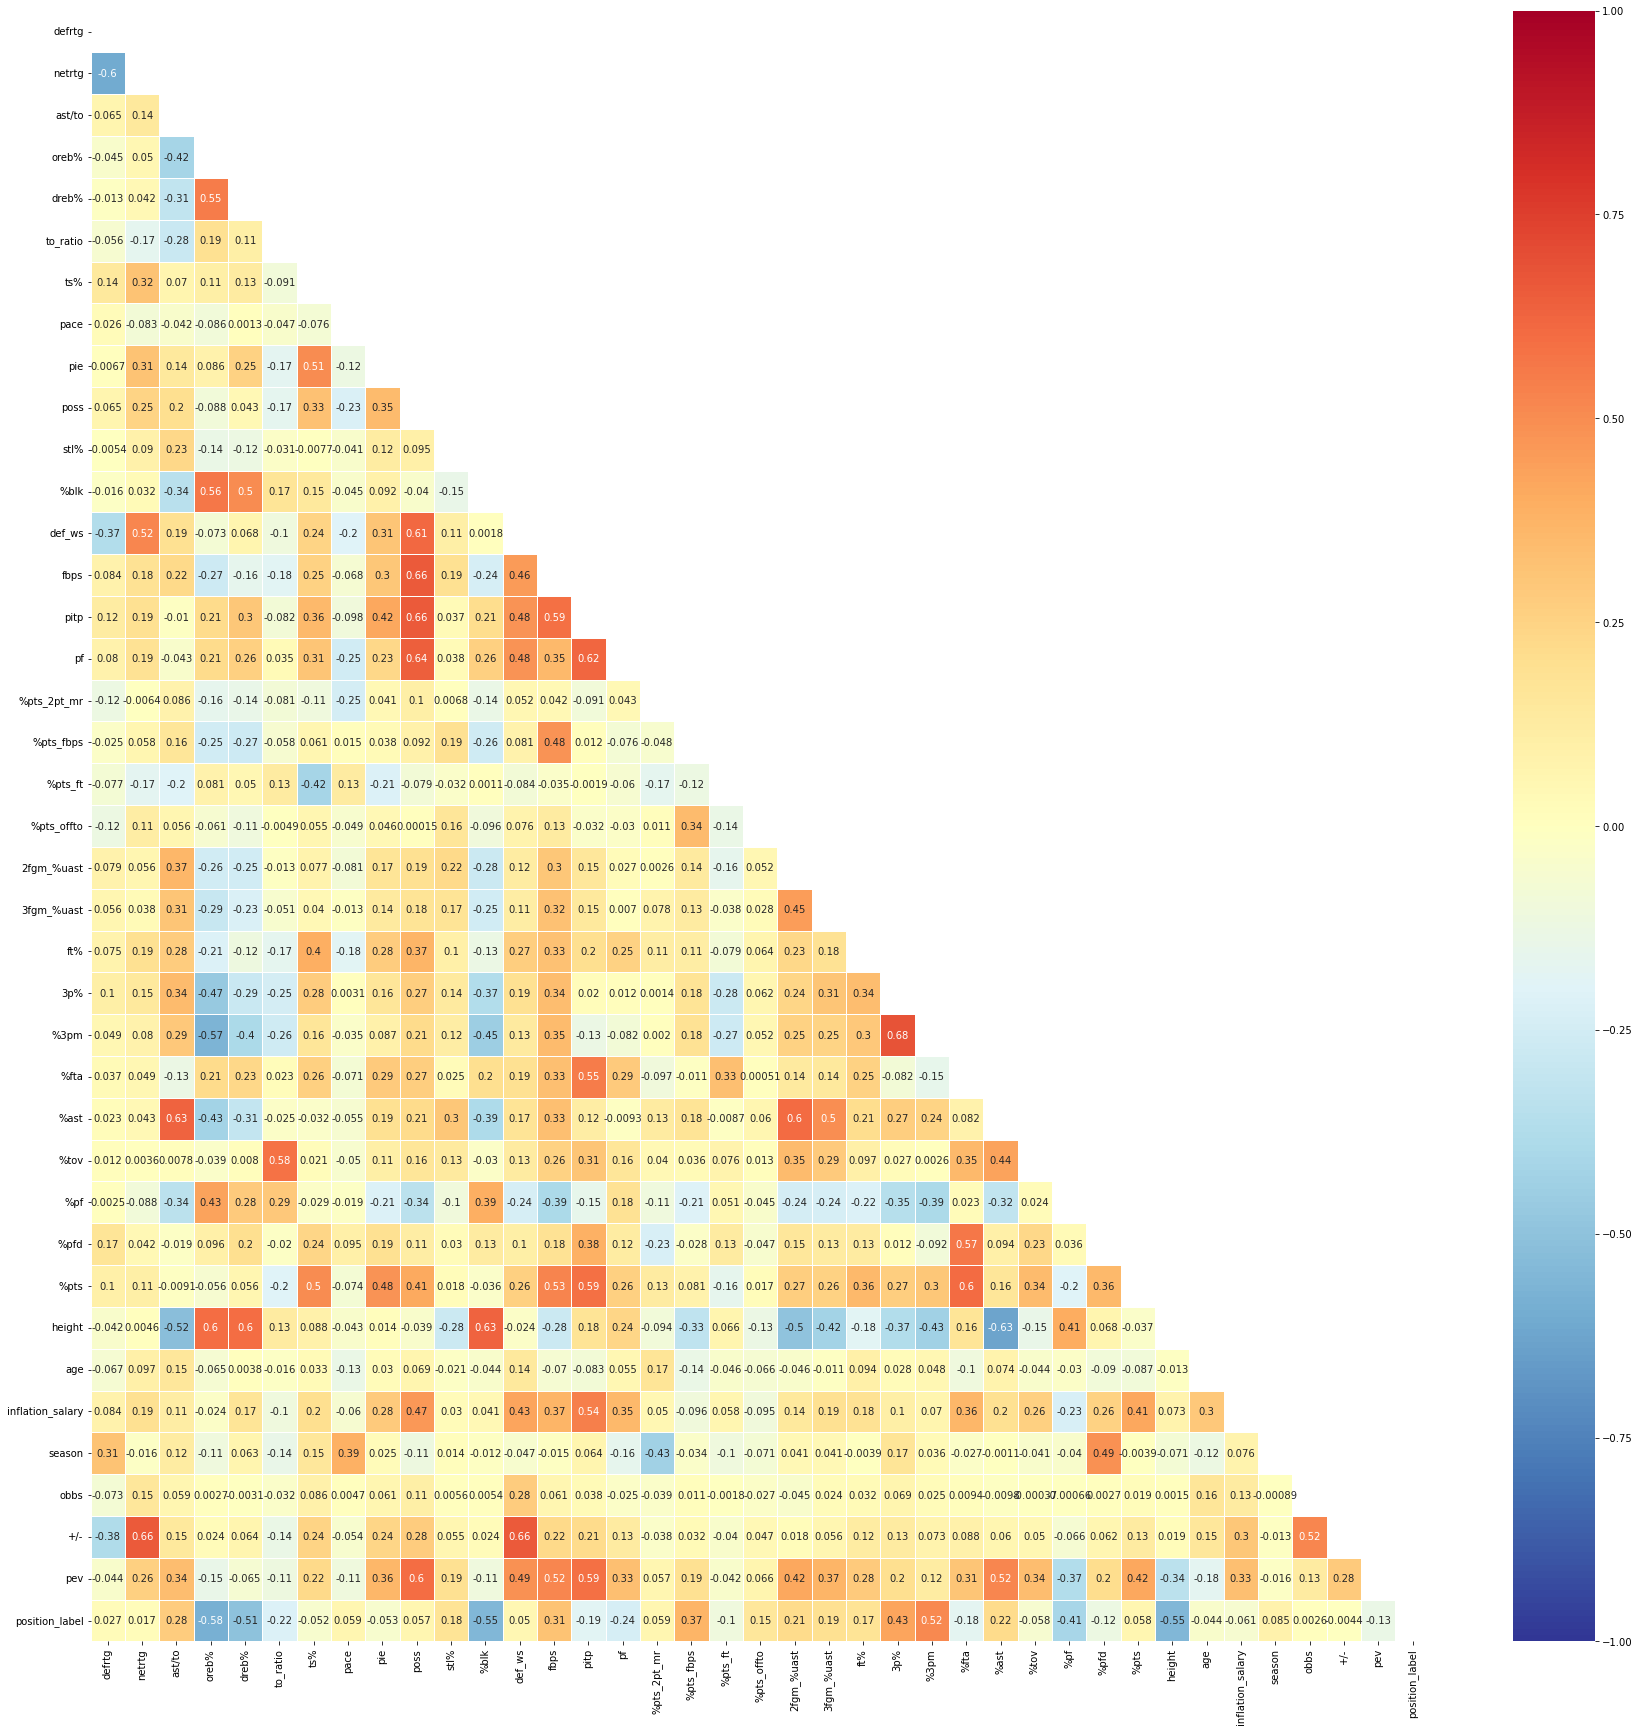

In [7]:
corrHeatMap(df)

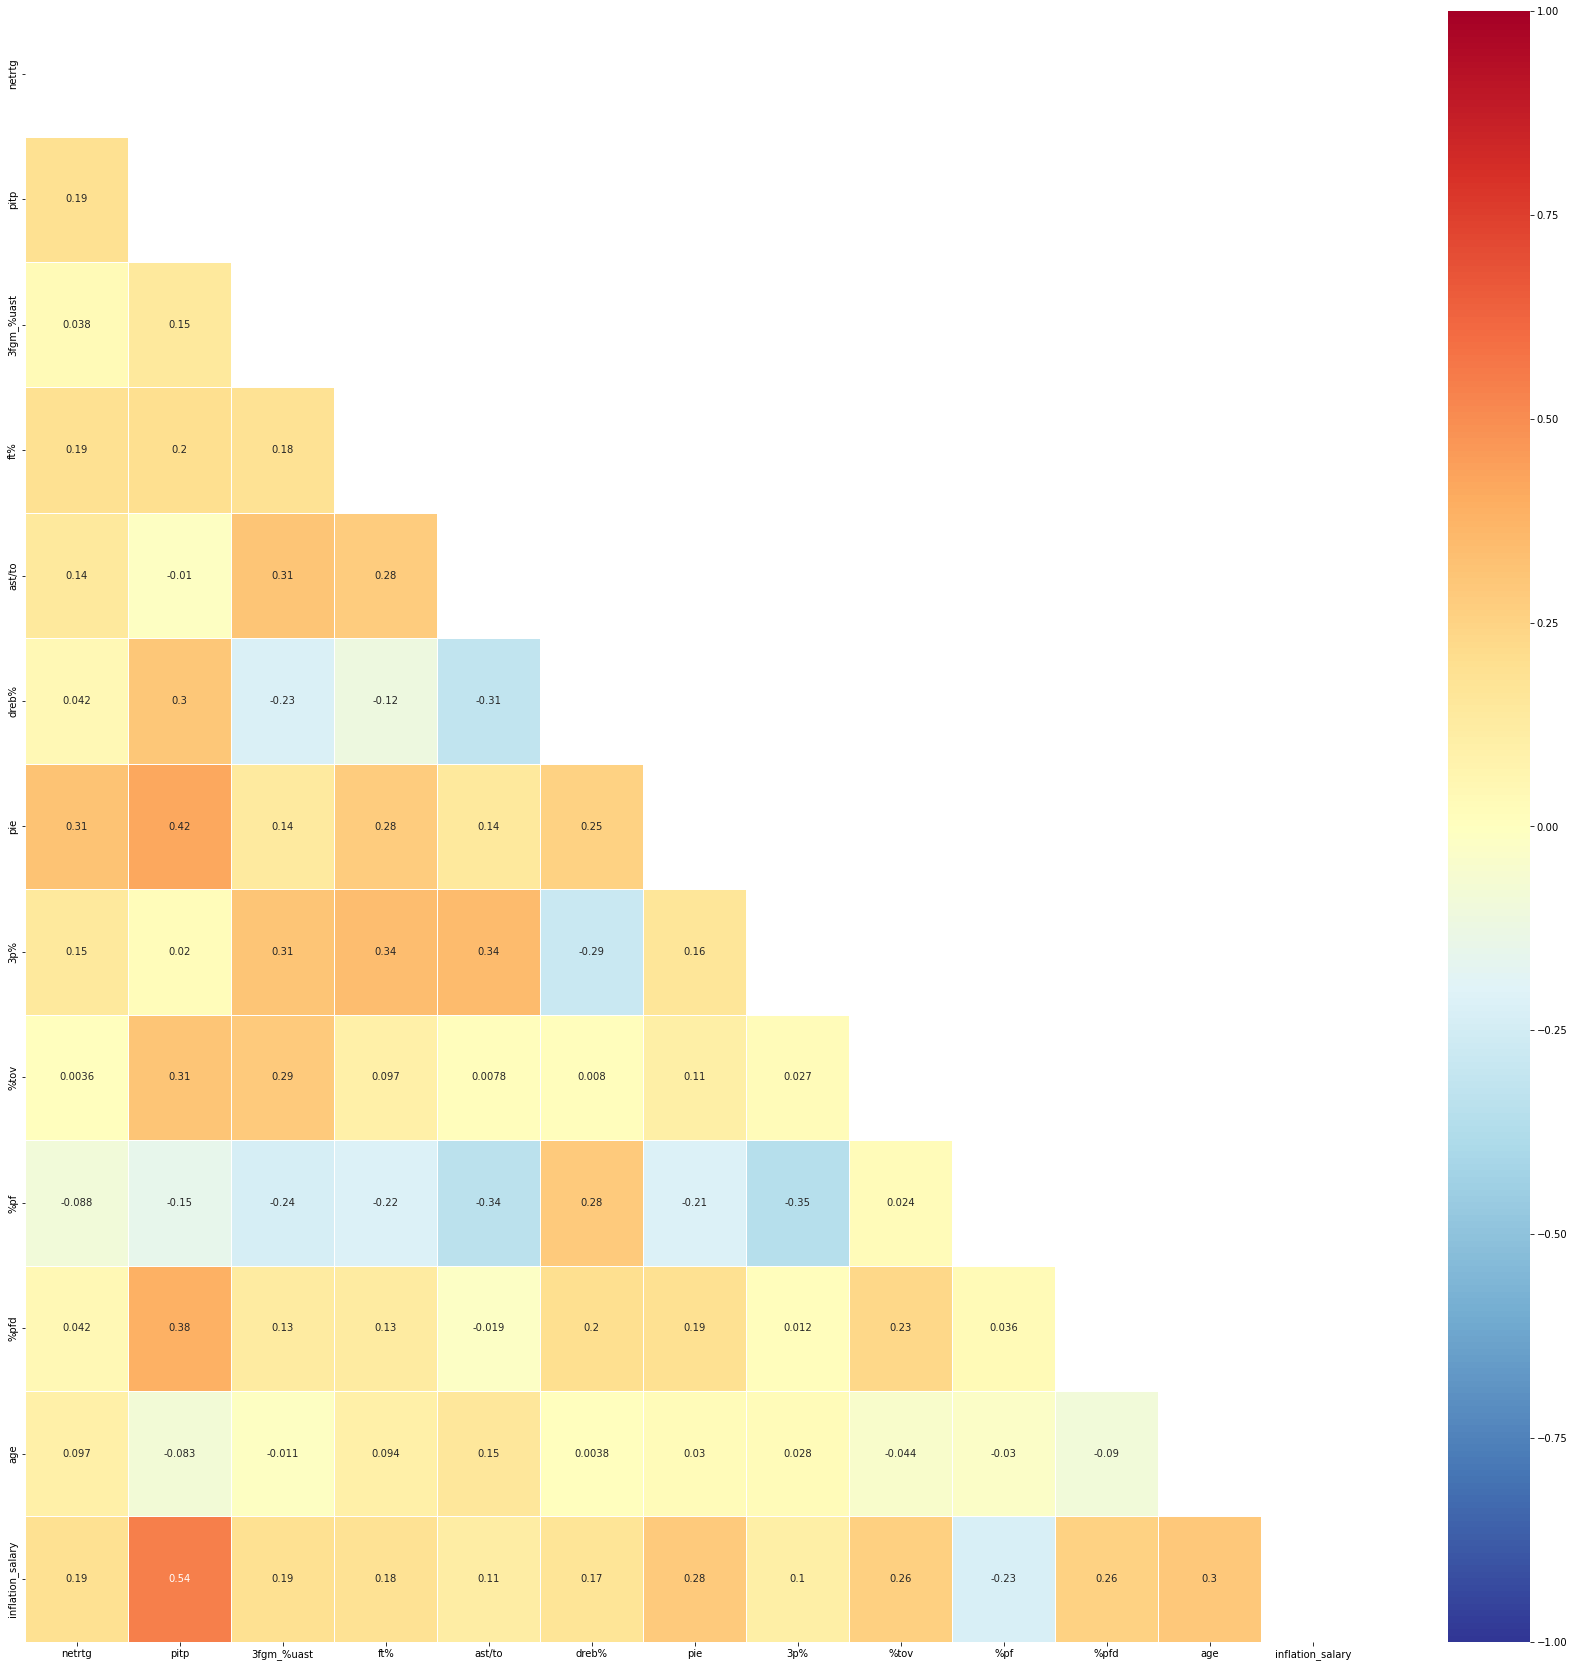

In [8]:
# columns = ["netrtg", "ts%", "pie", "poss", "def_ws", "fbps", "pitp", "pf", f"3fgm_%uast", "ft%", 
#            f"%fta", f"%ast", "%tov", "%pf", "%pfd", "%pts", "age", "inflation_salary", "+/-"]
columns = ["netrtg", "pitp", f"3fgm_%uast", "ft%", "ast/to", "dreb%", "pie", "3p%",
           "%tov", "%pf", "%pfd", "age", "inflation_salary",]


df1 = df[columns]
corrHeatMap(df1)


In [9]:
## 정규화 진행
mdf = df1.drop(["inflation_salary"], axis=1)

scaler = MinMaxScaler()
mdf1 = pd.DataFrame(scaler.fit_transform(mdf), columns=mdf.columns)

mdf2 = pd.concat([mdf1, df1.inflation_salary], axis=1)
mdf2


,netrtg,pitp,3fgm_%uast,ft%,ast/to,dreb%,pie,3p%,%tov,%pf,%pfd,age,inflation_salary
0,0.4974,0.275556,0.000,0.713,0.020000,0.184,0.810912,0.257,0.256,0.250,0.042,0.538462,NaN
1,0.5166,0.102222,0.000,0.695,0.071905,0.160,0.805200,0.250,0.105,0.168,0.019,0.692308,NaN
2,0.5030,0.071111,0.000,0.829,0.100952,0.101,0.807367,0.364,0.176,0.194,0.008,0.346154,NaN
3,0.4864,0.346667,0.000,0.671,0.026190,0.109,0.803427,0.100,0.156,0.201,0.012,0.346154,9200140.0
4,0.5046,0.146667,0.104,0.838,0.057143,0.074,0.810321,0.436,0.200,0.141,0.020,0.423077,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11416,0.3858,0.000000,0.000,0.000,0.000000,0.250,0.803033,0.000,0.000,0.000,0.000,0.346154,NaN
11417,0.2142,0.000000,0.000,0.000,0.000000,0.000,0.778609,0.000,0.000,0.000,0.000,0.192308,1563518.0
11418,0.3000,0.000000,0.000,0.000,0.000000,0.000,0.787867,0.000,0.000,0.000,0.000,0.076923,NaN
11419,0.5008,0.000000,0.000,0.000,0.000000,0.152,0.793973,0.000,0.000,0.333,0.000,0.346154,3000000.0


In [10]:
conDf = pd.concat([df[["player", "team", "position"]], mdf2], axis=1)
conDf


,player,team,position,netrtg,pitp,3fgm_%uast,ft%,ast/to,dreb%,pie,3p%,%tov,%pf,%pfd,age,inflation_salary
0,Chris Gatling,Denver Nuggets,PF,0.4974,0.275556,0.000,0.713,0.020000,0.184,0.810912,0.257,0.256,0.250,0.042,0.538462,NaN
1,A.C. Green,Los Angeles Lakers,PF,0.5166,0.102222,0.000,0.695,0.071905,0.160,0.805200,0.250,0.105,0.168,0.019,0.692308,NaN
2,Aaron McKie,Philadelphia 76ers,SG,0.5030,0.071111,0.000,0.829,0.100952,0.101,0.807367,0.364,0.176,0.194,0.008,0.346154,NaN
3,Alan Henderson,Atlanta Hawks,PF,0.4864,0.346667,0.000,0.671,0.026190,0.109,0.803427,0.100,0.156,0.201,0.012,0.346154,9200140.0
4,Allan Houston,New York Knicks,SG,0.5046,0.146667,0.104,0.838,0.057143,0.074,0.810321,0.436,0.200,0.141,0.020,0.423077,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11416,Malcolm Hill,Chicago Bulls,SF,0.3858,0.000000,0.000,0.000,0.000000,0.250,0.803033,0.000,0.000,0.000,0.000,0.346154,NaN
11417,Marko Simonovic,Chicago Bulls,C,0.2142,0.000000,0.000,0.000,0.000000,0.000,0.778609,0.000,0.000,0.000,0.000,0.192308,1563518.0
11418,Michael Foster Jr.,Philadelphia 76ers,PF,0.3000,0.000000,0.000,0.000,0.000000,0.000,0.787867,0.000,0.000,0.000,0.000,0.076923,NaN
11419,Sterling Brown,Los Angeles Lakers,C,0.5008,0.000000,0.000,0.000,0.000000,0.152,0.793973,0.000,0.000,0.333,0.000,0.346154,3000000.0


In [11]:
train_set = conDf[conDf["inflation_salary"].notna()]
test_set = conDf[conDf["inflation_salary"].isna()]

In [12]:
X = train_set.drop(["player", "team", "position", "inflation_salary"], axis=1)
y = train_set["inflation_salary"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=32)
print(f"X_train's shape : {X_train.shape}")
print(f"X_val's shape : {X_val.shape}")
print(f"y_train's shape : {y_train.shape}")
print(f"y_val's shape : {y_val.shape}")


X_train's shape : (7588, 12)
X_val's shape : (1898, 12)
y_train's shape : (7588,)
y_val's shape : (1898,)


In [13]:
# 연봉 예측 모델 설계
def salPredictModel(X_train, y_train, X_val, y_val, HIDDEN_UNITS, INPUT_DIM, EPOCHS, opti, lossFunc, NORM, BATCH_SIZE, INITIALIZER, checkpoint):
    model = Sequential()
    model.add(Dense(HIDDEN_UNITS, input_dim=INPUT_DIM, activation='elu', kernel_initializer=INITIALIZER))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='elu', kernel_regularizer=NORM))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    model.summary()
    model.compile(optimizer=opti, loss=lossFunc, metrics=[RootMeanSquaredError()])
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val), 
                        epochs=EPOCHS, 
                        verbose=1,
                        batch_size=BATCH_SIZE,
                        callbacks=[checkpoint])
    
    return model, history


In [14]:
# rmse 함수 정의
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [15]:
HIDDEN_UNITS = 128
EPOCHS = 10000
BATCH_SIZE = 64
opti = Nadam(learning_rate=0.003)
lossFunc = rmse
NORM = regularizers.l2(0.1)
INPUT_DIM = 12
INITIALIZER = HeNormal()

save_path = './model_save/'+'{epoch:03d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model, history = salPredictModel(X_train, y_train, X_val, y_val, HIDDEN_UNITS, INPUT_DIM, 
                                 EPOCHS, opti, lossFunc, NORM, BATCH_SIZE, INITIALIZER, checkpoint)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 18,305
Trainable params: 18,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
119/119 [==============================] - 2s 9ms/step - loss: 10760068.0000 - root_mean_squared_error


Epoch 23: val_loss improved from 7296503.00000 to 7250501.00000, saving model to ./model_save\023-7250501.0000.hdf5
Epoch 24/10000
119/119 [==============================] - 1s 6ms/step - loss: 7281797.0000 - root_mean_squared_error: 7310335.0000 - val_loss: 7198176.5000 - val_root_mean_squared_error: 7194115.0000

Epoch 24: val_loss improved from 7250501.00000 to 7198176.50000, saving model to ./model_save\024-7198176.5000.hdf5
Epoch 25/10000
119/119 [==============================] - 1s 5ms/step - loss: 7243646.5000 - root_mean_squared_error: 7246495.0000 - val_loss: 7150257.0000 - val_root_mean_squared_error: 7142995.0000

Epoch 25: val_loss improved from 7198176.50000 to 7150257.00000, saving model to ./model_save\025-7150257.0000.hdf5
Epoch 26/10000
119/119 [==============================] - 1s 5ms/step - loss: 7178278.0000 - root_mean_squared_error: 7190741.0000 - val_loss: 7092288.0000 - val_root_mean_squared_error: 7080073.0000

Epoch 26: val_loss improved from 7150257.00000 t


Epoch 49: val_loss improved from 6097789.00000 to 6076964.00000, saving model to ./model_save\049-6076964.0000.hdf5
Epoch 50/10000
119/119 [==============================] - 1s 9ms/step - loss: 6290247.0000 - root_mean_squared_error: 6195239.0000 - val_loss: 6070047.5000 - val_root_mean_squared_error: 5979952.5000

Epoch 50: val_loss improved from 6076964.00000 to 6070047.50000, saving model to ./model_save\050-6070047.5000.hdf5
Epoch 51/10000
119/119 [==============================] - 1s 8ms/step - loss: 6265827.0000 - root_mean_squared_error: 6170629.5000 - val_loss: 6060304.0000 - val_root_mean_squared_error: 5969761.5000

Epoch 51: val_loss improved from 6070047.50000 to 6060304.00000, saving model to ./model_save\051-6060304.0000.hdf5
Epoch 52/10000
119/119 [==============================] - 1s 7ms/step - loss: 6233920.0000 - root_mean_squared_error: 6149880.5000 - val_loss: 6060064.5000 - val_root_mean_squared_error: 5969782.0000

Epoch 52: val_loss improved from 6060304.00000 t

Epoch 76/10000
119/119 [==============================] - 1s 6ms/step - loss: 6188965.5000 - root_mean_squared_error: 6099144.0000 - val_loss: 5966155.5000 - val_root_mean_squared_error: 5884788.5000

Epoch 76: val_loss did not improve from 5961522.50000
Epoch 77/10000
119/119 [==============================] - 1s 6ms/step - loss: 6198276.5000 - root_mean_squared_error: 6111444.0000 - val_loss: 5957740.0000 - val_root_mean_squared_error: 5876314.5000

Epoch 77: val_loss improved from 5961522.50000 to 5957740.00000, saving model to ./model_save\077-5957740.0000.hdf5
Epoch 78/10000
119/119 [==============================] - 1s 7ms/step - loss: 6168527.0000 - root_mean_squared_error: 6093801.5000 - val_loss: 5956425.0000 - val_root_mean_squared_error: 5875594.0000

Epoch 78: val_loss improved from 5957740.00000 to 5956425.00000, saving model to ./model_save\078-5956425.0000.hdf5
Epoch 79/10000
119/119 [==============================] - 1s 6ms/step - loss: 6198645.5000 - root_mean_squared_

119/119 [==============================] - 1s 7ms/step - loss: 6153940.0000 - root_mean_squared_error: 6094697.0000 - val_loss: 5912520.0000 - val_root_mean_squared_error: 5861011.0000

Epoch 134: val_loss did not improve from 5905031.50000
Epoch 135/10000
119/119 [==============================] - 1s 7ms/step - loss: 6146803.5000 - root_mean_squared_error: 6087725.5000 - val_loss: 5904735.0000 - val_root_mean_squared_error: 5852830.5000

Epoch 135: val_loss improved from 5905031.50000 to 5904735.00000, saving model to ./model_save\135-5904735.0000.hdf5
Epoch 136/10000
119/119 [==============================] - 1s 7ms/step - loss: 6138799.0000 - root_mean_squared_error: 6096056.5000 - val_loss: 5907672.0000 - val_root_mean_squared_error: 5856581.0000

Epoch 136: val_loss did not improve from 5904735.00000
Epoch 137/10000
119/119 [==============================] - 1s 7ms/step - loss: 6148957.5000 - root_mean_squared_error: 6087652.0000 - val_loss: 5909997.5000 - val_root_mean_squared_er

119/119 [==============================] - 1s 8ms/step - loss: 6108640.5000 - root_mean_squared_error: 6074858.0000 - val_loss: 5881405.5000 - val_root_mean_squared_error: 5838532.0000

Epoch 163: val_loss improved from 5884080.00000 to 5881405.50000, saving model to ./model_save\163-5881405.5000.hdf5
Epoch 164/10000
119/119 [==============================] - 1s 8ms/step - loss: 6101303.5000 - root_mean_squared_error: 6061578.0000 - val_loss: 5877274.0000 - val_root_mean_squared_error: 5834150.0000

Epoch 164: val_loss improved from 5881405.50000 to 5877274.00000, saving model to ./model_save\164-5877274.0000.hdf5
Epoch 165/10000
119/119 [==============================] - 1s 7ms/step - loss: 6116466.0000 - root_mean_squared_error: 6075608.0000 - val_loss: 5890540.5000 - val_root_mean_squared_error: 5849042.0000

Epoch 165: val_loss did not improve from 5877274.00000
Epoch 166/10000
119/119 [==============================] - 1s 7ms/step - loss: 6091011.0000 - root_mean_squared_error: 60


Epoch 219: val_loss did not improve from 5758171.00000
Epoch 220/10000
119/119 [==============================] - 1s 8ms/step - loss: 5962168.0000 - root_mean_squared_error: 5918875.0000 - val_loss: 5767027.0000 - val_root_mean_squared_error: 5725713.5000

Epoch 220: val_loss did not improve from 5758171.00000
Epoch 221/10000
119/119 [==============================] - 1s 7ms/step - loss: 5966940.5000 - root_mean_squared_error: 5930636.0000 - val_loss: 5752805.5000 - val_root_mean_squared_error: 5710500.5000

Epoch 221: val_loss improved from 5758171.00000 to 5752805.50000, saving model to ./model_save\221-5752805.5000.hdf5
Epoch 222/10000
119/119 [==============================] - 1s 7ms/step - loss: 5950412.5000 - root_mean_squared_error: 5926884.5000 - val_loss: 5754813.5000 - val_root_mean_squared_error: 5712848.5000

Epoch 222: val_loss did not improve from 5752805.50000
Epoch 223/10000
119/119 [==============================] - 1s 7ms/step - loss: 5974649.5000 - root_mean_squared


Epoch 248: val_loss did not improve from 5708398.50000
Epoch 249/10000
119/119 [==============================] - 1s 7ms/step - loss: 5933366.5000 - root_mean_squared_error: 5887785.5000 - val_loss: 5708861.0000 - val_root_mean_squared_error: 5665832.5000

Epoch 249: val_loss did not improve from 5708398.50000
Epoch 250/10000
119/119 [==============================] - 1s 7ms/step - loss: 5915630.0000 - root_mean_squared_error: 5881983.0000 - val_loss: 5711102.5000 - val_root_mean_squared_error: 5668364.5000

Epoch 250: val_loss did not improve from 5708398.50000
Epoch 251/10000
119/119 [==============================] - 1s 7ms/step - loss: 5920434.5000 - root_mean_squared_error: 5864774.0000 - val_loss: 5711621.5000 - val_root_mean_squared_error: 5668927.0000

Epoch 251: val_loss did not improve from 5708398.50000
Epoch 252/10000
119/119 [==============================] - 1s 7ms/step - loss: 5920055.0000 - root_mean_squared_error: 5869324.5000 - val_loss: 5707255.0000 - val_root_mean_


Epoch 277: val_loss did not improve from 5679247.00000
Epoch 278/10000
119/119 [==============================] - 1s 7ms/step - loss: 5895323.0000 - root_mean_squared_error: 5851683.5000 - val_loss: 5683652.0000 - val_root_mean_squared_error: 5641793.0000

Epoch 278: val_loss did not improve from 5679247.00000
Epoch 279/10000
119/119 [==============================] - 1s 7ms/step - loss: 5885805.5000 - root_mean_squared_error: 5836908.0000 - val_loss: 5684781.0000 - val_root_mean_squared_error: 5643068.0000

Epoch 279: val_loss did not improve from 5679247.00000
Epoch 280/10000
119/119 [==============================] - 1s 8ms/step - loss: 5870985.0000 - root_mean_squared_error: 5826457.5000 - val_loss: 5677821.0000 - val_root_mean_squared_error: 5635794.0000

Epoch 280: val_loss improved from 5679247.00000 to 5677821.00000, saving model to ./model_save\280-5677821.0000.hdf5
Epoch 281/10000
119/119 [==============================] - 1s 7ms/step - loss: 5859870.0000 - root_mean_squared


Epoch 307: val_loss improved from 5661378.00000 to 5657827.50000, saving model to ./model_save\307-5657827.5000.hdf5
Epoch 308/10000
119/119 [==============================] - 1s 7ms/step - loss: 5849975.0000 - root_mean_squared_error: 5823037.0000 - val_loss: 5659365.5000 - val_root_mean_squared_error: 5620197.5000

Epoch 308: val_loss did not improve from 5657827.50000
Epoch 309/10000
119/119 [==============================] - 1s 7ms/step - loss: 5856000.5000 - root_mean_squared_error: 5818944.5000 - val_loss: 5663894.0000 - val_root_mean_squared_error: 5625178.5000

Epoch 309: val_loss did not improve from 5657827.50000
Epoch 310/10000
119/119 [==============================] - 1s 8ms/step - loss: 5854299.0000 - root_mean_squared_error: 5810610.5000 - val_loss: 5659074.5000 - val_root_mean_squared_error: 5620275.0000

Epoch 310: val_loss did not improve from 5657827.50000
Epoch 311/10000
119/119 [==============================] - 1s 7ms/step - loss: 5837266.5000 - root_mean_squared


Epoch 337: val_loss did not improve from 5647572.00000
Epoch 338/10000
119/119 [==============================] - 1s 7ms/step - loss: 5847914.0000 - root_mean_squared_error: 5799514.5000 - val_loss: 5647872.5000 - val_root_mean_squared_error: 5613052.5000

Epoch 338: val_loss did not improve from 5647572.00000
Epoch 339/10000
119/119 [==============================] - 1s 7ms/step - loss: 5809117.0000 - root_mean_squared_error: 5774536.0000 - val_loss: 5646587.5000 - val_root_mean_squared_error: 5611881.0000

Epoch 339: val_loss improved from 5647572.00000 to 5646587.50000, saving model to ./model_save\339-5646587.5000.hdf5
Epoch 340/10000
119/119 [==============================] - 1s 7ms/step - loss: 5850665.0000 - root_mean_squared_error: 5803158.0000 - val_loss: 5641332.5000 - val_root_mean_squared_error: 5606377.0000

Epoch 340: val_loss improved from 5646587.50000 to 5641332.50000, saving model to ./model_save\340-5641332.5000.hdf5
Epoch 341/10000
119/119 [========================

Epoch 399/10000
119/119 [==============================] - 1s 7ms/step - loss: 5803618.0000 - root_mean_squared_error: 5779061.5000 - val_loss: 5627765.5000 - val_root_mean_squared_error: 5602246.0000

Epoch 399: val_loss did not improve from 5621657.00000
Epoch 400/10000
119/119 [==============================] - 1s 7ms/step - loss: 5787960.5000 - root_mean_squared_error: 5754155.0000 - val_loss: 5625077.0000 - val_root_mean_squared_error: 5599564.0000

Epoch 400: val_loss did not improve from 5621657.00000
Epoch 401/10000
119/119 [==============================] - 1s 7ms/step - loss: 5771913.0000 - root_mean_squared_error: 5749887.5000 - val_loss: 5623921.5000 - val_root_mean_squared_error: 5598540.0000

Epoch 401: val_loss did not improve from 5621657.00000
Epoch 402/10000
119/119 [==============================] - 1s 7ms/step - loss: 5799097.0000 - root_mean_squared_error: 5773933.0000 - val_loss: 5632520.5000 - val_root_mean_squared_error: 5607756.0000

Epoch 402: val_loss did not

119/119 [==============================] - 1s 7ms/step - loss: 5776574.0000 - root_mean_squared_error: 5759996.5000 - val_loss: 5611802.0000 - val_root_mean_squared_error: 5594477.0000

Epoch 460: val_loss did not improve from 5608134.00000
Epoch 461/10000
119/119 [==============================] - 1s 7ms/step - loss: 5761992.0000 - root_mean_squared_error: 5744184.0000 - val_loss: 5614959.5000 - val_root_mean_squared_error: 5597891.5000

Epoch 461: val_loss did not improve from 5608134.00000
Epoch 462/10000
119/119 [==============================] - 1s 7ms/step - loss: 5788691.5000 - root_mean_squared_error: 5762854.5000 - val_loss: 5604753.0000 - val_root_mean_squared_error: 5587205.0000

Epoch 462: val_loss improved from 5608134.00000 to 5604753.00000, saving model to ./model_save\462-5604753.0000.hdf5
Epoch 463/10000
119/119 [==============================] - 1s 8ms/step - loss: 5805913.0000 - root_mean_squared_error: 5773792.0000 - val_loss: 5611450.5000 - val_root_mean_squared_er

Epoch 521/10000
119/119 [==============================] - 1s 7ms/step - loss: 5757019.0000 - root_mean_squared_error: 5743302.5000 - val_loss: 5597603.5000 - val_root_mean_squared_error: 5587101.0000

Epoch 521: val_loss did not improve from 5592982.50000
Epoch 522/10000
119/119 [==============================] - 1s 7ms/step - loss: 5748456.0000 - root_mean_squared_error: 5736541.0000 - val_loss: 5602534.5000 - val_root_mean_squared_error: 5592351.0000

Epoch 522: val_loss did not improve from 5592982.50000
Epoch 523/10000
119/119 [==============================] - 1s 8ms/step - loss: 5728375.5000 - root_mean_squared_error: 5723434.5000 - val_loss: 5590844.5000 - val_root_mean_squared_error: 5580126.5000

Epoch 523: val_loss improved from 5592982.50000 to 5590844.50000, saving model to ./model_save\523-5590844.5000.hdf5
Epoch 524/10000
119/119 [==============================] - 1s 7ms/step - loss: 5800006.0000 - root_mean_squared_error: 5782383.0000 - val_loss: 5590731.0000 - val_root

Epoch 582/10000
119/119 [==============================] - 1s 7ms/step - loss: 5724221.5000 - root_mean_squared_error: 5722327.5000 - val_loss: 5586955.0000 - val_root_mean_squared_error: 5581929.0000

Epoch 582: val_loss did not improve from 5578946.00000
Epoch 583/10000
119/119 [==============================] - 1s 7ms/step - loss: 5760086.5000 - root_mean_squared_error: 5746150.0000 - val_loss: 5582002.0000 - val_root_mean_squared_error: 5576835.0000

Epoch 583: val_loss did not improve from 5578946.00000
Epoch 584/10000
119/119 [==============================] - 1s 7ms/step - loss: 5706689.0000 - root_mean_squared_error: 5704153.0000 - val_loss: 5579891.5000 - val_root_mean_squared_error: 5574728.0000

Epoch 584: val_loss did not improve from 5578946.00000
Epoch 585/10000
119/119 [==============================] - 1s 7ms/step - loss: 5743609.5000 - root_mean_squared_error: 5747496.5000 - val_loss: 5584287.0000 - val_root_mean_squared_error: 5579519.5000

Epoch 585: val_loss did not

Epoch 613/10000
119/119 [==============================] - 1s 7ms/step - loss: 5733734.5000 - root_mean_squared_error: 5726736.0000 - val_loss: 5571003.5000 - val_root_mean_squared_error: 5568111.5000

Epoch 613: val_loss improved from 5573468.00000 to 5571003.50000, saving model to ./model_save\613-5571003.5000.hdf5
Epoch 614/10000
119/119 [==============================] - 1s 7ms/step - loss: 5732866.5000 - root_mean_squared_error: 5731271.5000 - val_loss: 5581795.5000 - val_root_mean_squared_error: 5579624.5000

Epoch 614: val_loss did not improve from 5571003.50000
Epoch 615/10000
119/119 [==============================] - 1s 7ms/step - loss: 5739356.0000 - root_mean_squared_error: 5725250.0000 - val_loss: 5574318.5000 - val_root_mean_squared_error: 5571800.0000

Epoch 615: val_loss did not improve from 5571003.50000
Epoch 616/10000
119/119 [==============================] - 1s 7ms/step - loss: 5731140.0000 - root_mean_squared_error: 5725810.0000 - val_loss: 5577258.0000 - val_root

Epoch 675/10000
119/119 [==============================] - 1s 7ms/step - loss: 5701794.5000 - root_mean_squared_error: 5706185.5000 - val_loss: 5573114.0000 - val_root_mean_squared_error: 5575273.0000

Epoch 675: val_loss did not improve from 5562182.50000
Epoch 676/10000
119/119 [==============================] - 1s 7ms/step - loss: 5752240.5000 - root_mean_squared_error: 5736697.5000 - val_loss: 5566550.0000 - val_root_mean_squared_error: 5568502.0000

Epoch 676: val_loss did not improve from 5562182.50000
Epoch 677/10000
119/119 [==============================] - 1s 7ms/step - loss: 5728502.0000 - root_mean_squared_error: 5720547.5000 - val_loss: 5562267.0000 - val_root_mean_squared_error: 5564003.0000

Epoch 677: val_loss did not improve from 5562182.50000
Epoch 678/10000
119/119 [==============================] - 1s 7ms/step - loss: 5696089.0000 - root_mean_squared_error: 5701037.5000 - val_loss: 5568464.5000 - val_root_mean_squared_error: 5570652.0000

Epoch 678: val_loss did not


Epoch 706: val_loss did not improve from 5558054.50000
Epoch 707/10000
119/119 [==============================] - 1s 7ms/step - loss: 5716592.5000 - root_mean_squared_error: 5715919.5000 - val_loss: 5570528.0000 - val_root_mean_squared_error: 5574716.5000

Epoch 707: val_loss did not improve from 5558054.50000
Epoch 708/10000
119/119 [==============================] - 1s 7ms/step - loss: 5725903.5000 - root_mean_squared_error: 5712738.0000 - val_loss: 5563066.5000 - val_root_mean_squared_error: 5566984.5000

Epoch 708: val_loss did not improve from 5558054.50000
Epoch 709/10000
119/119 [==============================] - 1s 8ms/step - loss: 5718329.5000 - root_mean_squared_error: 5711962.5000 - val_loss: 5562660.0000 - val_root_mean_squared_error: 5566642.5000

Epoch 709: val_loss did not improve from 5558054.50000
Epoch 710/10000
119/119 [==============================] - 1s 7ms/step - loss: 5710634.0000 - root_mean_squared_error: 5718276.5000 - val_loss: 5559932.5000 - val_root_mean_

Epoch 738/10000
119/119 [==============================] - 1s 8ms/step - loss: 5696776.5000 - root_mean_squared_error: 5694247.0000 - val_loss: 5562842.0000 - val_root_mean_squared_error: 5568809.5000

Epoch 738: val_loss did not improve from 5556810.50000
Epoch 739/10000
119/119 [==============================] - 1s 7ms/step - loss: 5714149.0000 - root_mean_squared_error: 5713420.5000 - val_loss: 5559420.0000 - val_root_mean_squared_error: 5565288.5000

Epoch 739: val_loss did not improve from 5556810.50000
Epoch 740/10000
119/119 [==============================] - 1s 7ms/step - loss: 5692797.5000 - root_mean_squared_error: 5706239.0000 - val_loss: 5558802.5000 - val_root_mean_squared_error: 5564704.5000

Epoch 740: val_loss did not improve from 5556810.50000
Epoch 741/10000
119/119 [==============================] - 1s 7ms/step - loss: 5724678.0000 - root_mean_squared_error: 5731700.0000 - val_loss: 5564597.5000 - val_root_mean_squared_error: 5570842.5000

Epoch 741: val_loss did not


Epoch 769: val_loss did not improve from 5553547.00000
Epoch 770/10000
119/119 [==============================] - 1s 7ms/step - loss: 5718352.0000 - root_mean_squared_error: 5713991.0000 - val_loss: 5554687.5000 - val_root_mean_squared_error: 5562211.5000

Epoch 770: val_loss did not improve from 5553547.00000
Epoch 771/10000
119/119 [==============================] - 1s 7ms/step - loss: 5707757.0000 - root_mean_squared_error: 5710084.0000 - val_loss: 5552251.0000 - val_root_mean_squared_error: 5559662.5000

Epoch 771: val_loss improved from 5553547.00000 to 5552251.00000, saving model to ./model_save\771-5552251.0000.hdf5
Epoch 772/10000
119/119 [==============================] - 1s 7ms/step - loss: 5683937.0000 - root_mean_squared_error: 5689689.5000 - val_loss: 5560318.0000 - val_root_mean_squared_error: 5568176.0000

Epoch 772: val_loss did not improve from 5552251.00000
Epoch 773/10000
119/119 [==============================] - 1s 7ms/step - loss: 5702538.5000 - root_mean_squared

Epoch 801/10000
119/119 [==============================] - 1s 7ms/step - loss: 5713676.5000 - root_mean_squared_error: 5714683.5000 - val_loss: 5555430.0000 - val_root_mean_squared_error: 5564475.5000

Epoch 801: val_loss did not improve from 5550638.50000
Epoch 802/10000
119/119 [==============================] - 1s 8ms/step - loss: 5716247.5000 - root_mean_squared_error: 5714682.0000 - val_loss: 5560954.0000 - val_root_mean_squared_error: 5570287.0000

Epoch 802: val_loss did not improve from 5550638.50000
Epoch 803/10000
119/119 [==============================] - 1s 7ms/step - loss: 5699259.0000 - root_mean_squared_error: 5703977.0000 - val_loss: 5562175.0000 - val_root_mean_squared_error: 5571646.5000

Epoch 803: val_loss did not improve from 5550638.50000
Epoch 804/10000
119/119 [==============================] - 1s 7ms/step - loss: 5693673.5000 - root_mean_squared_error: 5695464.5000 - val_loss: 5553821.5000 - val_root_mean_squared_error: 5562996.0000

Epoch 804: val_loss did not

119/119 [==============================] - 1s 7ms/step - loss: 5684582.0000 - root_mean_squared_error: 5696678.5000 - val_loss: 5551346.0000 - val_root_mean_squared_error: 5563258.0000

Epoch 863: val_loss did not improve from 5542885.00000
Epoch 864/10000
119/119 [==============================] - 1s 7ms/step - loss: 5701408.0000 - root_mean_squared_error: 5706989.0000 - val_loss: 5550177.0000 - val_root_mean_squared_error: 5562033.0000

Epoch 864: val_loss did not improve from 5542885.00000
Epoch 865/10000
119/119 [==============================] - 1s 7ms/step - loss: 5667398.5000 - root_mean_squared_error: 5674257.5000 - val_loss: 5547511.0000 - val_root_mean_squared_error: 5559285.5000

Epoch 865: val_loss did not improve from 5542885.00000
Epoch 866/10000
119/119 [==============================] - 1s 8ms/step - loss: 5699526.0000 - root_mean_squared_error: 5704737.5000 - val_loss: 5542786.5000 - val_root_mean_squared_error: 5554334.5000

Epoch 866: val_loss improved from 5542885.0

Epoch 894/10000
119/119 [==============================] - 1s 7ms/step - loss: 5702701.5000 - root_mean_squared_error: 5707437.5000 - val_loss: 5540213.5000 - val_root_mean_squared_error: 5552927.5000

Epoch 894: val_loss did not improve from 5538117.50000
Epoch 895/10000
119/119 [==============================] - 1s 7ms/step - loss: 5687405.5000 - root_mean_squared_error: 5685915.5000 - val_loss: 5544752.5000 - val_root_mean_squared_error: 5557722.5000

Epoch 895: val_loss did not improve from 5538117.50000
Epoch 896/10000
119/119 [==============================] - 1s 7ms/step - loss: 5688036.0000 - root_mean_squared_error: 5690842.5000 - val_loss: 5542549.5000 - val_root_mean_squared_error: 5555460.0000

Epoch 896: val_loss did not improve from 5538117.50000
Epoch 897/10000
119/119 [==============================] - 1s 7ms/step - loss: 5706954.5000 - root_mean_squared_error: 5704541.5000 - val_loss: 5540066.5000 - val_root_mean_squared_error: 5552856.0000

Epoch 897: val_loss did not


Epoch 925: val_loss did not improve from 5535395.50000
Epoch 926/10000
119/119 [==============================] - 1s 8ms/step - loss: 5695493.5000 - root_mean_squared_error: 5705641.5000 - val_loss: 5545765.0000 - val_root_mean_squared_error: 5560062.5000

Epoch 926: val_loss did not improve from 5535395.50000
Epoch 927/10000
119/119 [==============================] - 1s 7ms/step - loss: 5672062.0000 - root_mean_squared_error: 5681486.5000 - val_loss: 5539620.0000 - val_root_mean_squared_error: 5553785.5000

Epoch 927: val_loss did not improve from 5535395.50000
Epoch 928/10000
119/119 [==============================] - 1s 7ms/step - loss: 5695239.0000 - root_mean_squared_error: 5697454.5000 - val_loss: 5540005.5000 - val_root_mean_squared_error: 5554265.0000

Epoch 928: val_loss did not improve from 5535395.50000
Epoch 929/10000
119/119 [==============================] - 1s 7ms/step - loss: 5682093.0000 - root_mean_squared_error: 5683282.0000 - val_loss: 5542441.5000 - val_root_mean_

119/119 [==============================] - 1s 7ms/step - loss: 5694354.0000 - root_mean_squared_error: 5693740.0000 - val_loss: 5530928.5000 - val_root_mean_squared_error: 5546974.0000

Epoch 988: val_loss did not improve from 5530117.50000
Epoch 989/10000
119/119 [==============================] - 1s 7ms/step - loss: 5660856.0000 - root_mean_squared_error: 5674445.5000 - val_loss: 5541087.5000 - val_root_mean_squared_error: 5557650.0000

Epoch 989: val_loss did not improve from 5530117.50000
Epoch 990/10000
119/119 [==============================] - 1s 8ms/step - loss: 5653587.5000 - root_mean_squared_error: 5671511.0000 - val_loss: 5531560.0000 - val_root_mean_squared_error: 5547691.0000

Epoch 990: val_loss did not improve from 5530117.50000
Epoch 991/10000
119/119 [==============================] - 1s 7ms/step - loss: 5662437.5000 - root_mean_squared_error: 5669424.0000 - val_loss: 5541166.5000 - val_root_mean_squared_error: 5557791.5000

Epoch 991: val_loss did not improve from 55


Epoch 1019: val_loss did not improve from 5528576.00000
Epoch 1020/10000
119/119 [==============================] - 1s 8ms/step - loss: 5667894.5000 - root_mean_squared_error: 5674309.0000 - val_loss: 5530986.5000 - val_root_mean_squared_error: 5548223.5000

Epoch 1020: val_loss did not improve from 5528576.00000
Epoch 1021/10000
119/119 [==============================] - 1s 7ms/step - loss: 5646608.0000 - root_mean_squared_error: 5668566.0000 - val_loss: 5533190.0000 - val_root_mean_squared_error: 5550509.0000

Epoch 1021: val_loss did not improve from 5528576.00000
Epoch 1022/10000
119/119 [==============================] - 1s 7ms/step - loss: 5694503.5000 - root_mean_squared_error: 5695876.5000 - val_loss: 5530691.5000 - val_root_mean_squared_error: 5547922.0000

Epoch 1022: val_loss did not improve from 5528576.00000
Epoch 1023/10000
119/119 [==============================] - 1s 7ms/step - loss: 5675607.5000 - root_mean_squared_error: 5682174.0000 - val_loss: 5530140.5000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 5679364.0000 - root_mean_squared_error: 5685659.0000 - val_loss: 5529149.5000 - val_root_mean_squared_error: 5547887.0000

Epoch 1081: val_loss did not improve from 5523555.50000
Epoch 1082/10000
119/119 [==============================] - 1s 7ms/step - loss: 5682695.5000 - root_mean_squared_error: 5681689.0000 - val_loss: 5525613.5000 - val_root_mean_squared_error: 5544217.0000

Epoch 1082: val_loss did not improve from 5523555.50000
Epoch 1083/10000
119/119 [==============================] - 1s 7ms/step - loss: 5685954.0000 - root_mean_squared_error: 5693991.5000 - val_loss: 5528614.5000 - val_root_mean_squared_error: 5547416.5000

Epoch 1083: val_loss did not improve from 5523555.50000
Epoch 1084/10000
119/119 [==============================] - 1s 7ms/step - loss: 5648275.0000 - root_mean_squared_error: 5663122.5000 - val_loss: 5531518.5000 - val_root_mean_squared_error: 5550628.0000

Epoch 1084: val_loss did not improve 

Epoch 1143/10000
119/119 [==============================] - 1s 7ms/step - loss: 5644476.5000 - root_mean_squared_error: 5664246.0000 - val_loss: 5523629.5000 - val_root_mean_squared_error: 5543972.0000

Epoch 1143: val_loss did not improve from 5518055.50000
Epoch 1144/10000
119/119 [==============================] - 1s 7ms/step - loss: 5662905.0000 - root_mean_squared_error: 5685094.0000 - val_loss: 5524187.0000 - val_root_mean_squared_error: 5544710.5000

Epoch 1144: val_loss did not improve from 5518055.50000
Epoch 1145/10000
119/119 [==============================] - 1s 7ms/step - loss: 5662680.5000 - root_mean_squared_error: 5671941.5000 - val_loss: 5520086.5000 - val_root_mean_squared_error: 5540453.0000

Epoch 1145: val_loss did not improve from 5518055.50000
Epoch 1146/10000
119/119 [==============================] - 1s 7ms/step - loss: 5653661.0000 - root_mean_squared_error: 5675767.0000 - val_loss: 5522119.5000 - val_root_mean_squared_error: 5542604.0000

Epoch 1146: val_loss

119/119 [==============================] - 1s 8ms/step - loss: 5659145.0000 - root_mean_squared_error: 5660949.0000 - val_loss: 5511636.5000 - val_root_mean_squared_error: 5532989.0000

Epoch 1205: val_loss improved from 5514996.00000 to 5511636.50000, saving model to ./model_save\1205-5511636.5000.hdf5
Epoch 1206/10000
119/119 [==============================] - 1s 7ms/step - loss: 5636809.5000 - root_mean_squared_error: 5644625.0000 - val_loss: 5521761.0000 - val_root_mean_squared_error: 5543841.5000

Epoch 1206: val_loss did not improve from 5511636.50000
Epoch 1207/10000
119/119 [==============================] - 1s 7ms/step - loss: 5670392.5000 - root_mean_squared_error: 5682834.0000 - val_loss: 5522604.5000 - val_root_mean_squared_error: 5544691.0000

Epoch 1207: val_loss did not improve from 5511636.50000
Epoch 1208/10000
119/119 [==============================] - 1s 7ms/step - loss: 5647159.0000 - root_mean_squared_error: 5658270.5000 - val_loss: 5517026.0000 - val_root_mean_squ

Epoch 1267/10000
119/119 [==============================] - 1s 7ms/step - loss: 5648473.5000 - root_mean_squared_error: 5655160.5000 - val_loss: 5509538.5000 - val_root_mean_squared_error: 5532457.0000

Epoch 1267: val_loss did not improve from 5507709.50000
Epoch 1268/10000
119/119 [==============================] - 1s 7ms/step - loss: 5640675.5000 - root_mean_squared_error: 5653643.0000 - val_loss: 5511256.5000 - val_root_mean_squared_error: 5534270.0000

Epoch 1268: val_loss did not improve from 5507709.50000
Epoch 1269/10000
119/119 [==============================] - 1s 7ms/step - loss: 5639344.0000 - root_mean_squared_error: 5662068.0000 - val_loss: 5513940.0000 - val_root_mean_squared_error: 5537010.0000

Epoch 1269: val_loss did not improve from 5507709.50000
Epoch 1270/10000
119/119 [==============================] - 1s 7ms/step - loss: 5642387.5000 - root_mean_squared_error: 5654740.0000 - val_loss: 5507899.5000 - val_root_mean_squared_error: 5530685.5000

Epoch 1270: val_loss


Epoch 1297: val_loss did not improve from 5503959.50000
Epoch 1298/10000
119/119 [==============================] - 1s 7ms/step - loss: 5631734.5000 - root_mean_squared_error: 5648251.5000 - val_loss: 5509910.5000 - val_root_mean_squared_error: 5533176.5000

Epoch 1298: val_loss did not improve from 5503959.50000
Epoch 1299/10000
119/119 [==============================] - 1s 8ms/step - loss: 5636791.5000 - root_mean_squared_error: 5655040.0000 - val_loss: 5511486.0000 - val_root_mean_squared_error: 5534739.0000

Epoch 1299: val_loss did not improve from 5503959.50000
Epoch 1300/10000
119/119 [==============================] - 1s 7ms/step - loss: 5637257.0000 - root_mean_squared_error: 5655345.5000 - val_loss: 5510857.0000 - val_root_mean_squared_error: 5534134.5000

Epoch 1300: val_loss did not improve from 5503959.50000
Epoch 1301/10000
119/119 [==============================] - 1s 7ms/step - loss: 5654412.5000 - root_mean_squared_error: 5662251.0000 - val_loss: 5508482.0000 - val_ro

Epoch 1329/10000
119/119 [==============================] - 1s 8ms/step - loss: 5653230.5000 - root_mean_squared_error: 5658564.5000 - val_loss: 5503221.0000 - val_root_mean_squared_error: 5526473.0000

Epoch 1329: val_loss did not improve from 5501101.00000
Epoch 1330/10000
119/119 [==============================] - 1s 7ms/step - loss: 5598869.5000 - root_mean_squared_error: 5619118.5000 - val_loss: 5502089.0000 - val_root_mean_squared_error: 5525475.0000

Epoch 1330: val_loss did not improve from 5501101.00000
Epoch 1331/10000
119/119 [==============================] - 1s 7ms/step - loss: 5622478.0000 - root_mean_squared_error: 5646235.5000 - val_loss: 5503110.0000 - val_root_mean_squared_error: 5526599.0000

Epoch 1331: val_loss did not improve from 5501101.00000
Epoch 1332/10000
119/119 [==============================] - 1s 7ms/step - loss: 5635647.0000 - root_mean_squared_error: 5640301.5000 - val_loss: 5501929.5000 - val_root_mean_squared_error: 5525295.5000

Epoch 1332: val_loss

Epoch 1360/10000
119/119 [==============================] - 1s 7ms/step - loss: 5625550.0000 - root_mean_squared_error: 5642205.0000 - val_loss: 5496260.0000 - val_root_mean_squared_error: 5519595.0000

Epoch 1360: val_loss did not improve from 5493919.50000
Epoch 1361/10000
119/119 [==============================] - 1s 7ms/step - loss: 5630951.5000 - root_mean_squared_error: 5641653.5000 - val_loss: 5497950.5000 - val_root_mean_squared_error: 5521321.0000

Epoch 1361: val_loss did not improve from 5493919.50000
Epoch 1362/10000
119/119 [==============================] - 1s 7ms/step - loss: 5618376.5000 - root_mean_squared_error: 5621523.0000 - val_loss: 5502679.5000 - val_root_mean_squared_error: 5526190.0000

Epoch 1362: val_loss did not improve from 5493919.50000
Epoch 1363/10000
119/119 [==============================] - 1s 8ms/step - loss: 5630200.5000 - root_mean_squared_error: 5646624.0000 - val_loss: 5497718.5000 - val_root_mean_squared_error: 5521004.0000

Epoch 1363: val_loss

Epoch 1391/10000
119/119 [==============================] - 1s 7ms/step - loss: 5612602.0000 - root_mean_squared_error: 5625880.0000 - val_loss: 5493271.5000 - val_root_mean_squared_error: 5516554.5000

Epoch 1391: val_loss did not improve from 5490038.00000
Epoch 1392/10000
119/119 [==============================] - 1s 7ms/step - loss: 5626733.5000 - root_mean_squared_error: 5643626.0000 - val_loss: 5489370.0000 - val_root_mean_squared_error: 5512570.5000

Epoch 1392: val_loss improved from 5490038.00000 to 5489370.00000, saving model to ./model_save\1392-5489370.0000.hdf5
Epoch 1393/10000
119/119 [==============================] - 1s 7ms/step - loss: 5645977.0000 - root_mean_squared_error: 5651893.5000 - val_loss: 5493383.5000 - val_root_mean_squared_error: 5516649.0000

Epoch 1393: val_loss did not improve from 5489370.00000
Epoch 1394/10000
119/119 [==============================] - 1s 7ms/step - loss: 5627409.5000 - root_mean_squared_error: 5633817.5000 - val_loss: 5494626.5000 - 


Epoch 1420: val_loss did not improve from 5484017.50000
Epoch 1421/10000
119/119 [==============================] - 1s 7ms/step - loss: 5610162.0000 - root_mean_squared_error: 5626009.0000 - val_loss: 5488435.5000 - val_root_mean_squared_error: 5511428.0000

Epoch 1421: val_loss did not improve from 5484017.50000
Epoch 1422/10000
119/119 [==============================] - 1s 7ms/step - loss: 5604197.5000 - root_mean_squared_error: 5625841.5000 - val_loss: 5486724.0000 - val_root_mean_squared_error: 5509653.5000

Epoch 1422: val_loss did not improve from 5484017.50000
Epoch 1423/10000
119/119 [==============================] - 1s 7ms/step - loss: 5619448.0000 - root_mean_squared_error: 5635812.5000 - val_loss: 5486340.0000 - val_root_mean_squared_error: 5509217.5000

Epoch 1423: val_loss did not improve from 5484017.50000
Epoch 1424/10000
119/119 [==============================] - 1s 7ms/step - loss: 5614074.0000 - root_mean_squared_error: 5623727.5000 - val_loss: 5487459.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5611741.0000 - root_mean_squared_error: 5625892.5000 - val_loss: 5471341.5000 - val_root_mean_squared_error: 5493171.0000

Epoch 1480: val_loss did not improve from 5467449.50000
Epoch 1481/10000
119/119 [==============================] - 1s 7ms/step - loss: 5568558.5000 - root_mean_squared_error: 5602511.0000 - val_loss: 5469003.5000 - val_root_mean_squared_error: 5490698.0000

Epoch 1481: val_loss did not improve from 5467449.50000
Epoch 1482/10000
119/119 [==============================] - 1s 7ms/step - loss: 5583123.5000 - root_mean_squared_error: 5602341.0000 - val_loss: 5471205.0000 - val_root_mean_squared_error: 5493031.0000

Epoch 1482: val_loss did not improve from 5467449.50000
Epoch 1483/10000
119/119 [==============================] - 1s 8ms/step - loss: 5603481.5000 - root_mean_squared_error: 5621232.5000 - val_loss: 5475787.5000 - val_root_mean_squared_error: 5497633.5000

Epoch 1483: val_loss did not improve 

Epoch 1511/10000
119/119 [==============================] - 1s 7ms/step - loss: 5584408.5000 - root_mean_squared_error: 5599851.5000 - val_loss: 5455312.5000 - val_root_mean_squared_error: 5475780.0000

Epoch 1511: val_loss improved from 5459929.50000 to 5455312.50000, saving model to ./model_save\1511-5455312.5000.hdf5
Epoch 1512/10000
119/119 [==============================] - 1s 7ms/step - loss: 5564847.0000 - root_mean_squared_error: 5578835.0000 - val_loss: 5459046.0000 - val_root_mean_squared_error: 5479837.0000

Epoch 1512: val_loss did not improve from 5455312.50000
Epoch 1513/10000
119/119 [==============================] - 1s 7ms/step - loss: 5584186.5000 - root_mean_squared_error: 5587809.0000 - val_loss: 5460554.5000 - val_root_mean_squared_error: 5481182.0000

Epoch 1513: val_loss did not improve from 5455312.50000
Epoch 1514/10000
119/119 [==============================] - 1s 7ms/step - loss: 5554519.0000 - root_mean_squared_error: 5575614.0000 - val_loss: 5455801.5000 - 


Epoch 1569: val_loss did not improve from 5429600.00000
Epoch 1570/10000
119/119 [==============================] - 1s 7ms/step - loss: 5537518.0000 - root_mean_squared_error: 5546804.5000 - val_loss: 5432997.0000 - val_root_mean_squared_error: 5450526.0000

Epoch 1570: val_loss did not improve from 5429600.00000
Epoch 1571/10000
119/119 [==============================] - 1s 7ms/step - loss: 5533842.5000 - root_mean_squared_error: 5552672.5000 - val_loss: 5434270.0000 - val_root_mean_squared_error: 5451744.5000

Epoch 1571: val_loss did not improve from 5429600.00000
Epoch 1572/10000
119/119 [==============================] - 1s 7ms/step - loss: 5531733.5000 - root_mean_squared_error: 5541421.5000 - val_loss: 5433245.5000 - val_root_mean_squared_error: 5450561.5000

Epoch 1572: val_loss did not improve from 5429600.00000
Epoch 1573/10000
119/119 [==============================] - 1s 7ms/step - loss: 5527186.0000 - root_mean_squared_error: 5546188.0000 - val_loss: 5428298.5000 - val_ro

Epoch 1599/10000
119/119 [==============================] - 1s 7ms/step - loss: 5535153.0000 - root_mean_squared_error: 5542035.5000 - val_loss: 5413517.0000 - val_root_mean_squared_error: 5428739.5000

Epoch 1599: val_loss did not improve from 5411423.50000
Epoch 1600/10000
119/119 [==============================] - 1s 7ms/step - loss: 5537223.0000 - root_mean_squared_error: 5537793.5000 - val_loss: 5408833.5000 - val_root_mean_squared_error: 5423603.5000

Epoch 1600: val_loss improved from 5411423.50000 to 5408833.50000, saving model to ./model_save\1600-5408833.5000.hdf5
Epoch 1601/10000
119/119 [==============================] - 1s 7ms/step - loss: 5499050.5000 - root_mean_squared_error: 5513044.5000 - val_loss: 5416429.5000 - val_root_mean_squared_error: 5431670.5000

Epoch 1601: val_loss did not improve from 5408833.50000
Epoch 1602/10000
119/119 [==============================] - 1s 7ms/step - loss: 5511760.5000 - root_mean_squared_error: 5521772.5000 - val_loss: 5410511.5000 - 


Epoch 1657: val_loss improved from 5378926.00000 to 5378336.50000, saving model to ./model_save\1657-5378336.5000.hdf5
Epoch 1658/10000
119/119 [==============================] - 1s 8ms/step - loss: 5487643.0000 - root_mean_squared_error: 5490664.5000 - val_loss: 5381044.0000 - val_root_mean_squared_error: 5391221.0000

Epoch 1658: val_loss did not improve from 5378336.50000
Epoch 1659/10000
119/119 [==============================] - 1s 7ms/step - loss: 5484400.0000 - root_mean_squared_error: 5483484.5000 - val_loss: 5378500.0000 - val_root_mean_squared_error: 5388237.5000

Epoch 1659: val_loss did not improve from 5378336.50000
Epoch 1660/10000
119/119 [==============================] - 1s 7ms/step - loss: 5490958.0000 - root_mean_squared_error: 5488155.5000 - val_loss: 5376651.0000 - val_root_mean_squared_error: 5386250.5000

Epoch 1660: val_loss improved from 5378336.50000 to 5376651.00000, saving model to ./model_save\1660-5376651.0000.hdf5
Epoch 1661/10000
119/119 [==============

119/119 [==============================] - 1s 7ms/step - loss: 5431546.0000 - root_mean_squared_error: 5428105.0000 - val_loss: 5350220.5000 - val_root_mean_squared_error: 5355519.0000

Epoch 1716: val_loss did not improve from 5347828.50000
Epoch 1717/10000
119/119 [==============================] - 1s 7ms/step - loss: 5424736.5000 - root_mean_squared_error: 5416952.5000 - val_loss: 5350202.5000 - val_root_mean_squared_error: 5355410.0000

Epoch 1717: val_loss did not improve from 5347828.50000
Epoch 1718/10000
119/119 [==============================] - 1s 8ms/step - loss: 5442509.5000 - root_mean_squared_error: 5436768.5000 - val_loss: 5350131.0000 - val_root_mean_squared_error: 5355437.5000

Epoch 1718: val_loss did not improve from 5347828.50000
Epoch 1719/10000
119/119 [==============================] - 1s 7ms/step - loss: 5440801.5000 - root_mean_squared_error: 5438852.5000 - val_loss: 5349107.0000 - val_root_mean_squared_error: 5354273.5000

Epoch 1719: val_loss did not improve 


Epoch 1745: val_loss did not improve from 5337834.50000
Epoch 1746/10000
119/119 [==============================] - 1s 7ms/step - loss: 5415907.0000 - root_mean_squared_error: 5415155.0000 - val_loss: 5337954.5000 - val_root_mean_squared_error: 5341597.5000

Epoch 1746: val_loss did not improve from 5337834.50000
Epoch 1747/10000
119/119 [==============================] - 1s 7ms/step - loss: 5409950.5000 - root_mean_squared_error: 5419537.0000 - val_loss: 5333527.5000 - val_root_mean_squared_error: 5336790.5000

Epoch 1747: val_loss improved from 5337834.50000 to 5333527.50000, saving model to ./model_save\1747-5333527.5000.hdf5
Epoch 1748/10000
119/119 [==============================] - 1s 7ms/step - loss: 5448754.5000 - root_mean_squared_error: 5441665.5000 - val_loss: 5336321.5000 - val_root_mean_squared_error: 5339701.0000

Epoch 1748: val_loss did not improve from 5333527.50000
Epoch 1749/10000
119/119 [==============================] - 1s 7ms/step - loss: 5423503.5000 - root_mea


Epoch 1805: val_loss did not improve from 5315153.00000
Epoch 1806/10000
119/119 [==============================] - 1s 7ms/step - loss: 5385998.0000 - root_mean_squared_error: 5383364.0000 - val_loss: 5320977.0000 - val_root_mean_squared_error: 5322870.0000

Epoch 1806: val_loss did not improve from 5315153.00000
Epoch 1807/10000
119/119 [==============================] - 1s 7ms/step - loss: 5402947.0000 - root_mean_squared_error: 5395722.5000 - val_loss: 5328330.0000 - val_root_mean_squared_error: 5330292.5000

Epoch 1807: val_loss did not improve from 5315153.00000
Epoch 1808/10000
119/119 [==============================] - 1s 7ms/step - loss: 5401980.5000 - root_mean_squared_error: 5396044.5000 - val_loss: 5320230.5000 - val_root_mean_squared_error: 5321614.0000

Epoch 1808: val_loss did not improve from 5315153.00000
Epoch 1809/10000
119/119 [==============================] - 1s 7ms/step - loss: 5412446.0000 - root_mean_squared_error: 5409527.0000 - val_loss: 5317556.0000 - val_ro

Epoch 1837/10000
119/119 [==============================] - 1s 7ms/step - loss: 5390959.0000 - root_mean_squared_error: 5388113.0000 - val_loss: 5318616.5000 - val_root_mean_squared_error: 5320257.5000

Epoch 1837: val_loss did not improve from 5310285.00000
Epoch 1838/10000
119/119 [==============================] - 1s 7ms/step - loss: 5386929.5000 - root_mean_squared_error: 5372852.0000 - val_loss: 5312217.5000 - val_root_mean_squared_error: 5313284.0000

Epoch 1838: val_loss did not improve from 5310285.00000
Epoch 1839/10000
119/119 [==============================] - 1s 7ms/step - loss: 5378832.5000 - root_mean_squared_error: 5367207.0000 - val_loss: 5313484.5000 - val_root_mean_squared_error: 5314382.0000

Epoch 1839: val_loss did not improve from 5310285.00000
Epoch 1840/10000
119/119 [==============================] - 1s 7ms/step - loss: 5420980.0000 - root_mean_squared_error: 5405174.5000 - val_loss: 5315343.5000 - val_root_mean_squared_error: 5316749.0000

Epoch 1840: val_loss


Epoch 1897: val_loss did not improve from 5299851.00000
Epoch 1898/10000
119/119 [==============================] - 1s 8ms/step - loss: 5377578.5000 - root_mean_squared_error: 5379035.5000 - val_loss: 5304261.5000 - val_root_mean_squared_error: 5305759.5000

Epoch 1898: val_loss did not improve from 5299851.00000
Epoch 1899/10000
119/119 [==============================] - 1s 7ms/step - loss: 5353189.5000 - root_mean_squared_error: 5349513.5000 - val_loss: 5301207.5000 - val_root_mean_squared_error: 5302036.0000

Epoch 1899: val_loss did not improve from 5299851.00000
Epoch 1900/10000
119/119 [==============================] - 1s 7ms/step - loss: 5380545.5000 - root_mean_squared_error: 5364511.0000 - val_loss: 5308391.0000 - val_root_mean_squared_error: 5310273.0000

Epoch 1900: val_loss did not improve from 5299851.00000
Epoch 1901/10000
119/119 [==============================] - 1s 8ms/step - loss: 5382516.0000 - root_mean_squared_error: 5371101.5000 - val_loss: 5300743.5000 - val_ro

Epoch 1928/10000
119/119 [==============================] - 1s 7ms/step - loss: 5366056.0000 - root_mean_squared_error: 5359520.5000 - val_loss: 5302817.5000 - val_root_mean_squared_error: 5304642.5000

Epoch 1928: val_loss did not improve from 5295250.00000
Epoch 1929/10000
119/119 [==============================] - 1s 7ms/step - loss: 5355552.5000 - root_mean_squared_error: 5354039.5000 - val_loss: 5297780.5000 - val_root_mean_squared_error: 5299418.0000

Epoch 1929: val_loss did not improve from 5295250.00000
Epoch 1930/10000
119/119 [==============================] - 1s 7ms/step - loss: 5347084.0000 - root_mean_squared_error: 5357290.0000 - val_loss: 5296429.5000 - val_root_mean_squared_error: 5298152.5000

Epoch 1930: val_loss did not improve from 5295250.00000
Epoch 1931/10000
119/119 [==============================] - 1s 8ms/step - loss: 5393266.5000 - root_mean_squared_error: 5386074.0000 - val_loss: 5296373.5000 - val_root_mean_squared_error: 5298017.5000

Epoch 1931: val_loss

119/119 [==============================] - 1s 7ms/step - loss: 5366845.5000 - root_mean_squared_error: 5357743.0000 - val_loss: 5291690.5000 - val_root_mean_squared_error: 5294636.5000

Epoch 1988: val_loss did not improve from 5286169.00000
Epoch 1989/10000
119/119 [==============================] - 1s 7ms/step - loss: 5371259.0000 - root_mean_squared_error: 5360150.0000 - val_loss: 5290268.5000 - val_root_mean_squared_error: 5293358.0000

Epoch 1989: val_loss did not improve from 5286169.00000
Epoch 1990/10000
119/119 [==============================] - 1s 7ms/step - loss: 5358607.0000 - root_mean_squared_error: 5356065.0000 - val_loss: 5284293.5000 - val_root_mean_squared_error: 5286832.0000

Epoch 1990: val_loss improved from 5286169.00000 to 5284293.50000, saving model to ./model_save\1990-5284293.5000.hdf5
Epoch 1991/10000
119/119 [==============================] - 1s 7ms/step - loss: 5366324.5000 - root_mean_squared_error: 5342383.0000 - val_loss: 5288734.0000 - val_root_mean_squ

Epoch 2019/10000
119/119 [==============================] - 1s 7ms/step - loss: 5367344.0000 - root_mean_squared_error: 5354438.0000 - val_loss: 5287776.0000 - val_root_mean_squared_error: 5291162.0000

Epoch 2019: val_loss did not improve from 5281563.00000
Epoch 2020/10000
119/119 [==============================] - 1s 7ms/step - loss: 5339043.0000 - root_mean_squared_error: 5326818.0000 - val_loss: 5286094.5000 - val_root_mean_squared_error: 5289878.0000

Epoch 2020: val_loss did not improve from 5281563.00000
Epoch 2021/10000
119/119 [==============================] - 1s 7ms/step - loss: 5343878.0000 - root_mean_squared_error: 5337141.5000 - val_loss: 5288391.0000 - val_root_mean_squared_error: 5292184.0000

Epoch 2021: val_loss did not improve from 5281563.00000
Epoch 2022/10000
119/119 [==============================] - 1s 7ms/step - loss: 5364721.0000 - root_mean_squared_error: 5364073.5000 - val_loss: 5286805.0000 - val_root_mean_squared_error: 5290228.5000

Epoch 2022: val_loss

119/119 [==============================] - 1s 8ms/step - loss: 5333753.5000 - root_mean_squared_error: 5320708.5000 - val_loss: 5277540.0000 - val_root_mean_squared_error: 5281079.0000

Epoch 2081: val_loss did not improve from 5277181.00000
Epoch 2082/10000
119/119 [==============================] - 1s 7ms/step - loss: 5320156.5000 - root_mean_squared_error: 5316836.5000 - val_loss: 5280280.5000 - val_root_mean_squared_error: 5284714.5000

Epoch 2082: val_loss did not improve from 5277181.00000
Epoch 2083/10000
119/119 [==============================] - 1s 7ms/step - loss: 5338485.0000 - root_mean_squared_error: 5332974.5000 - val_loss: 5281402.0000 - val_root_mean_squared_error: 5286002.0000

Epoch 2083: val_loss did not improve from 5277181.00000
Epoch 2084/10000
119/119 [==============================] - 1s 7ms/step - loss: 5339016.0000 - root_mean_squared_error: 5332884.5000 - val_loss: 5283312.5000 - val_root_mean_squared_error: 5287921.5000

Epoch 2084: val_loss did not improve 

Epoch 2142/10000
119/119 [==============================] - 1s 8ms/step - loss: 5332113.0000 - root_mean_squared_error: 5330236.0000 - val_loss: 5272704.0000 - val_root_mean_squared_error: 5277594.5000

Epoch 2142: val_loss did not improve from 5268252.00000
Epoch 2143/10000
119/119 [==============================] - 1s 7ms/step - loss: 5333951.0000 - root_mean_squared_error: 5320572.5000 - val_loss: 5274686.0000 - val_root_mean_squared_error: 5280082.5000

Epoch 2143: val_loss did not improve from 5268252.00000
Epoch 2144/10000
119/119 [==============================] - 1s 7ms/step - loss: 5332791.5000 - root_mean_squared_error: 5326185.5000 - val_loss: 5272157.5000 - val_root_mean_squared_error: 5277349.5000

Epoch 2144: val_loss did not improve from 5268252.00000
Epoch 2145/10000
119/119 [==============================] - 1s 8ms/step - loss: 5345961.0000 - root_mean_squared_error: 5328348.0000 - val_loss: 5280125.5000 - val_root_mean_squared_error: 5285869.5000

Epoch 2145: val_loss

Epoch 2204/10000
119/119 [==============================] - 1s 7ms/step - loss: 5353748.0000 - root_mean_squared_error: 5347234.0000 - val_loss: 5266171.0000 - val_root_mean_squared_error: 5271981.5000

Epoch 2204: val_loss did not improve from 5265182.50000
Epoch 2205/10000
119/119 [==============================] - 1s 7ms/step - loss: 5331487.5000 - root_mean_squared_error: 5321134.0000 - val_loss: 5266284.0000 - val_root_mean_squared_error: 5272044.5000

Epoch 2205: val_loss did not improve from 5265182.50000
Epoch 2206/10000
119/119 [==============================] - 1s 7ms/step - loss: 5304621.5000 - root_mean_squared_error: 5317827.5000 - val_loss: 5266197.5000 - val_root_mean_squared_error: 5271963.0000

Epoch 2206: val_loss did not improve from 5265182.50000
Epoch 2207/10000
119/119 [==============================] - 1s 7ms/step - loss: 5338975.5000 - root_mean_squared_error: 5325366.0000 - val_loss: 5265960.0000 - val_root_mean_squared_error: 5271768.5000

Epoch 2207: val_loss


Epoch 2234: val_loss did not improve from 5262060.50000
Epoch 2235/10000
119/119 [==============================] - 1s 7ms/step - loss: 5319455.0000 - root_mean_squared_error: 5314697.0000 - val_loss: 5271168.0000 - val_root_mean_squared_error: 5277249.0000

Epoch 2235: val_loss did not improve from 5262060.50000
Epoch 2236/10000
119/119 [==============================] - 1s 7ms/step - loss: 5325089.0000 - root_mean_squared_error: 5322783.0000 - val_loss: 5270711.5000 - val_root_mean_squared_error: 5277014.0000

Epoch 2236: val_loss did not improve from 5262060.50000
Epoch 2237/10000
119/119 [==============================] - 1s 7ms/step - loss: 5334227.0000 - root_mean_squared_error: 5335529.5000 - val_loss: 5266601.5000 - val_root_mean_squared_error: 5272876.5000

Epoch 2237: val_loss did not improve from 5262060.50000
Epoch 2238/10000
119/119 [==============================] - 1s 8ms/step - loss: 5336686.5000 - root_mean_squared_error: 5337103.5000 - val_loss: 5264089.5000 - val_ro


Epoch 2265: val_loss did not improve from 5259862.00000
Epoch 2266/10000
119/119 [==============================] - 1s 7ms/step - loss: 5317669.0000 - root_mean_squared_error: 5324043.0000 - val_loss: 5270144.5000 - val_root_mean_squared_error: 5277404.5000

Epoch 2266: val_loss did not improve from 5259862.00000
Epoch 2267/10000
119/119 [==============================] - 1s 7ms/step - loss: 5344801.5000 - root_mean_squared_error: 5335218.0000 - val_loss: 5265909.5000 - val_root_mean_squared_error: 5272679.5000

Epoch 2267: val_loss did not improve from 5259862.00000
Epoch 2268/10000
119/119 [==============================] - 1s 8ms/step - loss: 5323028.5000 - root_mean_squared_error: 5331094.0000 - val_loss: 5265931.5000 - val_root_mean_squared_error: 5272761.0000

Epoch 2268: val_loss did not improve from 5259862.00000
Epoch 2269/10000
119/119 [==============================] - 1s 7ms/step - loss: 5288777.5000 - root_mean_squared_error: 5288929.5000 - val_loss: 5269821.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5325960.5000 - root_mean_squared_error: 5319418.0000 - val_loss: 5257675.0000 - val_root_mean_squared_error: 5265059.5000

Epoch 2328: val_loss did not improve from 5256808.50000
Epoch 2329/10000
119/119 [==============================] - 1s 7ms/step - loss: 5328038.5000 - root_mean_squared_error: 5321345.5000 - val_loss: 5259269.5000 - val_root_mean_squared_error: 5266725.5000

Epoch 2329: val_loss did not improve from 5256808.50000
Epoch 2330/10000
119/119 [==============================] - 1s 7ms/step - loss: 5337235.0000 - root_mean_squared_error: 5311293.0000 - val_loss: 5255834.0000 - val_root_mean_squared_error: 5262551.0000

Epoch 2330: val_loss improved from 5256808.50000 to 5255834.00000, saving model to ./model_save\2330-5255834.0000.hdf5
Epoch 2331/10000
119/119 [==============================] - 1s 7ms/step - loss: 5316146.5000 - root_mean_squared_error: 5311853.0000 - val_loss: 5259550.0000 - val_root_mean_squ

Epoch 2359/10000
119/119 [==============================] - 1s 7ms/step - loss: 5301686.5000 - root_mean_squared_error: 5301249.0000 - val_loss: 5256519.5000 - val_root_mean_squared_error: 5264072.0000

Epoch 2359: val_loss did not improve from 5253414.00000
Epoch 2360/10000
119/119 [==============================] - 1s 7ms/step - loss: 5310910.0000 - root_mean_squared_error: 5300896.5000 - val_loss: 5257399.5000 - val_root_mean_squared_error: 5265362.0000

Epoch 2360: val_loss did not improve from 5253414.00000
Epoch 2361/10000
119/119 [==============================] - 1s 7ms/step - loss: 5308300.5000 - root_mean_squared_error: 5309222.5000 - val_loss: 5256291.5000 - val_root_mean_squared_error: 5263935.5000

Epoch 2361: val_loss did not improve from 5253414.00000
Epoch 2362/10000
119/119 [==============================] - 1s 8ms/step - loss: 5307360.5000 - root_mean_squared_error: 5301881.5000 - val_loss: 5256585.5000 - val_root_mean_squared_error: 5264169.0000

Epoch 2362: val_loss

Epoch 2390/10000
119/119 [==============================] - 1s 7ms/step - loss: 5304687.0000 - root_mean_squared_error: 5299883.5000 - val_loss: 5252013.5000 - val_root_mean_squared_error: 5259793.5000

Epoch 2390: val_loss did not improve from 5250690.50000
Epoch 2391/10000
119/119 [==============================] - 1s 7ms/step - loss: 5290527.0000 - root_mean_squared_error: 5289021.5000 - val_loss: 5253363.0000 - val_root_mean_squared_error: 5260940.5000

Epoch 2391: val_loss did not improve from 5250690.50000
Epoch 2392/10000
119/119 [==============================] - 1s 7ms/step - loss: 5283394.5000 - root_mean_squared_error: 5281158.0000 - val_loss: 5254894.0000 - val_root_mean_squared_error: 5262673.0000

Epoch 2392: val_loss did not improve from 5250690.50000
Epoch 2393/10000
119/119 [==============================] - 1s 7ms/step - loss: 5286715.0000 - root_mean_squared_error: 5281675.5000 - val_loss: 5254755.5000 - val_root_mean_squared_error: 5262545.0000

Epoch 2393: val_loss

119/119 [==============================] - 1s 8ms/step - loss: 5289154.5000 - root_mean_squared_error: 5295670.5000 - val_loss: 5254371.0000 - val_root_mean_squared_error: 5262875.0000

Epoch 2452: val_loss did not improve from 5247183.50000
Epoch 2453/10000
119/119 [==============================] - 1s 7ms/step - loss: 5287687.0000 - root_mean_squared_error: 5297079.0000 - val_loss: 5255696.0000 - val_root_mean_squared_error: 5264380.5000

Epoch 2453: val_loss did not improve from 5247183.50000
Epoch 2454/10000
119/119 [==============================] - 1s 7ms/step - loss: 5295419.0000 - root_mean_squared_error: 5291595.0000 - val_loss: 5254533.5000 - val_root_mean_squared_error: 5262964.5000

Epoch 2454: val_loss did not improve from 5247183.50000
Epoch 2455/10000
119/119 [==============================] - 1s 7ms/step - loss: 5293319.5000 - root_mean_squared_error: 5283935.5000 - val_loss: 5251750.0000 - val_root_mean_squared_error: 5260198.0000

Epoch 2455: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5290036.0000 - root_mean_squared_error: 5294839.5000 - val_loss: 5253880.0000 - val_root_mean_squared_error: 5263006.5000

Epoch 2514: val_loss did not improve from 5245464.50000
Epoch 2515/10000
119/119 [==============================] - 1s 7ms/step - loss: 5271909.0000 - root_mean_squared_error: 5280703.5000 - val_loss: 5245318.0000 - val_root_mean_squared_error: 5253553.5000

Epoch 2515: val_loss improved from 5245464.50000 to 5245318.00000, saving model to ./model_save\2515-5245318.0000.hdf5
Epoch 2516/10000
119/119 [==============================] - 1s 7ms/step - loss: 5290003.0000 - root_mean_squared_error: 5284400.0000 - val_loss: 5246457.5000 - val_root_mean_squared_error: 5255014.5000

Epoch 2516: val_loss did not improve from 5245318.00000
Epoch 2517/10000
119/119 [==============================] - 1s 7ms/step - loss: 5277227.0000 - root_mean_squared_error: 5283942.5000 - val_loss: 5249149.5000 - val_root_mean_squ

Epoch 2545/10000
119/119 [==============================] - 1s 7ms/step - loss: 5296170.5000 - root_mean_squared_error: 5277153.5000 - val_loss: 5241674.0000 - val_root_mean_squared_error: 5249984.5000

Epoch 2545: val_loss improved from 5242640.00000 to 5241674.00000, saving model to ./model_save\2545-5241674.0000.hdf5
Epoch 2546/10000
119/119 [==============================] - 1s 8ms/step - loss: 5249299.5000 - root_mean_squared_error: 5248788.0000 - val_loss: 5244206.0000 - val_root_mean_squared_error: 5253298.0000

Epoch 2546: val_loss did not improve from 5241674.00000
Epoch 2547/10000
119/119 [==============================] - 1s 7ms/step - loss: 5285202.5000 - root_mean_squared_error: 5281331.5000 - val_loss: 5245649.0000 - val_root_mean_squared_error: 5254793.5000

Epoch 2547: val_loss did not improve from 5241674.00000
Epoch 2548/10000
119/119 [==============================] - 1s 7ms/step - loss: 5298183.5000 - root_mean_squared_error: 5287711.5000 - val_loss: 5244253.0000 - 


Epoch 2575: val_loss did not improve from 5239807.00000
Epoch 2576/10000
119/119 [==============================] - 1s 7ms/step - loss: 5283793.5000 - root_mean_squared_error: 5272927.0000 - val_loss: 5246003.5000 - val_root_mean_squared_error: 5255724.0000

Epoch 2576: val_loss did not improve from 5239807.00000
Epoch 2577/10000
119/119 [==============================] - 1s 7ms/step - loss: 5289053.5000 - root_mean_squared_error: 5298822.5000 - val_loss: 5244408.0000 - val_root_mean_squared_error: 5253837.0000

Epoch 2577: val_loss did not improve from 5239807.00000
Epoch 2578/10000
119/119 [==============================] - 1s 7ms/step - loss: 5282330.5000 - root_mean_squared_error: 5276123.0000 - val_loss: 5246000.5000 - val_root_mean_squared_error: 5255477.0000

Epoch 2578: val_loss did not improve from 5239807.00000
Epoch 2579/10000
119/119 [==============================] - 1s 7ms/step - loss: 5261462.5000 - root_mean_squared_error: 5265928.0000 - val_loss: 5245275.5000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5271035.5000 - root_mean_squared_error: 5275447.0000 - val_loss: 5239906.5000 - val_root_mean_squared_error: 5249671.5000

Epoch 2638: val_loss did not improve from 5237350.00000
Epoch 2639/10000
119/119 [==============================] - 1s 7ms/step - loss: 5266676.0000 - root_mean_squared_error: 5260867.5000 - val_loss: 5242401.5000 - val_root_mean_squared_error: 5252328.0000

Epoch 2639: val_loss did not improve from 5237350.00000
Epoch 2640/10000
119/119 [==============================] - 1s 7ms/step - loss: 5262011.0000 - root_mean_squared_error: 5258463.0000 - val_loss: 5241620.0000 - val_root_mean_squared_error: 5251465.0000

Epoch 2640: val_loss did not improve from 5237350.00000
Epoch 2641/10000
119/119 [==============================] - 1s 7ms/step - loss: 5264806.0000 - root_mean_squared_error: 5257115.5000 - val_loss: 5244864.0000 - val_root_mean_squared_error: 5254883.0000

Epoch 2641: val_loss did not improve 


Epoch 2669: val_loss did not improve from 5237350.00000
Epoch 2670/10000
119/119 [==============================] - 1s 7ms/step - loss: 5283460.5000 - root_mean_squared_error: 5277173.0000 - val_loss: 5238331.0000 - val_root_mean_squared_error: 5248288.5000

Epoch 2670: val_loss did not improve from 5237350.00000
Epoch 2671/10000
119/119 [==============================] - 1s 8ms/step - loss: 5256063.5000 - root_mean_squared_error: 5261847.0000 - val_loss: 5239031.5000 - val_root_mean_squared_error: 5249117.5000

Epoch 2671: val_loss did not improve from 5237350.00000
Epoch 2672/10000
119/119 [==============================] - 1s 7ms/step - loss: 5272429.5000 - root_mean_squared_error: 5274980.5000 - val_loss: 5237175.5000 - val_root_mean_squared_error: 5246977.5000

Epoch 2672: val_loss improved from 5237350.00000 to 5237175.50000, saving model to ./model_save\2672-5237175.5000.hdf5
Epoch 2673/10000
119/119 [==============================] - 1s 7ms/step - loss: 5257349.5000 - root_mea

Epoch 2701/10000
119/119 [==============================] - 1s 7ms/step - loss: 5258293.5000 - root_mean_squared_error: 5259182.5000 - val_loss: 5239817.0000 - val_root_mean_squared_error: 5250214.0000

Epoch 2701: val_loss did not improve from 5235520.00000
Epoch 2702/10000
119/119 [==============================] - 1s 7ms/step - loss: 5274401.5000 - root_mean_squared_error: 5275311.5000 - val_loss: 5242864.0000 - val_root_mean_squared_error: 5253723.5000

Epoch 2702: val_loss did not improve from 5235520.00000
Epoch 2703/10000
119/119 [==============================] - 1s 7ms/step - loss: 5279456.5000 - root_mean_squared_error: 5271405.5000 - val_loss: 5240949.5000 - val_root_mean_squared_error: 5251765.0000

Epoch 2703: val_loss did not improve from 5235520.00000
Epoch 2704/10000
119/119 [==============================] - 1s 7ms/step - loss: 5277447.5000 - root_mean_squared_error: 5268805.0000 - val_loss: 5236112.0000 - val_root_mean_squared_error: 5246537.5000

Epoch 2704: val_loss

Epoch 2732/10000
119/119 [==============================] - 1s 7ms/step - loss: 5254403.0000 - root_mean_squared_error: 5267107.0000 - val_loss: 5238205.0000 - val_root_mean_squared_error: 5248802.5000

Epoch 2732: val_loss did not improve from 5233636.00000
Epoch 2733/10000
119/119 [==============================] - 1s 8ms/step - loss: 5271028.5000 - root_mean_squared_error: 5264017.5000 - val_loss: 5239283.0000 - val_root_mean_squared_error: 5249892.0000

Epoch 2733: val_loss did not improve from 5233636.00000
Epoch 2734/10000
119/119 [==============================] - 1s 7ms/step - loss: 5281387.0000 - root_mean_squared_error: 5277602.0000 - val_loss: 5235743.0000 - val_root_mean_squared_error: 5246233.5000

Epoch 2734: val_loss did not improve from 5233636.00000
Epoch 2735/10000
119/119 [==============================] - 1s 8ms/step - loss: 5259096.5000 - root_mean_squared_error: 5276630.0000 - val_loss: 5236026.0000 - val_root_mean_squared_error: 5246636.5000

Epoch 2735: val_loss

119/119 [==============================] - 1s 7ms/step - loss: 5270377.0000 - root_mean_squared_error: 5261665.5000 - val_loss: 5240319.0000 - val_root_mean_squared_error: 5251886.5000

Epoch 2794: val_loss did not improve from 5231689.50000
Epoch 2795/10000
119/119 [==============================] - 1s 8ms/step - loss: 5252927.0000 - root_mean_squared_error: 5253836.5000 - val_loss: 5235004.5000 - val_root_mean_squared_error: 5245927.0000

Epoch 2795: val_loss did not improve from 5231689.50000
Epoch 2796/10000
119/119 [==============================] - 1s 7ms/step - loss: 5240677.0000 - root_mean_squared_error: 5238720.5000 - val_loss: 5240122.5000 - val_root_mean_squared_error: 5251646.0000

Epoch 2796: val_loss did not improve from 5231689.50000
Epoch 2797/10000
119/119 [==============================] - 1s 7ms/step - loss: 5272986.0000 - root_mean_squared_error: 5277059.0000 - val_loss: 5234854.5000 - val_root_mean_squared_error: 5246072.5000

Epoch 2797: val_loss did not improve 

Epoch 2825/10000
119/119 [==============================] - 1s 8ms/step - loss: 5251919.5000 - root_mean_squared_error: 5261842.5000 - val_loss: 5233745.0000 - val_root_mean_squared_error: 5245103.0000

Epoch 2825: val_loss did not improve from 5230609.50000
Epoch 2826/10000
119/119 [==============================] - 1s 8ms/step - loss: 5262759.5000 - root_mean_squared_error: 5258969.5000 - val_loss: 5236868.0000 - val_root_mean_squared_error: 5248807.0000

Epoch 2826: val_loss did not improve from 5230609.50000
Epoch 2827/10000
119/119 [==============================] - 1s 7ms/step - loss: 5260251.5000 - root_mean_squared_error: 5261754.5000 - val_loss: 5231982.5000 - val_root_mean_squared_error: 5243320.5000

Epoch 2827: val_loss did not improve from 5230609.50000
Epoch 2828/10000
119/119 [==============================] - 1s 7ms/step - loss: 5259612.0000 - root_mean_squared_error: 5253482.0000 - val_loss: 5231384.0000 - val_root_mean_squared_error: 5242980.0000

Epoch 2828: val_loss

119/119 [==============================] - 1s 7ms/step - loss: 5245185.5000 - root_mean_squared_error: 5244752.0000 - val_loss: 5232823.5000 - val_root_mean_squared_error: 5244832.0000

Epoch 2887: val_loss did not improve from 5229119.50000
Epoch 2888/10000
119/119 [==============================] - 1s 7ms/step - loss: 5265427.0000 - root_mean_squared_error: 5259908.0000 - val_loss: 5229331.0000 - val_root_mean_squared_error: 5241047.0000

Epoch 2888: val_loss did not improve from 5229119.50000
Epoch 2889/10000
119/119 [==============================] - 1s 7ms/step - loss: 5253796.5000 - root_mean_squared_error: 5252990.0000 - val_loss: 5234741.5000 - val_root_mean_squared_error: 5246823.0000

Epoch 2889: val_loss did not improve from 5229119.50000
Epoch 2890/10000
119/119 [==============================] - 1s 7ms/step - loss: 5244429.0000 - root_mean_squared_error: 5247505.5000 - val_loss: 5229982.5000 - val_root_mean_squared_error: 5241959.0000

Epoch 2890: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5253661.0000 - root_mean_squared_error: 5247983.0000 - val_loss: 5232710.5000 - val_root_mean_squared_error: 5245447.5000

Epoch 2949: val_loss did not improve from 5228145.00000
Epoch 2950/10000
119/119 [==============================] - 1s 7ms/step - loss: 5237415.5000 - root_mean_squared_error: 5250941.0000 - val_loss: 5230052.5000 - val_root_mean_squared_error: 5242322.0000

Epoch 2950: val_loss did not improve from 5228145.00000
Epoch 2951/10000
119/119 [==============================] - 1s 7ms/step - loss: 5244135.5000 - root_mean_squared_error: 5243527.5000 - val_loss: 5229499.0000 - val_root_mean_squared_error: 5242247.5000

Epoch 2951: val_loss did not improve from 5228145.00000
Epoch 2952/10000
119/119 [==============================] - 1s 7ms/step - loss: 5246068.0000 - root_mean_squared_error: 5244382.0000 - val_loss: 5227193.5000 - val_root_mean_squared_error: 5239635.0000

Epoch 2952: val_loss improved from 52

Epoch 2980/10000
119/119 [==============================] - 1s 7ms/step - loss: 5240201.0000 - root_mean_squared_error: 5235233.0000 - val_loss: 5230777.5000 - val_root_mean_squared_error: 5243749.0000

Epoch 2980: val_loss did not improve from 5226620.50000
Epoch 2981/10000
119/119 [==============================] - 1s 7ms/step - loss: 5248818.0000 - root_mean_squared_error: 5249248.0000 - val_loss: 5227683.0000 - val_root_mean_squared_error: 5239950.0000

Epoch 2981: val_loss did not improve from 5226620.50000
Epoch 2982/10000
119/119 [==============================] - 1s 7ms/step - loss: 5244679.5000 - root_mean_squared_error: 5237508.0000 - val_loss: 5235250.0000 - val_root_mean_squared_error: 5248314.5000

Epoch 2982: val_loss did not improve from 5226620.50000
Epoch 2983/10000
119/119 [==============================] - 1s 7ms/step - loss: 5237510.0000 - root_mean_squared_error: 5242533.5000 - val_loss: 5232102.0000 - val_root_mean_squared_error: 5244957.0000

Epoch 2983: val_loss

119/119 [==============================] - 1s 7ms/step - loss: 5256551.0000 - root_mean_squared_error: 5248765.0000 - val_loss: 5226628.0000 - val_root_mean_squared_error: 5240287.0000

Epoch 3042: val_loss did not improve from 5223700.00000
Epoch 3043/10000
119/119 [==============================] - 1s 8ms/step - loss: 5233858.0000 - root_mean_squared_error: 5237063.0000 - val_loss: 5229966.5000 - val_root_mean_squared_error: 5244027.0000

Epoch 3043: val_loss did not improve from 5223700.00000
Epoch 3044/10000
119/119 [==============================] - 1s 7ms/step - loss: 5231166.0000 - root_mean_squared_error: 5230275.0000 - val_loss: 5228221.5000 - val_root_mean_squared_error: 5242053.0000

Epoch 3044: val_loss did not improve from 5223700.00000
Epoch 3045/10000
119/119 [==============================] - 1s 7ms/step - loss: 5251436.5000 - root_mean_squared_error: 5268527.0000 - val_loss: 5231379.0000 - val_root_mean_squared_error: 5245303.0000

Epoch 3045: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5236222.5000 - root_mean_squared_error: 5239568.5000 - val_loss: 5221535.5000 - val_root_mean_squared_error: 5235248.5000

Epoch 3104: val_loss did not improve from 5221469.00000
Epoch 3105/10000
119/119 [==============================] - 1s 7ms/step - loss: 5242129.5000 - root_mean_squared_error: 5242378.5000 - val_loss: 5229526.5000 - val_root_mean_squared_error: 5244254.0000

Epoch 3105: val_loss did not improve from 5221469.00000
Epoch 3106/10000
119/119 [==============================] - 1s 7ms/step - loss: 5208691.0000 - root_mean_squared_error: 5235106.5000 - val_loss: 5223563.5000 - val_root_mean_squared_error: 5237895.5000

Epoch 3106: val_loss did not improve from 5221469.00000
Epoch 3107/10000
119/119 [==============================] - 1s 8ms/step - loss: 5231374.5000 - root_mean_squared_error: 5239551.0000 - val_loss: 5223803.5000 - val_root_mean_squared_error: 5237866.5000

Epoch 3107: val_loss did not improve 

Epoch 3166/10000
119/119 [==============================] - 1s 8ms/step - loss: 5233404.5000 - root_mean_squared_error: 5236786.0000 - val_loss: 5220731.5000 - val_root_mean_squared_error: 5235625.0000

Epoch 3166: val_loss did not improve from 5219577.50000
Epoch 3167/10000
119/119 [==============================] - 1s 7ms/step - loss: 5241564.0000 - root_mean_squared_error: 5233219.0000 - val_loss: 5221914.5000 - val_root_mean_squared_error: 5236836.0000

Epoch 3167: val_loss did not improve from 5219577.50000
Epoch 3168/10000
119/119 [==============================] - 1s 7ms/step - loss: 5225402.0000 - root_mean_squared_error: 5232964.5000 - val_loss: 5224943.5000 - val_root_mean_squared_error: 5239948.5000

Epoch 3168: val_loss did not improve from 5219577.50000
Epoch 3169/10000
119/119 [==============================] - 1s 7ms/step - loss: 5216933.5000 - root_mean_squared_error: 5225649.0000 - val_loss: 5226296.5000 - val_root_mean_squared_error: 5241366.5000

Epoch 3169: val_loss


Epoch 3196: val_loss did not improve from 5216585.00000
Epoch 3197/10000
119/119 [==============================] - 1s 8ms/step - loss: 5202446.5000 - root_mean_squared_error: 5216709.0000 - val_loss: 5224264.0000 - val_root_mean_squared_error: 5239588.5000

Epoch 3197: val_loss did not improve from 5216585.00000
Epoch 3198/10000
119/119 [==============================] - 1s 7ms/step - loss: 5218932.5000 - root_mean_squared_error: 5217497.5000 - val_loss: 5220129.5000 - val_root_mean_squared_error: 5235150.5000

Epoch 3198: val_loss did not improve from 5216585.00000
Epoch 3199/10000
119/119 [==============================] - 1s 7ms/step - loss: 5218756.5000 - root_mean_squared_error: 5221983.5000 - val_loss: 5220773.0000 - val_root_mean_squared_error: 5235690.5000

Epoch 3199: val_loss did not improve from 5216585.00000
Epoch 3200/10000
119/119 [==============================] - 1s 7ms/step - loss: 5256726.0000 - root_mean_squared_error: 5254086.5000 - val_loss: 5220393.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5204491.5000 - root_mean_squared_error: 5214371.0000 - val_loss: 5220599.0000 - val_root_mean_squared_error: 5236334.5000

Epoch 3259: val_loss did not improve from 5215669.50000
Epoch 3260/10000
119/119 [==============================] - 1s 7ms/step - loss: 5241165.0000 - root_mean_squared_error: 5242565.0000 - val_loss: 5222480.0000 - val_root_mean_squared_error: 5238464.5000

Epoch 3260: val_loss did not improve from 5215669.50000
Epoch 3261/10000
119/119 [==============================] - 1s 7ms/step - loss: 5235516.0000 - root_mean_squared_error: 5236634.5000 - val_loss: 5218681.0000 - val_root_mean_squared_error: 5234293.0000

Epoch 3261: val_loss did not improve from 5215669.50000
Epoch 3262/10000
119/119 [==============================] - 1s 7ms/step - loss: 5225106.0000 - root_mean_squared_error: 5234171.5000 - val_loss: 5221306.5000 - val_root_mean_squared_error: 5237105.0000

Epoch 3262: val_loss did not improve 


Epoch 3321: val_loss did not improve from 5213888.50000
Epoch 3322/10000
119/119 [==============================] - 1s 7ms/step - loss: 5218567.0000 - root_mean_squared_error: 5232634.5000 - val_loss: 5222738.5000 - val_root_mean_squared_error: 5239106.0000

Epoch 3322: val_loss did not improve from 5213888.50000
Epoch 3323/10000
119/119 [==============================] - 1s 7ms/step - loss: 5219450.0000 - root_mean_squared_error: 5216814.0000 - val_loss: 5222974.5000 - val_root_mean_squared_error: 5239663.0000

Epoch 3323: val_loss did not improve from 5213888.50000
Epoch 3324/10000
119/119 [==============================] - 1s 7ms/step - loss: 5201890.0000 - root_mean_squared_error: 5207472.0000 - val_loss: 5216345.5000 - val_root_mean_squared_error: 5232517.0000

Epoch 3324: val_loss did not improve from 5213888.50000
Epoch 3325/10000
119/119 [==============================] - 1s 7ms/step - loss: 5221841.0000 - root_mean_squared_error: 5236050.0000 - val_loss: 5215468.5000 - val_ro

Epoch 3353/10000
119/119 [==============================] - 1s 7ms/step - loss: 5211581.0000 - root_mean_squared_error: 5219281.0000 - val_loss: 5217455.0000 - val_root_mean_squared_error: 5234200.0000

Epoch 3353: val_loss did not improve from 5212924.00000
Epoch 3354/10000
119/119 [==============================] - 1s 7ms/step - loss: 5217782.5000 - root_mean_squared_error: 5218039.5000 - val_loss: 5213055.0000 - val_root_mean_squared_error: 5229406.5000

Epoch 3354: val_loss did not improve from 5212924.00000
Epoch 3355/10000
119/119 [==============================] - 1s 8ms/step - loss: 5226427.0000 - root_mean_squared_error: 5228639.0000 - val_loss: 5219128.5000 - val_root_mean_squared_error: 5236312.0000

Epoch 3355: val_loss did not improve from 5212924.00000
Epoch 3356/10000
119/119 [==============================] - 1s 7ms/step - loss: 5212132.5000 - root_mean_squared_error: 5210610.0000 - val_loss: 5214105.0000 - val_root_mean_squared_error: 5230436.0000

Epoch 3356: val_loss


Epoch 3384: val_loss did not improve from 5212924.00000
Epoch 3385/10000
119/119 [==============================] - 1s 8ms/step - loss: 5204714.0000 - root_mean_squared_error: 5207091.5000 - val_loss: 5215114.0000 - val_root_mean_squared_error: 5231820.0000

Epoch 3385: val_loss did not improve from 5212924.00000
Epoch 3386/10000
119/119 [==============================] - 1s 7ms/step - loss: 5173179.0000 - root_mean_squared_error: 5192457.5000 - val_loss: 5218502.0000 - val_root_mean_squared_error: 5235399.5000

Epoch 3386: val_loss did not improve from 5212924.00000
Epoch 3387/10000
119/119 [==============================] - 1s 7ms/step - loss: 5219155.5000 - root_mean_squared_error: 5222809.5000 - val_loss: 5221281.5000 - val_root_mean_squared_error: 5238229.5000

Epoch 3387: val_loss did not improve from 5212924.00000
Epoch 3388/10000
119/119 [==============================] - 1s 7ms/step - loss: 5214145.0000 - root_mean_squared_error: 5211320.0000 - val_loss: 5216149.5000 - val_ro

Epoch 3416/10000
119/119 [==============================] - 1s 7ms/step - loss: 5217062.5000 - root_mean_squared_error: 5227663.0000 - val_loss: 5210928.5000 - val_root_mean_squared_error: 5227330.5000

Epoch 3416: val_loss improved from 5211671.00000 to 5210928.50000, saving model to ./model_save\3416-5210928.5000.hdf5
Epoch 3417/10000
119/119 [==============================] - 1s 7ms/step - loss: 5212285.0000 - root_mean_squared_error: 5221383.0000 - val_loss: 5217013.5000 - val_root_mean_squared_error: 5234108.0000

Epoch 3417: val_loss did not improve from 5210928.50000
Epoch 3418/10000
119/119 [==============================] - 1s 7ms/step - loss: 5199240.5000 - root_mean_squared_error: 5204972.0000 - val_loss: 5212789.5000 - val_root_mean_squared_error: 5229737.5000

Epoch 3418: val_loss did not improve from 5210928.50000
Epoch 3419/10000
119/119 [==============================] - 1s 7ms/step - loss: 5215832.5000 - root_mean_squared_error: 5216225.5000 - val_loss: 5212184.5000 - 

119/119 [==============================] - 1s 7ms/step - loss: 5207568.5000 - root_mean_squared_error: 5207914.0000 - val_loss: 5221742.5000 - val_root_mean_squared_error: 5239885.0000

Epoch 3478: val_loss did not improve from 5210055.00000
Epoch 3479/10000
119/119 [==============================] - 1s 7ms/step - loss: 5201334.5000 - root_mean_squared_error: 5214333.5000 - val_loss: 5215970.0000 - val_root_mean_squared_error: 5233836.0000

Epoch 3479: val_loss did not improve from 5210055.00000
Epoch 3480/10000
119/119 [==============================] - 1s 7ms/step - loss: 5217261.5000 - root_mean_squared_error: 5222116.5000 - val_loss: 5219010.0000 - val_root_mean_squared_error: 5237088.5000

Epoch 3480: val_loss did not improve from 5210055.00000
Epoch 3481/10000
119/119 [==============================] - 1s 7ms/step - loss: 5180055.5000 - root_mean_squared_error: 5186293.0000 - val_loss: 5212384.0000 - val_root_mean_squared_error: 5230104.0000

Epoch 3481: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5195534.0000 - root_mean_squared_error: 5197453.5000 - val_loss: 5210922.0000 - val_root_mean_squared_error: 5229219.0000

Epoch 3540: val_loss did not improve from 5207277.00000
Epoch 3541/10000
119/119 [==============================] - 1s 7ms/step - loss: 5206483.0000 - root_mean_squared_error: 5216825.5000 - val_loss: 5213082.0000 - val_root_mean_squared_error: 5231478.5000

Epoch 3541: val_loss did not improve from 5207277.00000
Epoch 3542/10000
119/119 [==============================] - 1s 7ms/step - loss: 5220661.0000 - root_mean_squared_error: 5225383.5000 - val_loss: 5224157.5000 - val_root_mean_squared_error: 5243175.0000

Epoch 3542: val_loss did not improve from 5207277.00000
Epoch 3543/10000
119/119 [==============================] - 1s 8ms/step - loss: 5211584.5000 - root_mean_squared_error: 5212285.5000 - val_loss: 5208370.5000 - val_root_mean_squared_error: 5226339.5000

Epoch 3543: val_loss did not improve 


Epoch 3602: val_loss did not improve from 5206267.50000
Epoch 3603/10000
119/119 [==============================] - 1s 8ms/step - loss: 5192637.5000 - root_mean_squared_error: 5204258.5000 - val_loss: 5209661.0000 - val_root_mean_squared_error: 5228129.5000

Epoch 3603: val_loss did not improve from 5206267.50000
Epoch 3604/10000
119/119 [==============================] - 1s 7ms/step - loss: 5175624.5000 - root_mean_squared_error: 5200032.5000 - val_loss: 5206921.5000 - val_root_mean_squared_error: 5225095.5000

Epoch 3604: val_loss did not improve from 5206267.50000
Epoch 3605/10000
119/119 [==============================] - 1s 7ms/step - loss: 5223401.0000 - root_mean_squared_error: 5224948.0000 - val_loss: 5212060.5000 - val_root_mean_squared_error: 5230670.0000

Epoch 3605: val_loss did not improve from 5206267.50000
Epoch 3606/10000
119/119 [==============================] - 1s 7ms/step - loss: 5184225.0000 - root_mean_squared_error: 5185813.5000 - val_loss: 5209809.5000 - val_ro


Epoch 3633: val_loss did not improve from 5203879.00000
Epoch 3634/10000
119/119 [==============================] - 1s 7ms/step - loss: 5210409.5000 - root_mean_squared_error: 5213370.5000 - val_loss: 5209622.5000 - val_root_mean_squared_error: 5228519.5000

Epoch 3634: val_loss did not improve from 5203879.00000
Epoch 3635/10000
119/119 [==============================] - 1s 7ms/step - loss: 5186510.0000 - root_mean_squared_error: 5183434.0000 - val_loss: 5218707.5000 - val_root_mean_squared_error: 5238506.5000

Epoch 3635: val_loss did not improve from 5203879.00000
Epoch 3636/10000
119/119 [==============================] - 1s 7ms/step - loss: 5207347.0000 - root_mean_squared_error: 5200776.0000 - val_loss: 5207669.5000 - val_root_mean_squared_error: 5226467.0000

Epoch 3636: val_loss did not improve from 5203879.00000
Epoch 3637/10000
119/119 [==============================] - 1s 8ms/step - loss: 5210528.0000 - root_mean_squared_error: 5210320.5000 - val_loss: 5204198.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5173252.0000 - root_mean_squared_error: 5200910.0000 - val_loss: 5206051.0000 - val_root_mean_squared_error: 5225459.0000

Epoch 3696: val_loss did not improve from 5202396.00000
Epoch 3697/10000
119/119 [==============================] - 1s 7ms/step - loss: 5186433.0000 - root_mean_squared_error: 5196178.5000 - val_loss: 5202311.5000 - val_root_mean_squared_error: 5221249.5000

Epoch 3697: val_loss improved from 5202396.00000 to 5202311.50000, saving model to ./model_save\3697-5202311.5000.hdf5
Epoch 3698/10000
119/119 [==============================] - 1s 7ms/step - loss: 5167261.0000 - root_mean_squared_error: 5184894.5000 - val_loss: 5205838.0000 - val_root_mean_squared_error: 5225397.0000

Epoch 3698: val_loss did not improve from 5202311.50000
Epoch 3699/10000
119/119 [==============================] - 1s 8ms/step - loss: 5196628.0000 - root_mean_squared_error: 5205872.0000 - val_loss: 5212679.0000 - val_root_mean_squ

119/119 [==============================] - 1s 7ms/step - loss: 5194047.0000 - root_mean_squared_error: 5203858.5000 - val_loss: 5206631.5000 - val_root_mean_squared_error: 5226559.5000

Epoch 3758: val_loss did not improve from 5200269.50000
Epoch 3759/10000
119/119 [==============================] - 1s 7ms/step - loss: 5191427.0000 - root_mean_squared_error: 5196642.5000 - val_loss: 5206617.0000 - val_root_mean_squared_error: 5226569.5000

Epoch 3759: val_loss did not improve from 5200269.50000
Epoch 3760/10000
119/119 [==============================] - 1s 7ms/step - loss: 5200340.0000 - root_mean_squared_error: 5206870.5000 - val_loss: 5210174.5000 - val_root_mean_squared_error: 5230265.5000

Epoch 3760: val_loss did not improve from 5200269.50000
Epoch 3761/10000
119/119 [==============================] - 1s 8ms/step - loss: 5176195.5000 - root_mean_squared_error: 5178170.5000 - val_loss: 5206309.5000 - val_root_mean_squared_error: 5226172.5000

Epoch 3761: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5165468.5000 - root_mean_squared_error: 5171067.0000 - val_loss: 5203249.0000 - val_root_mean_squared_error: 5223581.0000

Epoch 3820: val_loss did not improve from 5198848.50000
Epoch 3821/10000
119/119 [==============================] - 1s 8ms/step - loss: 5175207.5000 - root_mean_squared_error: 5185108.5000 - val_loss: 5200444.0000 - val_root_mean_squared_error: 5220235.0000

Epoch 3821: val_loss did not improve from 5198848.50000
Epoch 3822/10000
119/119 [==============================] - 1s 7ms/step - loss: 5194534.0000 - root_mean_squared_error: 5195280.0000 - val_loss: 5201102.5000 - val_root_mean_squared_error: 5221029.5000

Epoch 3822: val_loss did not improve from 5198848.50000
Epoch 3823/10000
119/119 [==============================] - 1s 7ms/step - loss: 5205929.5000 - root_mean_squared_error: 5205550.0000 - val_loss: 5198068.5000 - val_root_mean_squared_error: 5217803.5000

Epoch 3823: val_loss improved from 51

Epoch 3882/10000
119/119 [==============================] - 1s 7ms/step - loss: 5197874.0000 - root_mean_squared_error: 5201398.5000 - val_loss: 5196325.0000 - val_root_mean_squared_error: 5216860.5000

Epoch 3882: val_loss did not improve from 5193968.00000
Epoch 3883/10000
119/119 [==============================] - 1s 7ms/step - loss: 5201164.5000 - root_mean_squared_error: 5203867.0000 - val_loss: 5195966.5000 - val_root_mean_squared_error: 5216507.0000

Epoch 3883: val_loss did not improve from 5193968.00000
Epoch 3884/10000
119/119 [==============================] - 1s 7ms/step - loss: 5155181.0000 - root_mean_squared_error: 5176715.5000 - val_loss: 5196950.5000 - val_root_mean_squared_error: 5217533.0000

Epoch 3884: val_loss did not improve from 5193968.00000
Epoch 3885/10000
119/119 [==============================] - 1s 8ms/step - loss: 5186409.0000 - root_mean_squared_error: 5184718.0000 - val_loss: 5197496.0000 - val_root_mean_squared_error: 5218290.0000

Epoch 3885: val_loss


Epoch 3913: val_loss did not improve from 5193968.00000
Epoch 3914/10000
119/119 [==============================] - 1s 7ms/step - loss: 5194381.5000 - root_mean_squared_error: 5206938.0000 - val_loss: 5198248.5000 - val_root_mean_squared_error: 5219242.0000

Epoch 3914: val_loss did not improve from 5193968.00000
Epoch 3915/10000
119/119 [==============================] - 1s 7ms/step - loss: 5182204.0000 - root_mean_squared_error: 5186209.0000 - val_loss: 5199678.0000 - val_root_mean_squared_error: 5220785.5000

Epoch 3915: val_loss did not improve from 5193968.00000
Epoch 3916/10000
119/119 [==============================] - 1s 7ms/step - loss: 5193055.5000 - root_mean_squared_error: 5195513.5000 - val_loss: 5200875.0000 - val_root_mean_squared_error: 5221942.0000

Epoch 3916: val_loss did not improve from 5193968.00000
Epoch 3917/10000
119/119 [==============================] - 1s 7ms/step - loss: 5188713.5000 - root_mean_squared_error: 5186492.0000 - val_loss: 5192681.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5177996.0000 - root_mean_squared_error: 5178955.5000 - val_loss: 5194513.5000 - val_root_mean_squared_error: 5215234.0000

Epoch 3976: val_loss did not improve from 5192069.50000
Epoch 3977/10000
119/119 [==============================] - 1s 7ms/step - loss: 5177314.5000 - root_mean_squared_error: 5194246.0000 - val_loss: 5195276.5000 - val_root_mean_squared_error: 5216422.0000

Epoch 3977: val_loss did not improve from 5192069.50000
Epoch 3978/10000
119/119 [==============================] - 1s 7ms/step - loss: 5196386.0000 - root_mean_squared_error: 5193285.0000 - val_loss: 5199829.0000 - val_root_mean_squared_error: 5221228.0000

Epoch 3978: val_loss did not improve from 5192069.50000
Epoch 3979/10000
119/119 [==============================] - 1s 8ms/step - loss: 5154726.5000 - root_mean_squared_error: 5166767.0000 - val_loss: 5201410.5000 - val_root_mean_squared_error: 5222931.0000

Epoch 3979: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5175018.0000 - root_mean_squared_error: 5173945.5000 - val_loss: 5194183.5000 - val_root_mean_squared_error: 5215612.5000

Epoch 4038: val_loss did not improve from 5189762.50000
Epoch 4039/10000
119/119 [==============================] - 1s 7ms/step - loss: 5187679.5000 - root_mean_squared_error: 5188812.5000 - val_loss: 5195078.5000 - val_root_mean_squared_error: 5216331.5000

Epoch 4039: val_loss did not improve from 5189762.50000
Epoch 4040/10000
119/119 [==============================] - 1s 7ms/step - loss: 5165528.0000 - root_mean_squared_error: 5170301.5000 - val_loss: 5194223.5000 - val_root_mean_squared_error: 5215702.0000

Epoch 4040: val_loss did not improve from 5189762.50000
Epoch 4041/10000
119/119 [==============================] - 1s 7ms/step - loss: 5155113.0000 - root_mean_squared_error: 5163026.0000 - val_loss: 5189809.0000 - val_root_mean_squared_error: 5210795.5000

Epoch 4041: val_loss did not improve 


Epoch 4100: val_loss did not improve from 5189131.00000
Epoch 4101/10000
119/119 [==============================] - 1s 7ms/step - loss: 5192274.5000 - root_mean_squared_error: 5188868.5000 - val_loss: 5193130.0000 - val_root_mean_squared_error: 5214933.5000

Epoch 4101: val_loss did not improve from 5189131.00000
Epoch 4102/10000
119/119 [==============================] - 1s 7ms/step - loss: 5174766.0000 - root_mean_squared_error: 5170886.0000 - val_loss: 5197986.0000 - val_root_mean_squared_error: 5220430.5000

Epoch 4102: val_loss did not improve from 5189131.00000
Epoch 4103/10000
119/119 [==============================] - 1s 8ms/step - loss: 5177709.5000 - root_mean_squared_error: 5187416.0000 - val_loss: 5189031.0000 - val_root_mean_squared_error: 5210692.5000

Epoch 4103: val_loss improved from 5189131.00000 to 5189031.00000, saving model to ./model_save\4103-5189031.0000.hdf5
Epoch 4104/10000
119/119 [==============================] - 1s 7ms/step - loss: 5180432.0000 - root_mea

119/119 [==============================] - 1s 7ms/step - loss: 5190951.5000 - root_mean_squared_error: 5205795.0000 - val_loss: 5198072.5000 - val_root_mean_squared_error: 5220611.0000

Epoch 4162: val_loss did not improve from 5187006.00000
Epoch 4163/10000
119/119 [==============================] - 1s 7ms/step - loss: 5169661.0000 - root_mean_squared_error: 5181726.5000 - val_loss: 5185839.0000 - val_root_mean_squared_error: 5207556.0000

Epoch 4163: val_loss improved from 5187006.00000 to 5185839.00000, saving model to ./model_save\4163-5185839.0000.hdf5
Epoch 4164/10000
119/119 [==============================] - 1s 8ms/step - loss: 5179070.5000 - root_mean_squared_error: 5194228.0000 - val_loss: 5186266.5000 - val_root_mean_squared_error: 5208051.5000

Epoch 4164: val_loss did not improve from 5185839.00000
Epoch 4165/10000
119/119 [==============================] - 1s 7ms/step - loss: 5145544.5000 - root_mean_squared_error: 5160352.0000 - val_loss: 5184609.5000 - val_root_mean_squ

119/119 [==============================] - 1s 8ms/step - loss: 5175589.5000 - root_mean_squared_error: 5177308.0000 - val_loss: 5188589.5000 - val_root_mean_squared_error: 5210950.0000

Epoch 4224: val_loss did not improve from 5183582.50000
Epoch 4225/10000
119/119 [==============================] - 1s 7ms/step - loss: 5160919.5000 - root_mean_squared_error: 5162803.0000 - val_loss: 5186701.5000 - val_root_mean_squared_error: 5208905.0000

Epoch 4225: val_loss did not improve from 5183582.50000
Epoch 4226/10000
119/119 [==============================] - 1s 7ms/step - loss: 5172641.5000 - root_mean_squared_error: 5180122.5000 - val_loss: 5192187.0000 - val_root_mean_squared_error: 5214935.5000

Epoch 4226: val_loss did not improve from 5183582.50000
Epoch 4227/10000
119/119 [==============================] - 1s 7ms/step - loss: 5175233.0000 - root_mean_squared_error: 5178165.0000 - val_loss: 5195824.0000 - val_root_mean_squared_error: 5218747.5000

Epoch 4227: val_loss did not improve 


Epoch 4286: val_loss did not improve from 5182217.50000
Epoch 4287/10000
119/119 [==============================] - 1s 7ms/step - loss: 5171580.5000 - root_mean_squared_error: 5179082.5000 - val_loss: 5184817.0000 - val_root_mean_squared_error: 5207399.5000

Epoch 4287: val_loss did not improve from 5182217.50000
Epoch 4288/10000
119/119 [==============================] - 1s 8ms/step - loss: 5181807.0000 - root_mean_squared_error: 5185098.5000 - val_loss: 5187383.0000 - val_root_mean_squared_error: 5210173.0000

Epoch 4288: val_loss did not improve from 5182217.50000
Epoch 4289/10000
119/119 [==============================] - 1s 7ms/step - loss: 5158350.0000 - root_mean_squared_error: 5169208.5000 - val_loss: 5188169.0000 - val_root_mean_squared_error: 5211085.5000

Epoch 4289: val_loss did not improve from 5182217.50000
Epoch 4290/10000
119/119 [==============================] - 1s 7ms/step - loss: 5148582.5000 - root_mean_squared_error: 5151119.5000 - val_loss: 5184762.5000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5159510.5000 - root_mean_squared_error: 5168089.0000 - val_loss: 5181879.0000 - val_root_mean_squared_error: 5204640.5000

Epoch 4349: val_loss did not improve from 5180618.00000
Epoch 4350/10000
119/119 [==============================] - 1s 7ms/step - loss: 5155617.0000 - root_mean_squared_error: 5168193.5000 - val_loss: 5188628.5000 - val_root_mean_squared_error: 5211935.0000

Epoch 4350: val_loss did not improve from 5180618.00000
Epoch 4351/10000
119/119 [==============================] - 1s 7ms/step - loss: 5179567.5000 - root_mean_squared_error: 5175525.5000 - val_loss: 5183118.0000 - val_root_mean_squared_error: 5205978.0000

Epoch 4351: val_loss did not improve from 5180618.00000
Epoch 4352/10000
119/119 [==============================] - 1s 7ms/step - loss: 5159859.0000 - root_mean_squared_error: 5173321.0000 - val_loss: 5183574.5000 - val_root_mean_squared_error: 5206385.0000

Epoch 4352: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5160600.0000 - root_mean_squared_error: 5164210.5000 - val_loss: 5179601.5000 - val_root_mean_squared_error: 5202141.5000

Epoch 4411: val_loss did not improve from 5178618.50000
Epoch 4412/10000
119/119 [==============================] - 1s 7ms/step - loss: 5146455.5000 - root_mean_squared_error: 5169493.5000 - val_loss: 5186762.0000 - val_root_mean_squared_error: 5210215.5000

Epoch 4412: val_loss did not improve from 5178618.50000
Epoch 4413/10000
119/119 [==============================] - 1s 7ms/step - loss: 5160475.5000 - root_mean_squared_error: 5171546.0000 - val_loss: 5185473.0000 - val_root_mean_squared_error: 5208892.5000

Epoch 4413: val_loss did not improve from 5178618.50000
Epoch 4414/10000
119/119 [==============================] - 1s 7ms/step - loss: 5140270.0000 - root_mean_squared_error: 5154045.5000 - val_loss: 5186934.5000 - val_root_mean_squared_error: 5210620.0000

Epoch 4414: val_loss did not improve 


Epoch 4442: val_loss did not improve from 5178618.50000
Epoch 4443/10000
119/119 [==============================] - 1s 7ms/step - loss: 5160997.0000 - root_mean_squared_error: 5169077.5000 - val_loss: 5189217.5000 - val_root_mean_squared_error: 5213116.5000

Epoch 4443: val_loss did not improve from 5178618.50000
Epoch 4444/10000
119/119 [==============================] - 1s 7ms/step - loss: 5158260.0000 - root_mean_squared_error: 5158106.0000 - val_loss: 5181484.0000 - val_root_mean_squared_error: 5205026.5000

Epoch 4444: val_loss did not improve from 5178618.50000
Epoch 4445/10000
119/119 [==============================] - 1s 7ms/step - loss: 5137330.5000 - root_mean_squared_error: 5156797.0000 - val_loss: 5188331.0000 - val_root_mean_squared_error: 5212207.0000

Epoch 4445: val_loss did not improve from 5178618.50000
Epoch 4446/10000
119/119 [==============================] - 1s 8ms/step - loss: 5160299.5000 - root_mean_squared_error: 5165998.5000 - val_loss: 5183335.5000 - val_ro


Epoch 4473: val_loss did not improve from 5177069.00000
Epoch 4474/10000
119/119 [==============================] - 1s 7ms/step - loss: 5168062.5000 - root_mean_squared_error: 5175978.0000 - val_loss: 5179080.5000 - val_root_mean_squared_error: 5201859.5000

Epoch 4474: val_loss did not improve from 5177069.00000
Epoch 4475/10000
119/119 [==============================] - 1s 7ms/step - loss: 5165944.0000 - root_mean_squared_error: 5174415.5000 - val_loss: 5179879.0000 - val_root_mean_squared_error: 5203107.5000

Epoch 4475: val_loss did not improve from 5177069.00000
Epoch 4476/10000
119/119 [==============================] - 1s 7ms/step - loss: 5149205.5000 - root_mean_squared_error: 5158974.5000 - val_loss: 5187597.5000 - val_root_mean_squared_error: 5211454.0000

Epoch 4476: val_loss did not improve from 5177069.00000
Epoch 4477/10000
119/119 [==============================] - 1s 7ms/step - loss: 5151061.0000 - root_mean_squared_error: 5168459.0000 - val_loss: 5178421.5000 - val_ro

Epoch 4505/10000
119/119 [==============================] - 1s 7ms/step - loss: 5156504.0000 - root_mean_squared_error: 5171210.0000 - val_loss: 5176844.0000 - val_root_mean_squared_error: 5200537.0000

Epoch 4505: val_loss did not improve from 5176186.50000
Epoch 4506/10000
119/119 [==============================] - 1s 8ms/step - loss: 5158307.0000 - root_mean_squared_error: 5158394.5000 - val_loss: 5178734.5000 - val_root_mean_squared_error: 5202197.5000

Epoch 4506: val_loss did not improve from 5176186.50000
Epoch 4507/10000
119/119 [==============================] - 1s 7ms/step - loss: 5167540.0000 - root_mean_squared_error: 5172193.5000 - val_loss: 5184815.0000 - val_root_mean_squared_error: 5208661.0000

Epoch 4507: val_loss did not improve from 5176186.50000
Epoch 4508/10000
119/119 [==============================] - 1s 7ms/step - loss: 5141194.0000 - root_mean_squared_error: 5159246.5000 - val_loss: 5179717.5000 - val_root_mean_squared_error: 5203382.5000

Epoch 4508: val_loss

Epoch 4567/10000
119/119 [==============================] - 1s 7ms/step - loss: 5142847.5000 - root_mean_squared_error: 5149550.5000 - val_loss: 5178600.5000 - val_root_mean_squared_error: 5202689.0000

Epoch 4567: val_loss did not improve from 5171929.50000
Epoch 4568/10000
119/119 [==============================] - 1s 7ms/step - loss: 5170836.0000 - root_mean_squared_error: 5169581.0000 - val_loss: 5175775.5000 - val_root_mean_squared_error: 5199503.5000

Epoch 4568: val_loss did not improve from 5171929.50000
Epoch 4569/10000
119/119 [==============================] - 1s 7ms/step - loss: 5166576.0000 - root_mean_squared_error: 5166012.0000 - val_loss: 5189674.0000 - val_root_mean_squared_error: 5214436.0000

Epoch 4569: val_loss did not improve from 5171929.50000
Epoch 4570/10000
119/119 [==============================] - 1s 8ms/step - loss: 5145076.0000 - root_mean_squared_error: 5145411.5000 - val_loss: 5186557.5000 - val_root_mean_squared_error: 5211244.5000

Epoch 4570: val_loss


Epoch 4598: val_loss did not improve from 5171929.50000
Epoch 4599/10000
119/119 [==============================] - 1s 7ms/step - loss: 5140423.5000 - root_mean_squared_error: 5158308.0000 - val_loss: 5184445.5000 - val_root_mean_squared_error: 5209001.5000

Epoch 4599: val_loss did not improve from 5171929.50000
Epoch 4600/10000
119/119 [==============================] - 1s 8ms/step - loss: 5159977.0000 - root_mean_squared_error: 5166794.0000 - val_loss: 5175018.5000 - val_root_mean_squared_error: 5198948.5000

Epoch 4600: val_loss did not improve from 5171929.50000
Epoch 4601/10000
119/119 [==============================] - 1s 7ms/step - loss: 5130495.0000 - root_mean_squared_error: 5135287.0000 - val_loss: 5176653.5000 - val_root_mean_squared_error: 5200770.0000

Epoch 4601: val_loss did not improve from 5171929.50000
Epoch 4602/10000
119/119 [==============================] - 1s 7ms/step - loss: 5157554.5000 - root_mean_squared_error: 5160507.0000 - val_loss: 5177665.0000 - val_ro


Epoch 4661: val_loss did not improve from 5171058.50000
Epoch 4662/10000
119/119 [==============================] - 1s 7ms/step - loss: 5146376.0000 - root_mean_squared_error: 5148861.0000 - val_loss: 5173369.0000 - val_root_mean_squared_error: 5197603.5000

Epoch 4662: val_loss did not improve from 5171058.50000
Epoch 4663/10000
119/119 [==============================] - 1s 7ms/step - loss: 5147101.5000 - root_mean_squared_error: 5156461.0000 - val_loss: 5174018.5000 - val_root_mean_squared_error: 5198360.5000

Epoch 4663: val_loss did not improve from 5171058.50000
Epoch 4664/10000
119/119 [==============================] - 1s 8ms/step - loss: 5140226.5000 - root_mean_squared_error: 5149384.0000 - val_loss: 5179472.5000 - val_root_mean_squared_error: 5204011.5000

Epoch 4664: val_loss did not improve from 5171058.50000
Epoch 4665/10000
119/119 [==============================] - 1s 7ms/step - loss: 5142577.0000 - root_mean_squared_error: 5144840.0000 - val_loss: 5174504.5000 - val_ro

119/119 [==============================] - 1s 6ms/step - loss: 5137085.0000 - root_mean_squared_error: 5143210.5000 - val_loss: 5171554.5000 - val_root_mean_squared_error: 5195894.5000

Epoch 4723: val_loss did not improve from 5167551.50000
Epoch 4724/10000
119/119 [==============================] - 1s 6ms/step - loss: 5123015.0000 - root_mean_squared_error: 5142386.5000 - val_loss: 5179986.5000 - val_root_mean_squared_error: 5204742.0000

Epoch 4724: val_loss did not improve from 5167551.50000
Epoch 4725/10000
119/119 [==============================] - 1s 6ms/step - loss: 5158103.5000 - root_mean_squared_error: 5168587.0000 - val_loss: 5169668.0000 - val_root_mean_squared_error: 5194105.0000

Epoch 4725: val_loss did not improve from 5167551.50000
Epoch 4726/10000
119/119 [==============================] - 1s 6ms/step - loss: 5146716.5000 - root_mean_squared_error: 5150957.5000 - val_loss: 5175167.0000 - val_root_mean_squared_error: 5199815.0000

Epoch 4726: val_loss did not improve 


Epoch 4785: val_loss did not improve from 5165220.50000
Epoch 4786/10000
119/119 [==============================] - 1s 8ms/step - loss: 5149539.5000 - root_mean_squared_error: 5153766.5000 - val_loss: 5173004.5000 - val_root_mean_squared_error: 5197691.0000

Epoch 4786: val_loss did not improve from 5165220.50000
Epoch 4787/10000
119/119 [==============================] - 1s 7ms/step - loss: 5158265.5000 - root_mean_squared_error: 5159931.5000 - val_loss: 5177685.5000 - val_root_mean_squared_error: 5202491.0000

Epoch 4787: val_loss did not improve from 5165220.50000
Epoch 4788/10000
119/119 [==============================] - 1s 7ms/step - loss: 5142522.5000 - root_mean_squared_error: 5151829.5000 - val_loss: 5174075.5000 - val_root_mean_squared_error: 5198682.5000

Epoch 4788: val_loss did not improve from 5165220.50000
Epoch 4789/10000
119/119 [==============================] - 1s 7ms/step - loss: 5139451.0000 - root_mean_squared_error: 5136796.5000 - val_loss: 5171540.0000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 5123491.5000 - root_mean_squared_error: 5133321.5000 - val_loss: 5172790.0000 - val_root_mean_squared_error: 5197481.0000

Epoch 4848: val_loss did not improve from 5163569.50000
Epoch 4849/10000
119/119 [==============================] - 1s 8ms/step - loss: 5123695.5000 - root_mean_squared_error: 5136932.0000 - val_loss: 5162955.0000 - val_root_mean_squared_error: 5186802.0000

Epoch 4849: val_loss improved from 5163569.50000 to 5162955.00000, saving model to ./model_save\4849-5162955.0000.hdf5
Epoch 4850/10000
119/119 [==============================] - 1s 7ms/step - loss: 5124914.5000 - root_mean_squared_error: 5125026.5000 - val_loss: 5168330.0000 - val_root_mean_squared_error: 5192898.0000

Epoch 4850: val_loss did not improve from 5162955.00000
Epoch 4851/10000
119/119 [==============================] - 1s 8ms/step - loss: 5130027.5000 - root_mean_squared_error: 5132297.0000 - val_loss: 5163788.5000 - val_root_mean_squ

Epoch 4879/10000
119/119 [==============================] - 1s 7ms/step - loss: 5140943.0000 - root_mean_squared_error: 5142824.0000 - val_loss: 5168707.5000 - val_root_mean_squared_error: 5193521.5000

Epoch 4879: val_loss did not improve from 5162729.50000
Epoch 4880/10000
119/119 [==============================] - 1s 7ms/step - loss: 5133239.5000 - root_mean_squared_error: 5150522.5000 - val_loss: 5171216.5000 - val_root_mean_squared_error: 5196111.5000

Epoch 4880: val_loss did not improve from 5162729.50000
Epoch 4881/10000
119/119 [==============================] - 1s 8ms/step - loss: 5142656.5000 - root_mean_squared_error: 5147556.0000 - val_loss: 5175796.5000 - val_root_mean_squared_error: 5201044.0000

Epoch 4881: val_loss did not improve from 5162729.50000
Epoch 4882/10000
119/119 [==============================] - 1s 7ms/step - loss: 5137793.5000 - root_mean_squared_error: 5141758.5000 - val_loss: 5166943.0000 - val_root_mean_squared_error: 5191759.5000

Epoch 4882: val_loss


Epoch 4941: val_loss did not improve from 5161258.00000
Epoch 4942/10000
119/119 [==============================] - 1s 8ms/step - loss: 5143730.5000 - root_mean_squared_error: 5150582.5000 - val_loss: 5168510.0000 - val_root_mean_squared_error: 5193416.5000

Epoch 4942: val_loss did not improve from 5161258.00000
Epoch 4943/10000
119/119 [==============================] - 1s 8ms/step - loss: 5134350.0000 - root_mean_squared_error: 5139510.5000 - val_loss: 5165141.0000 - val_root_mean_squared_error: 5189798.0000

Epoch 4943: val_loss did not improve from 5161258.00000
Epoch 4944/10000
119/119 [==============================] - 1s 7ms/step - loss: 5108343.0000 - root_mean_squared_error: 5109147.0000 - val_loss: 5161253.5000 - val_root_mean_squared_error: 5185345.0000

Epoch 4944: val_loss improved from 5161258.00000 to 5161253.50000, saving model to ./model_save\4944-5161253.5000.hdf5
Epoch 4945/10000
119/119 [==============================] - 1s 7ms/step - loss: 5157269.0000 - root_mea


Epoch 4972: val_loss did not improve from 5159469.00000
Epoch 4973/10000
119/119 [==============================] - 1s 7ms/step - loss: 5119113.5000 - root_mean_squared_error: 5122079.0000 - val_loss: 5161903.5000 - val_root_mean_squared_error: 5186400.5000

Epoch 4973: val_loss did not improve from 5159469.00000
Epoch 4974/10000
119/119 [==============================] - 1s 7ms/step - loss: 5128303.0000 - root_mean_squared_error: 5135319.0000 - val_loss: 5163925.0000 - val_root_mean_squared_error: 5188598.0000

Epoch 4974: val_loss did not improve from 5159469.00000
Epoch 4975/10000
119/119 [==============================] - 1s 8ms/step - loss: 5158910.5000 - root_mean_squared_error: 5162101.5000 - val_loss: 5163237.5000 - val_root_mean_squared_error: 5187758.5000

Epoch 4975: val_loss did not improve from 5159469.00000
Epoch 4976/10000
119/119 [==============================] - 1s 7ms/step - loss: 5105876.0000 - root_mean_squared_error: 5118290.0000 - val_loss: 5168313.5000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5132957.0000 - root_mean_squared_error: 5137781.5000 - val_loss: 5158439.5000 - val_root_mean_squared_error: 5182840.5000

Epoch 5035: val_loss did not improve from 5156084.50000
Epoch 5036/10000
119/119 [==============================] - 1s 8ms/step - loss: 5118828.5000 - root_mean_squared_error: 5135386.0000 - val_loss: 5159977.0000 - val_root_mean_squared_error: 5184587.5000

Epoch 5036: val_loss did not improve from 5156084.50000
Epoch 5037/10000
119/119 [==============================] - 1s 8ms/step - loss: 5147833.5000 - root_mean_squared_error: 5152678.5000 - val_loss: 5160461.0000 - val_root_mean_squared_error: 5185088.5000

Epoch 5037: val_loss did not improve from 5156084.50000
Epoch 5038/10000
119/119 [==============================] - 1s 8ms/step - loss: 5131405.0000 - root_mean_squared_error: 5141928.5000 - val_loss: 5160079.5000 - val_root_mean_squared_error: 5184843.5000

Epoch 5038: val_loss did not improve 


Epoch 5066: val_loss did not improve from 5156084.50000
Epoch 5067/10000
119/119 [==============================] - 1s 8ms/step - loss: 5128319.0000 - root_mean_squared_error: 5128175.5000 - val_loss: 5164161.0000 - val_root_mean_squared_error: 5189361.0000

Epoch 5067: val_loss did not improve from 5156084.50000
Epoch 5068/10000
119/119 [==============================] - 1s 7ms/step - loss: 5134837.0000 - root_mean_squared_error: 5146984.0000 - val_loss: 5158419.0000 - val_root_mean_squared_error: 5182858.5000

Epoch 5068: val_loss did not improve from 5156084.50000
Epoch 5069/10000
119/119 [==============================] - 1s 7ms/step - loss: 5123175.5000 - root_mean_squared_error: 5124942.0000 - val_loss: 5156932.5000 - val_root_mean_squared_error: 5181172.5000

Epoch 5069: val_loss did not improve from 5156084.50000
Epoch 5070/10000
119/119 [==============================] - 1s 8ms/step - loss: 5131950.5000 - root_mean_squared_error: 5137612.5000 - val_loss: 5164512.0000 - val_ro

Epoch 5129/10000
119/119 [==============================] - 1s 8ms/step - loss: 5109333.5000 - root_mean_squared_error: 5125596.0000 - val_loss: 5159211.0000 - val_root_mean_squared_error: 5184292.0000

Epoch 5129: val_loss did not improve from 5153027.50000
Epoch 5130/10000
119/119 [==============================] - 1s 8ms/step - loss: 5141922.0000 - root_mean_squared_error: 5158289.5000 - val_loss: 5160607.0000 - val_root_mean_squared_error: 5185837.5000

Epoch 5130: val_loss did not improve from 5153027.50000
Epoch 5131/10000
119/119 [==============================] - 1s 8ms/step - loss: 5115304.5000 - root_mean_squared_error: 5131927.0000 - val_loss: 5160818.5000 - val_root_mean_squared_error: 5186061.0000

Epoch 5131: val_loss did not improve from 5153027.50000
Epoch 5132/10000
119/119 [==============================] - 1s 8ms/step - loss: 5104030.5000 - root_mean_squared_error: 5123758.0000 - val_loss: 5163711.5000 - val_root_mean_squared_error: 5189293.0000

Epoch 5132: val_loss


Epoch 5160: val_loss did not improve from 5153027.50000
Epoch 5161/10000
119/119 [==============================] - 1s 8ms/step - loss: 5141686.5000 - root_mean_squared_error: 5137854.0000 - val_loss: 5161711.0000 - val_root_mean_squared_error: 5186742.5000

Epoch 5161: val_loss did not improve from 5153027.50000
Epoch 5162/10000
119/119 [==============================] - 1s 8ms/step - loss: 5115375.0000 - root_mean_squared_error: 5121391.0000 - val_loss: 5156933.5000 - val_root_mean_squared_error: 5181702.5000

Epoch 5162: val_loss did not improve from 5153027.50000
Epoch 5163/10000
119/119 [==============================] - 1s 7ms/step - loss: 5120483.0000 - root_mean_squared_error: 5128413.5000 - val_loss: 5157108.0000 - val_root_mean_squared_error: 5181927.0000

Epoch 5163: val_loss did not improve from 5153027.50000
Epoch 5164/10000
119/119 [==============================] - 1s 7ms/step - loss: 5114817.5000 - root_mean_squared_error: 5112455.0000 - val_loss: 5157786.0000 - val_ro

Epoch 5223/10000
119/119 [==============================] - 1s 8ms/step - loss: 5127616.5000 - root_mean_squared_error: 5125976.5000 - val_loss: 5153250.0000 - val_root_mean_squared_error: 5178275.0000

Epoch 5223: val_loss did not improve from 5150101.00000
Epoch 5224/10000
119/119 [==============================] - 1s 8ms/step - loss: 5097605.0000 - root_mean_squared_error: 5110411.0000 - val_loss: 5155562.5000 - val_root_mean_squared_error: 5180690.0000

Epoch 5224: val_loss did not improve from 5150101.00000
Epoch 5225/10000
119/119 [==============================] - 1s 7ms/step - loss: 5102241.5000 - root_mean_squared_error: 5118046.0000 - val_loss: 5153982.0000 - val_root_mean_squared_error: 5179077.0000

Epoch 5225: val_loss did not improve from 5150101.00000
Epoch 5226/10000
119/119 [==============================] - 1s 7ms/step - loss: 5129305.5000 - root_mean_squared_error: 5138875.5000 - val_loss: 5155896.0000 - val_root_mean_squared_error: 5180924.0000

Epoch 5226: val_loss


Epoch 5254: val_loss did not improve from 5150101.00000
Epoch 5255/10000
119/119 [==============================] - 1s 7ms/step - loss: 5119636.5000 - root_mean_squared_error: 5131472.5000 - val_loss: 5152412.5000 - val_root_mean_squared_error: 5177222.0000

Epoch 5255: val_loss did not improve from 5150101.00000
Epoch 5256/10000
119/119 [==============================] - 1s 7ms/step - loss: 5113082.5000 - root_mean_squared_error: 5118242.5000 - val_loss: 5162152.5000 - val_root_mean_squared_error: 5187649.0000

Epoch 5256: val_loss did not improve from 5150101.00000
Epoch 5257/10000
119/119 [==============================] - 1s 8ms/step - loss: 5087237.5000 - root_mean_squared_error: 5093054.5000 - val_loss: 5152747.5000 - val_root_mean_squared_error: 5177556.0000

Epoch 5257: val_loss did not improve from 5150101.00000
Epoch 5258/10000
119/119 [==============================] - 1s 7ms/step - loss: 5107646.0000 - root_mean_squared_error: 5117589.0000 - val_loss: 5158597.0000 - val_ro

Epoch 5317/10000
119/119 [==============================] - 1s 8ms/step - loss: 5133666.5000 - root_mean_squared_error: 5129330.0000 - val_loss: 5149183.0000 - val_root_mean_squared_error: 5173567.5000

Epoch 5317: val_loss did not improve from 5148677.00000
Epoch 5318/10000
119/119 [==============================] - 1s 7ms/step - loss: 5126916.5000 - root_mean_squared_error: 5132999.0000 - val_loss: 5149283.5000 - val_root_mean_squared_error: 5174089.0000

Epoch 5318: val_loss did not improve from 5148677.00000
Epoch 5319/10000
119/119 [==============================] - 1s 8ms/step - loss: 5114805.0000 - root_mean_squared_error: 5120060.5000 - val_loss: 5154074.5000 - val_root_mean_squared_error: 5179412.0000

Epoch 5319: val_loss did not improve from 5148677.00000
Epoch 5320/10000
119/119 [==============================] - 1s 7ms/step - loss: 5104217.5000 - root_mean_squared_error: 5113616.0000 - val_loss: 5151652.5000 - val_root_mean_squared_error: 5176807.0000

Epoch 5320: val_loss

119/119 [==============================] - 1s 7ms/step - loss: 5104109.0000 - root_mean_squared_error: 5107713.5000 - val_loss: 5157358.5000 - val_root_mean_squared_error: 5182790.5000

Epoch 5379: val_loss did not improve from 5147971.50000
Epoch 5380/10000
119/119 [==============================] - 1s 7ms/step - loss: 5115368.5000 - root_mean_squared_error: 5121663.0000 - val_loss: 5152750.0000 - val_root_mean_squared_error: 5177796.5000

Epoch 5380: val_loss did not improve from 5147971.50000
Epoch 5381/10000
119/119 [==============================] - 1s 8ms/step - loss: 5106997.5000 - root_mean_squared_error: 5105999.0000 - val_loss: 5147473.0000 - val_root_mean_squared_error: 5171994.5000

Epoch 5381: val_loss improved from 5147971.50000 to 5147473.00000, saving model to ./model_save\5381-5147473.0000.hdf5
Epoch 5382/10000
119/119 [==============================] - 1s 8ms/step - loss: 5112660.0000 - root_mean_squared_error: 5114775.0000 - val_loss: 5164065.5000 - val_root_mean_squ

119/119 [==============================] - 1s 7ms/step - loss: 5111335.5000 - root_mean_squared_error: 5115489.5000 - val_loss: 5151152.0000 - val_root_mean_squared_error: 5176338.5000

Epoch 5441: val_loss did not improve from 5146178.50000
Epoch 5442/10000
119/119 [==============================] - 1s 7ms/step - loss: 5109935.0000 - root_mean_squared_error: 5115649.5000 - val_loss: 5149163.0000 - val_root_mean_squared_error: 5174029.5000

Epoch 5442: val_loss did not improve from 5146178.50000
Epoch 5443/10000
119/119 [==============================] - 1s 8ms/step - loss: 5121725.0000 - root_mean_squared_error: 5118537.5000 - val_loss: 5149299.5000 - val_root_mean_squared_error: 5174594.5000

Epoch 5443: val_loss did not improve from 5146178.50000
Epoch 5444/10000
119/119 [==============================] - 1s 7ms/step - loss: 5096449.5000 - root_mean_squared_error: 5105740.0000 - val_loss: 5146836.5000 - val_root_mean_squared_error: 5171061.0000

Epoch 5444: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5158547.0000 - root_mean_squared_error: 5166626.5000 - val_loss: 5147864.0000 - val_root_mean_squared_error: 5173272.5000

Epoch 5503: val_loss did not improve from 5144617.50000
Epoch 5504/10000
119/119 [==============================] - 1s 7ms/step - loss: 5110068.0000 - root_mean_squared_error: 5123826.5000 - val_loss: 5147297.0000 - val_root_mean_squared_error: 5172738.5000

Epoch 5504: val_loss did not improve from 5144617.50000
Epoch 5505/10000
119/119 [==============================] - 1s 8ms/step - loss: 5103581.5000 - root_mean_squared_error: 5109501.0000 - val_loss: 5148858.5000 - val_root_mean_squared_error: 5174310.0000

Epoch 5505: val_loss did not improve from 5144617.50000
Epoch 5506/10000
119/119 [==============================] - 1s 7ms/step - loss: 5103975.5000 - root_mean_squared_error: 5112093.0000 - val_loss: 5158435.0000 - val_root_mean_squared_error: 5184434.0000

Epoch 5506: val_loss did not improve 

119/119 [==============================] - 1s 7ms/step - loss: 5078748.5000 - root_mean_squared_error: 5083218.0000 - val_loss: 5145643.5000 - val_root_mean_squared_error: 5170993.0000

Epoch 5565: val_loss did not improve from 5142633.00000
Epoch 5566/10000
119/119 [==============================] - 1s 7ms/step - loss: 5072059.0000 - root_mean_squared_error: 5081676.0000 - val_loss: 5147996.5000 - val_root_mean_squared_error: 5173839.5000

Epoch 5566: val_loss did not improve from 5142633.00000
Epoch 5567/10000
119/119 [==============================] - 1s 8ms/step - loss: 5136391.0000 - root_mean_squared_error: 5150214.0000 - val_loss: 5147792.0000 - val_root_mean_squared_error: 5173621.5000

Epoch 5567: val_loss did not improve from 5142633.00000
Epoch 5568/10000
119/119 [==============================] - 1s 7ms/step - loss: 5096182.5000 - root_mean_squared_error: 5098522.0000 - val_loss: 5149967.0000 - val_root_mean_squared_error: 5175646.0000

Epoch 5568: val_loss did not improve 


Epoch 5596: val_loss did not improve from 5142633.00000
Epoch 5597/10000
119/119 [==============================] - 1s 7ms/step - loss: 5082471.0000 - root_mean_squared_error: 5093758.0000 - val_loss: 5146229.0000 - val_root_mean_squared_error: 5171611.0000

Epoch 5597: val_loss did not improve from 5142633.00000
Epoch 5598/10000
119/119 [==============================] - 1s 8ms/step - loss: 5097739.0000 - root_mean_squared_error: 5110833.0000 - val_loss: 5146131.5000 - val_root_mean_squared_error: 5171417.5000

Epoch 5598: val_loss did not improve from 5142633.00000
Epoch 5599/10000
119/119 [==============================] - 1s 7ms/step - loss: 5090895.5000 - root_mean_squared_error: 5096415.0000 - val_loss: 5145753.0000 - val_root_mean_squared_error: 5170894.5000

Epoch 5599: val_loss did not improve from 5142633.00000
Epoch 5600/10000
119/119 [==============================] - 1s 8ms/step - loss: 5094824.5000 - root_mean_squared_error: 5104300.5000 - val_loss: 5149025.0000 - val_ro


Epoch 5627: val_loss did not improve from 5140601.00000
Epoch 5628/10000
119/119 [==============================] - 1s 7ms/step - loss: 5106137.5000 - root_mean_squared_error: 5112175.5000 - val_loss: 5145844.5000 - val_root_mean_squared_error: 5170770.5000

Epoch 5628: val_loss did not improve from 5140601.00000
Epoch 5629/10000
119/119 [==============================] - 1s 8ms/step - loss: 5114267.0000 - root_mean_squared_error: 5124988.5000 - val_loss: 5142281.0000 - val_root_mean_squared_error: 5166778.0000

Epoch 5629: val_loss did not improve from 5140601.00000
Epoch 5630/10000
119/119 [==============================] - 1s 8ms/step - loss: 5110942.5000 - root_mean_squared_error: 5116704.0000 - val_loss: 5148186.5000 - val_root_mean_squared_error: 5173723.0000

Epoch 5630: val_loss did not improve from 5140601.00000
Epoch 5631/10000
119/119 [==============================] - 1s 7ms/step - loss: 5115656.0000 - root_mean_squared_error: 5120691.0000 - val_loss: 5150154.0000 - val_ro


Epoch 5690: val_loss did not improve from 5140601.00000
Epoch 5691/10000
119/119 [==============================] - 1s 8ms/step - loss: 5087760.0000 - root_mean_squared_error: 5099468.0000 - val_loss: 5146203.0000 - val_root_mean_squared_error: 5171625.0000

Epoch 5691: val_loss did not improve from 5140601.00000
Epoch 5692/10000
119/119 [==============================] - 1s 8ms/step - loss: 5099988.5000 - root_mean_squared_error: 5109799.5000 - val_loss: 5140865.0000 - val_root_mean_squared_error: 5166029.5000

Epoch 5692: val_loss did not improve from 5140601.00000
Epoch 5693/10000
119/119 [==============================] - 1s 7ms/step - loss: 5107404.5000 - root_mean_squared_error: 5114486.0000 - val_loss: 5146857.5000 - val_root_mean_squared_error: 5172228.0000

Epoch 5693: val_loss did not improve from 5140601.00000
Epoch 5694/10000
119/119 [==============================] - 1s 7ms/step - loss: 5094699.5000 - root_mean_squared_error: 5103872.5000 - val_loss: 5141122.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5081520.5000 - root_mean_squared_error: 5087999.0000 - val_loss: 5138198.0000 - val_root_mean_squared_error: 5162685.0000

Epoch 5753: val_loss did not improve from 5137990.00000
Epoch 5754/10000
119/119 [==============================] - 1s 7ms/step - loss: 5100872.0000 - root_mean_squared_error: 5105363.5000 - val_loss: 5145926.5000 - val_root_mean_squared_error: 5171274.5000

Epoch 5754: val_loss did not improve from 5137990.00000
Epoch 5755/10000
119/119 [==============================] - 1s 7ms/step - loss: 5130510.0000 - root_mean_squared_error: 5120813.5000 - val_loss: 5142535.5000 - val_root_mean_squared_error: 5167588.0000

Epoch 5755: val_loss did not improve from 5137990.00000
Epoch 5756/10000
119/119 [==============================] - 1s 8ms/step - loss: 5110833.0000 - root_mean_squared_error: 5113573.0000 - val_loss: 5142819.5000 - val_root_mean_squared_error: 5167899.0000

Epoch 5756: val_loss did not improve 


Epoch 5784: val_loss did not improve from 5137990.00000
Epoch 5785/10000
119/119 [==============================] - 1s 8ms/step - loss: 5096768.5000 - root_mean_squared_error: 5107512.5000 - val_loss: 5140139.5000 - val_root_mean_squared_error: 5165423.5000

Epoch 5785: val_loss did not improve from 5137990.00000
Epoch 5786/10000
119/119 [==============================] - 1s 8ms/step - loss: 5083301.0000 - root_mean_squared_error: 5084458.0000 - val_loss: 5137153.0000 - val_root_mean_squared_error: 5162062.5000

Epoch 5786: val_loss improved from 5137990.00000 to 5137153.00000, saving model to ./model_save\5786-5137153.0000.hdf5
Epoch 5787/10000
119/119 [==============================] - 1s 8ms/step - loss: 5092482.5000 - root_mean_squared_error: 5096458.0000 - val_loss: 5136866.5000 - val_root_mean_squared_error: 5161457.5000

Epoch 5787: val_loss improved from 5137153.00000 to 5136866.50000, saving model to ./model_save\5787-5136866.5000.hdf5
Epoch 5788/10000
119/119 [==============


Epoch 5846: val_loss did not improve from 5136505.00000
Epoch 5847/10000
119/119 [==============================] - 1s 7ms/step - loss: 5088316.5000 - root_mean_squared_error: 5111033.5000 - val_loss: 5138860.0000 - val_root_mean_squared_error: 5163447.5000

Epoch 5847: val_loss did not improve from 5136505.00000
Epoch 5848/10000
119/119 [==============================] - 1s 7ms/step - loss: 5092246.0000 - root_mean_squared_error: 5102332.5000 - val_loss: 5140785.5000 - val_root_mean_squared_error: 5165724.5000

Epoch 5848: val_loss did not improve from 5136505.00000
Epoch 5849/10000
119/119 [==============================] - 1s 8ms/step - loss: 5074211.5000 - root_mean_squared_error: 5081371.0000 - val_loss: 5139166.5000 - val_root_mean_squared_error: 5164208.5000

Epoch 5849: val_loss did not improve from 5136505.00000
Epoch 5850/10000
119/119 [==============================] - 1s 7ms/step - loss: 5102906.5000 - root_mean_squared_error: 5118364.0000 - val_loss: 5139139.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5079117.0000 - root_mean_squared_error: 5095818.5000 - val_loss: 5138263.5000 - val_root_mean_squared_error: 5163055.0000

Epoch 5909: val_loss did not improve from 5134215.00000
Epoch 5910/10000
119/119 [==============================] - 1s 7ms/step - loss: 5098392.5000 - root_mean_squared_error: 5098867.5000 - val_loss: 5141390.5000 - val_root_mean_squared_error: 5166476.0000

Epoch 5910: val_loss did not improve from 5134215.00000
Epoch 5911/10000
119/119 [==============================] - 1s 8ms/step - loss: 5099219.0000 - root_mean_squared_error: 5105060.0000 - val_loss: 5140816.0000 - val_root_mean_squared_error: 5165872.5000

Epoch 5911: val_loss did not improve from 5134215.00000
Epoch 5912/10000
119/119 [==============================] - 1s 8ms/step - loss: 5090003.0000 - root_mean_squared_error: 5089260.5000 - val_loss: 5137462.0000 - val_root_mean_squared_error: 5161928.0000

Epoch 5912: val_loss did not improve 

Epoch 5971/10000
119/119 [==============================] - 1s 7ms/step - loss: 5103353.0000 - root_mean_squared_error: 5111475.0000 - val_loss: 5133569.0000 - val_root_mean_squared_error: 5158120.5000

Epoch 5971: val_loss did not improve from 5132254.50000
Epoch 5972/10000
119/119 [==============================] - 1s 7ms/step - loss: 5097521.0000 - root_mean_squared_error: 5098225.0000 - val_loss: 5135123.5000 - val_root_mean_squared_error: 5160066.5000

Epoch 5972: val_loss did not improve from 5132254.50000
Epoch 5973/10000
119/119 [==============================] - 1s 8ms/step - loss: 5091546.0000 - root_mean_squared_error: 5098691.5000 - val_loss: 5133999.0000 - val_root_mean_squared_error: 5158747.0000

Epoch 5973: val_loss did not improve from 5132254.50000
Epoch 5974/10000
119/119 [==============================] - 1s 7ms/step - loss: 5071398.5000 - root_mean_squared_error: 5079240.5000 - val_loss: 5132027.5000 - val_root_mean_squared_error: 5156351.5000

Epoch 5974: val_loss


Epoch 6033: val_loss improved from 5132027.50000 to 5131644.00000, saving model to ./model_save\6033-5131644.0000.hdf5
Epoch 6034/10000
119/119 [==============================] - 1s 7ms/step - loss: 5088402.5000 - root_mean_squared_error: 5089631.5000 - val_loss: 5133642.5000 - val_root_mean_squared_error: 5157923.0000

Epoch 6034: val_loss did not improve from 5131644.00000
Epoch 6035/10000
119/119 [==============================] - 1s 7ms/step - loss: 5088205.5000 - root_mean_squared_error: 5079084.0000 - val_loss: 5131617.0000 - val_root_mean_squared_error: 5155598.5000

Epoch 6035: val_loss improved from 5131644.00000 to 5131617.00000, saving model to ./model_save\6035-5131617.0000.hdf5
Epoch 6036/10000
119/119 [==============================] - 1s 8ms/step - loss: 5072653.5000 - root_mean_squared_error: 5080221.5000 - val_loss: 5132007.0000 - val_root_mean_squared_error: 5156259.5000

Epoch 6036: val_loss did not improve from 5131617.00000
Epoch 6037/10000
119/119 [==============


Epoch 6064: val_loss improved from 5131370.50000 to 5130511.00000, saving model to ./model_save\6064-5130511.0000.hdf5
Epoch 6065/10000
119/119 [==============================] - 1s 8ms/step - loss: 5099444.5000 - root_mean_squared_error: 5097869.0000 - val_loss: 5132118.5000 - val_root_mean_squared_error: 5156486.5000

Epoch 6065: val_loss did not improve from 5130511.00000
Epoch 6066/10000
119/119 [==============================] - 1s 7ms/step - loss: 5102013.0000 - root_mean_squared_error: 5106744.5000 - val_loss: 5138195.5000 - val_root_mean_squared_error: 5163070.0000

Epoch 6066: val_loss did not improve from 5130511.00000
Epoch 6067/10000
119/119 [==============================] - 1s 7ms/step - loss: 5094065.0000 - root_mean_squared_error: 5091265.0000 - val_loss: 5130906.0000 - val_root_mean_squared_error: 5154905.0000

Epoch 6067: val_loss did not improve from 5130511.00000
Epoch 6068/10000
119/119 [==============================] - 1s 7ms/step - loss: 5075558.5000 - root_mea

Epoch 6096/10000
119/119 [==============================] - 1s 7ms/step - loss: 5067777.5000 - root_mean_squared_error: 5070610.0000 - val_loss: 5134186.0000 - val_root_mean_squared_error: 5158893.5000

Epoch 6096: val_loss did not improve from 5130437.50000
Epoch 6097/10000
119/119 [==============================] - 1s 7ms/step - loss: 5093856.0000 - root_mean_squared_error: 5094756.5000 - val_loss: 5131182.5000 - val_root_mean_squared_error: 5155208.5000

Epoch 6097: val_loss did not improve from 5130437.50000
Epoch 6098/10000
119/119 [==============================] - 1s 8ms/step - loss: 5074198.5000 - root_mean_squared_error: 5088151.0000 - val_loss: 5134339.0000 - val_root_mean_squared_error: 5158955.0000

Epoch 6098: val_loss did not improve from 5130437.50000
Epoch 6099/10000
119/119 [==============================] - 1s 7ms/step - loss: 5075160.0000 - root_mean_squared_error: 5079890.5000 - val_loss: 5136757.0000 - val_root_mean_squared_error: 5161477.5000

Epoch 6099: val_loss

119/119 [==============================] - 1s 8ms/step - loss: 5075257.5000 - root_mean_squared_error: 5092385.5000 - val_loss: 5130686.0000 - val_root_mean_squared_error: 5155031.5000

Epoch 6157: val_loss did not improve from 5128175.50000
Epoch 6158/10000
119/119 [==============================] - 1s 8ms/step - loss: 5056253.5000 - root_mean_squared_error: 5064070.5000 - val_loss: 5129646.0000 - val_root_mean_squared_error: 5152849.0000

Epoch 6158: val_loss did not improve from 5128175.50000
Epoch 6159/10000
119/119 [==============================] - 1s 8ms/step - loss: 5070178.5000 - root_mean_squared_error: 5093009.0000 - val_loss: 5131718.5000 - val_root_mean_squared_error: 5156240.5000

Epoch 6159: val_loss did not improve from 5128175.50000
Epoch 6160/10000
119/119 [==============================] - 1s 7ms/step - loss: 5062722.5000 - root_mean_squared_error: 5079846.0000 - val_loss: 5131318.5000 - val_root_mean_squared_error: 5155992.5000

Epoch 6160: val_loss did not improve 

119/119 [==============================] - 1s 8ms/step - loss: 5053007.0000 - root_mean_squared_error: 5067817.0000 - val_loss: 5133032.0000 - val_root_mean_squared_error: 5157787.5000

Epoch 6219: val_loss did not improve from 5126691.00000
Epoch 6220/10000
119/119 [==============================] - 1s 7ms/step - loss: 5079840.0000 - root_mean_squared_error: 5085407.5000 - val_loss: 5143742.0000 - val_root_mean_squared_error: 5168939.0000

Epoch 6220: val_loss did not improve from 5126691.00000
Epoch 6221/10000
119/119 [==============================] - 1s 8ms/step - loss: 5088325.5000 - root_mean_squared_error: 5100182.5000 - val_loss: 5133153.5000 - val_root_mean_squared_error: 5157557.5000

Epoch 6221: val_loss did not improve from 5126691.00000
Epoch 6222/10000
119/119 [==============================] - 1s 8ms/step - loss: 5058316.5000 - root_mean_squared_error: 5081900.5000 - val_loss: 5130519.5000 - val_root_mean_squared_error: 5154633.5000

Epoch 6222: val_loss did not improve 


Epoch 6250: val_loss did not improve from 5126691.00000
Epoch 6251/10000
119/119 [==============================] - 1s 7ms/step - loss: 5071970.0000 - root_mean_squared_error: 5068876.0000 - val_loss: 5130287.0000 - val_root_mean_squared_error: 5154673.5000

Epoch 6251: val_loss did not improve from 5126691.00000
Epoch 6252/10000
119/119 [==============================] - 1s 8ms/step - loss: 5075272.5000 - root_mean_squared_error: 5084138.5000 - val_loss: 5130613.5000 - val_root_mean_squared_error: 5155069.5000

Epoch 6252: val_loss did not improve from 5126691.00000
Epoch 6253/10000
119/119 [==============================] - 1s 7ms/step - loss: 5079434.5000 - root_mean_squared_error: 5084011.5000 - val_loss: 5133292.5000 - val_root_mean_squared_error: 5157901.5000

Epoch 6253: val_loss did not improve from 5126691.00000
Epoch 6254/10000
119/119 [==============================] - 1s 7ms/step - loss: 5058364.0000 - root_mean_squared_error: 5076063.5000 - val_loss: 5131996.5000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 5041726.0000 - root_mean_squared_error: 5069481.5000 - val_loss: 5126700.0000 - val_root_mean_squared_error: 5150148.5000

Epoch 6313: val_loss did not improve from 5125914.00000
Epoch 6314/10000
119/119 [==============================] - 1s 8ms/step - loss: 5065696.5000 - root_mean_squared_error: 5068965.0000 - val_loss: 5128210.5000 - val_root_mean_squared_error: 5152190.0000

Epoch 6314: val_loss did not improve from 5125914.00000
Epoch 6315/10000
119/119 [==============================] - 1s 7ms/step - loss: 5066572.0000 - root_mean_squared_error: 5085840.0000 - val_loss: 5134948.0000 - val_root_mean_squared_error: 5159660.5000

Epoch 6315: val_loss did not improve from 5125914.00000
Epoch 6316/10000
119/119 [==============================] - 1s 7ms/step - loss: 5079794.0000 - root_mean_squared_error: 5082507.0000 - val_loss: 5134756.5000 - val_root_mean_squared_error: 5159285.5000

Epoch 6316: val_loss did not improve 


Epoch 6344: val_loss did not improve from 5125914.00000
Epoch 6345/10000
119/119 [==============================] - 1s 7ms/step - loss: 5066903.5000 - root_mean_squared_error: 5072859.0000 - val_loss: 5133877.0000 - val_root_mean_squared_error: 5158406.0000

Epoch 6345: val_loss did not improve from 5125914.00000
Epoch 6346/10000
119/119 [==============================] - 1s 7ms/step - loss: 5083955.0000 - root_mean_squared_error: 5089957.5000 - val_loss: 5129784.5000 - val_root_mean_squared_error: 5153620.5000

Epoch 6346: val_loss did not improve from 5125914.00000
Epoch 6347/10000
119/119 [==============================] - 1s 8ms/step - loss: 5079506.5000 - root_mean_squared_error: 5071659.0000 - val_loss: 5128966.5000 - val_root_mean_squared_error: 5152796.0000

Epoch 6347: val_loss did not improve from 5125914.00000
Epoch 6348/10000
119/119 [==============================] - 1s 8ms/step - loss: 5056331.0000 - root_mean_squared_error: 5064624.0000 - val_loss: 5126506.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5043775.5000 - root_mean_squared_error: 5055632.0000 - val_loss: 5142952.0000 - val_root_mean_squared_error: 5167915.0000

Epoch 6407: val_loss did not improve from 5123750.50000
Epoch 6408/10000
119/119 [==============================] - 1s 7ms/step - loss: 5061439.5000 - root_mean_squared_error: 5066483.0000 - val_loss: 5126526.0000 - val_root_mean_squared_error: 5150499.0000

Epoch 6408: val_loss did not improve from 5123750.50000
Epoch 6409/10000
119/119 [==============================] - 1s 8ms/step - loss: 5059691.0000 - root_mean_squared_error: 5058616.5000 - val_loss: 5127234.5000 - val_root_mean_squared_error: 5151410.0000

Epoch 6409: val_loss did not improve from 5123750.50000
Epoch 6410/10000
119/119 [==============================] - 1s 8ms/step - loss: 5073478.5000 - root_mean_squared_error: 5074221.0000 - val_loss: 5129555.5000 - val_root_mean_squared_error: 5153763.5000

Epoch 6410: val_loss did not improve 


Epoch 6438: val_loss improved from 5123750.50000 to 5123536.00000, saving model to ./model_save\6438-5123536.0000.hdf5
Epoch 6439/10000
119/119 [==============================] - 1s 8ms/step - loss: 5067466.0000 - root_mean_squared_error: 5057907.5000 - val_loss: 5126491.0000 - val_root_mean_squared_error: 5150271.0000

Epoch 6439: val_loss did not improve from 5123536.00000
Epoch 6440/10000
119/119 [==============================] - 1s 8ms/step - loss: 5054622.5000 - root_mean_squared_error: 5060453.0000 - val_loss: 5129945.0000 - val_root_mean_squared_error: 5154082.5000

Epoch 6440: val_loss did not improve from 5123536.00000
Epoch 6441/10000
119/119 [==============================] - 1s 7ms/step - loss: 5075623.0000 - root_mean_squared_error: 5084073.0000 - val_loss: 5133086.5000 - val_root_mean_squared_error: 5157128.5000

Epoch 6441: val_loss did not improve from 5123536.00000
Epoch 6442/10000
119/119 [==============================] - 1s 7ms/step - loss: 5067747.0000 - root_mea

Epoch 6470/10000
119/119 [==============================] - 1s 7ms/step - loss: 5044361.0000 - root_mean_squared_error: 5047749.5000 - val_loss: 5131088.0000 - val_root_mean_squared_error: 5154974.0000

Epoch 6470: val_loss did not improve from 5123332.50000
Epoch 6471/10000
119/119 [==============================] - 1s 7ms/step - loss: 5069136.0000 - root_mean_squared_error: 5076096.5000 - val_loss: 5136757.0000 - val_root_mean_squared_error: 5160962.0000

Epoch 6471: val_loss did not improve from 5123332.50000
Epoch 6472/10000
119/119 [==============================] - 1s 8ms/step - loss: 5055962.5000 - root_mean_squared_error: 5058369.5000 - val_loss: 5125944.0000 - val_root_mean_squared_error: 5149492.0000

Epoch 6472: val_loss did not improve from 5123332.50000
Epoch 6473/10000
119/119 [==============================] - 1s 8ms/step - loss: 5080641.5000 - root_mean_squared_error: 5089310.0000 - val_loss: 5134438.5000 - val_root_mean_squared_error: 5158748.5000

Epoch 6473: val_loss

119/119 [==============================] - 1s 7ms/step - loss: 5040251.5000 - root_mean_squared_error: 5051359.5000 - val_loss: 5131910.0000 - val_root_mean_squared_error: 5155869.5000

Epoch 6532: val_loss did not improve from 5122117.50000
Epoch 6533/10000
119/119 [==============================] - 1s 7ms/step - loss: 5070413.0000 - root_mean_squared_error: 5077533.5000 - val_loss: 5130326.5000 - val_root_mean_squared_error: 5154171.0000

Epoch 6533: val_loss did not improve from 5122117.50000
Epoch 6534/10000
119/119 [==============================] - 1s 8ms/step - loss: 5061695.0000 - root_mean_squared_error: 5081608.0000 - val_loss: 5132700.5000 - val_root_mean_squared_error: 5156766.5000

Epoch 6534: val_loss did not improve from 5122117.50000
Epoch 6535/10000
119/119 [==============================] - 1s 8ms/step - loss: 5057004.0000 - root_mean_squared_error: 5056045.5000 - val_loss: 5127736.5000 - val_root_mean_squared_error: 5151104.5000

Epoch 6535: val_loss did not improve 


Epoch 6563: val_loss did not improve from 5122117.50000
Epoch 6564/10000
119/119 [==============================] - 1s 8ms/step - loss: 5057561.0000 - root_mean_squared_error: 5061419.5000 - val_loss: 5129443.5000 - val_root_mean_squared_error: 5153120.0000

Epoch 6564: val_loss did not improve from 5122117.50000
Epoch 6565/10000
119/119 [==============================] - 1s 8ms/step - loss: 5061842.0000 - root_mean_squared_error: 5072746.0000 - val_loss: 5131294.0000 - val_root_mean_squared_error: 5154911.5000

Epoch 6565: val_loss did not improve from 5122117.50000
Epoch 6566/10000
119/119 [==============================] - 1s 7ms/step - loss: 5067104.5000 - root_mean_squared_error: 5073176.5000 - val_loss: 5127425.0000 - val_root_mean_squared_error: 5150807.5000

Epoch 6566: val_loss did not improve from 5122117.50000
Epoch 6567/10000
119/119 [==============================] - 1s 8ms/step - loss: 5049691.5000 - root_mean_squared_error: 5051685.0000 - val_loss: 5128293.5000 - val_ro

Epoch 6626/10000
119/119 [==============================] - 1s 8ms/step - loss: 5046579.0000 - root_mean_squared_error: 5066207.5000 - val_loss: 5126064.5000 - val_root_mean_squared_error: 5149481.5000

Epoch 6626: val_loss did not improve from 5120826.50000
Epoch 6627/10000
119/119 [==============================] - 1s 7ms/step - loss: 5077285.5000 - root_mean_squared_error: 5082300.5000 - val_loss: 5130492.5000 - val_root_mean_squared_error: 5154230.5000

Epoch 6627: val_loss did not improve from 5120826.50000
Epoch 6628/10000
119/119 [==============================] - 1s 7ms/step - loss: 5029372.5000 - root_mean_squared_error: 5042470.5000 - val_loss: 5123563.5000 - val_root_mean_squared_error: 5146794.5000

Epoch 6628: val_loss did not improve from 5120826.50000
Epoch 6629/10000
119/119 [==============================] - 1s 8ms/step - loss: 5070190.5000 - root_mean_squared_error: 5077168.5000 - val_loss: 5120551.0000 - val_root_mean_squared_error: 5143285.0000

Epoch 6629: val_loss

Epoch 6657/10000
119/119 [==============================] - 1s 7ms/step - loss: 5061557.5000 - root_mean_squared_error: 5055546.5000 - val_loss: 5131512.5000 - val_root_mean_squared_error: 5155303.5000

Epoch 6657: val_loss did not improve from 5119036.00000
Epoch 6658/10000
119/119 [==============================] - 1s 8ms/step - loss: 5042130.5000 - root_mean_squared_error: 5056625.5000 - val_loss: 5122147.5000 - val_root_mean_squared_error: 5144814.5000

Epoch 6658: val_loss did not improve from 5119036.00000
Epoch 6659/10000
119/119 [==============================] - 1s 8ms/step - loss: 5068852.5000 - root_mean_squared_error: 5071373.0000 - val_loss: 5123592.0000 - val_root_mean_squared_error: 5146374.5000

Epoch 6659: val_loss did not improve from 5119036.00000
Epoch 6660/10000
119/119 [==============================] - 1s 7ms/step - loss: 5044428.5000 - root_mean_squared_error: 5048291.0000 - val_loss: 5126337.0000 - val_root_mean_squared_error: 5149549.5000

Epoch 6660: val_loss


Epoch 6688: val_loss did not improve from 5119036.00000
Epoch 6689/10000
119/119 [==============================] - 1s 7ms/step - loss: 5046768.5000 - root_mean_squared_error: 5057261.5000 - val_loss: 5120645.5000 - val_root_mean_squared_error: 5142805.0000

Epoch 6689: val_loss did not improve from 5119036.00000
Epoch 6690/10000
119/119 [==============================] - 1s 7ms/step - loss: 5039768.5000 - root_mean_squared_error: 5062767.0000 - val_loss: 5124834.5000 - val_root_mean_squared_error: 5148150.5000

Epoch 6690: val_loss did not improve from 5119036.00000
Epoch 6691/10000
119/119 [==============================] - 1s 8ms/step - loss: 5052130.5000 - root_mean_squared_error: 5051954.5000 - val_loss: 5126605.5000 - val_root_mean_squared_error: 5149868.0000

Epoch 6691: val_loss did not improve from 5119036.00000
Epoch 6692/10000
119/119 [==============================] - 1s 8ms/step - loss: 5043733.0000 - root_mean_squared_error: 5051160.0000 - val_loss: 5124975.0000 - val_ro


Epoch 6751: val_loss did not improve from 5119036.00000
Epoch 6752/10000
119/119 [==============================] - 1s 7ms/step - loss: 5033572.0000 - root_mean_squared_error: 5042032.5000 - val_loss: 5121129.5000 - val_root_mean_squared_error: 5143911.5000

Epoch 6752: val_loss did not improve from 5119036.00000
Epoch 6753/10000
119/119 [==============================] - 1s 7ms/step - loss: 5049919.5000 - root_mean_squared_error: 5049617.0000 - val_loss: 5123640.5000 - val_root_mean_squared_error: 5146717.0000

Epoch 6753: val_loss did not improve from 5119036.00000
Epoch 6754/10000
119/119 [==============================] - 1s 8ms/step - loss: 5057216.5000 - root_mean_squared_error: 5071393.5000 - val_loss: 5131860.5000 - val_root_mean_squared_error: 5155440.0000

Epoch 6754: val_loss did not improve from 5119036.00000
Epoch 6755/10000
119/119 [==============================] - 1s 7ms/step - loss: 5074110.5000 - root_mean_squared_error: 5072849.5000 - val_loss: 5122865.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5055520.5000 - root_mean_squared_error: 5078665.5000 - val_loss: 5120658.5000 - val_root_mean_squared_error: 5142680.5000

Epoch 6814: val_loss did not improve from 5118293.50000
Epoch 6815/10000
119/119 [==============================] - 1s 7ms/step - loss: 5076155.0000 - root_mean_squared_error: 5087736.5000 - val_loss: 5123500.0000 - val_root_mean_squared_error: 5146062.5000

Epoch 6815: val_loss did not improve from 5118293.50000
Epoch 6816/10000
119/119 [==============================] - 1s 8ms/step - loss: 5050969.0000 - root_mean_squared_error: 5052791.0000 - val_loss: 5122218.5000 - val_root_mean_squared_error: 5144513.0000

Epoch 6816: val_loss did not improve from 5118293.50000
Epoch 6817/10000
119/119 [==============================] - 1s 8ms/step - loss: 5042976.5000 - root_mean_squared_error: 5052533.5000 - val_loss: 5128328.0000 - val_root_mean_squared_error: 5151185.5000

Epoch 6817: val_loss did not improve 


Epoch 6845: val_loss did not improve from 5118293.50000
Epoch 6846/10000
119/119 [==============================] - 1s 8ms/step - loss: 5062630.0000 - root_mean_squared_error: 5064316.5000 - val_loss: 5132739.0000 - val_root_mean_squared_error: 5155577.0000

Epoch 6846: val_loss did not improve from 5118293.50000
Epoch 6847/10000
119/119 [==============================] - 1s 7ms/step - loss: 5041680.0000 - root_mean_squared_error: 5042872.5000 - val_loss: 5124107.5000 - val_root_mean_squared_error: 5146545.0000

Epoch 6847: val_loss did not improve from 5118293.50000
Epoch 6848/10000
119/119 [==============================] - 1s 7ms/step - loss: 5016916.5000 - root_mean_squared_error: 5029182.5000 - val_loss: 5119418.5000 - val_root_mean_squared_error: 5141277.5000

Epoch 6848: val_loss did not improve from 5118293.50000
Epoch 6849/10000
119/119 [==============================] - 1s 8ms/step - loss: 5051691.0000 - root_mean_squared_error: 5045966.0000 - val_loss: 5122906.5000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 5042571.5000 - root_mean_squared_error: 5058809.0000 - val_loss: 5125016.0000 - val_root_mean_squared_error: 5147037.0000

Epoch 6908: val_loss did not improve from 5117785.50000
Epoch 6909/10000
119/119 [==============================] - 1s 7ms/step - loss: 5046462.0000 - root_mean_squared_error: 5043926.5000 - val_loss: 5121285.0000 - val_root_mean_squared_error: 5142493.5000

Epoch 6909: val_loss did not improve from 5117785.50000
Epoch 6910/10000
119/119 [==============================] - 1s 7ms/step - loss: 5032454.5000 - root_mean_squared_error: 5040982.0000 - val_loss: 5121856.5000 - val_root_mean_squared_error: 5143434.0000

Epoch 6910: val_loss did not improve from 5117785.50000
Epoch 6911/10000
119/119 [==============================] - 1s 8ms/step - loss: 5023538.0000 - root_mean_squared_error: 5033113.5000 - val_loss: 5131605.5000 - val_root_mean_squared_error: 5154288.0000

Epoch 6911: val_loss did not improve 


Epoch 6939: val_loss did not improve from 5117785.50000
Epoch 6940/10000
119/119 [==============================] - 1s 7ms/step - loss: 5051692.5000 - root_mean_squared_error: 5049615.5000 - val_loss: 5127131.5000 - val_root_mean_squared_error: 5149229.5000

Epoch 6940: val_loss did not improve from 5117785.50000
Epoch 6941/10000
119/119 [==============================] - 1s 8ms/step - loss: 5043714.5000 - root_mean_squared_error: 5049245.0000 - val_loss: 5121786.5000 - val_root_mean_squared_error: 5143593.0000

Epoch 6941: val_loss did not improve from 5117785.50000
Epoch 6942/10000
119/119 [==============================] - 1s 7ms/step - loss: 5038004.5000 - root_mean_squared_error: 5034351.0000 - val_loss: 5117760.0000 - val_root_mean_squared_error: 5139295.0000

Epoch 6942: val_loss improved from 5117785.50000 to 5117760.00000, saving model to ./model_save\6942-5117760.0000.hdf5
Epoch 6943/10000
119/119 [==============================] - 1s 7ms/step - loss: 5024015.5000 - root_mea

Epoch 6971/10000
119/119 [==============================] - 1s 7ms/step - loss: 5013681.0000 - root_mean_squared_error: 5027984.5000 - val_loss: 5119571.0000 - val_root_mean_squared_error: 5141719.0000

Epoch 6971: val_loss did not improve from 5117405.50000
Epoch 6972/10000
119/119 [==============================] - 1s 7ms/step - loss: 5045820.0000 - root_mean_squared_error: 5057261.0000 - val_loss: 5125814.5000 - val_root_mean_squared_error: 5148324.5000

Epoch 6972: val_loss did not improve from 5117405.50000
Epoch 6973/10000
119/119 [==============================] - 1s 7ms/step - loss: 5048731.0000 - root_mean_squared_error: 5055297.5000 - val_loss: 5121622.5000 - val_root_mean_squared_error: 5143414.5000

Epoch 6973: val_loss did not improve from 5117405.50000
Epoch 6974/10000
119/119 [==============================] - 1s 8ms/step - loss: 5011814.5000 - root_mean_squared_error: 5026735.0000 - val_loss: 5119784.0000 - val_root_mean_squared_error: 5141420.0000

Epoch 6974: val_loss


Epoch 7033: val_loss did not improve from 5115991.50000
Epoch 7034/10000
119/119 [==============================] - 1s 7ms/step - loss: 5068273.0000 - root_mean_squared_error: 5066333.0000 - val_loss: 5123536.0000 - val_root_mean_squared_error: 5145549.0000

Epoch 7034: val_loss did not improve from 5115991.50000
Epoch 7035/10000
119/119 [==============================] - 1s 8ms/step - loss: 5010099.5000 - root_mean_squared_error: 5023807.0000 - val_loss: 5119592.5000 - val_root_mean_squared_error: 5140993.0000

Epoch 7035: val_loss did not improve from 5115991.50000
Epoch 7036/10000
119/119 [==============================] - 1s 8ms/step - loss: 5020424.0000 - root_mean_squared_error: 5029801.0000 - val_loss: 5116994.0000 - val_root_mean_squared_error: 5138377.5000

Epoch 7036: val_loss did not improve from 5115991.50000
Epoch 7037/10000
119/119 [==============================] - 1s 7ms/step - loss: 5043968.5000 - root_mean_squared_error: 5041970.5000 - val_loss: 5118717.0000 - val_ro


Epoch 7096: val_loss did not improve from 5115991.50000
Epoch 7097/10000
119/119 [==============================] - 1s 7ms/step - loss: 5043324.0000 - root_mean_squared_error: 5046312.0000 - val_loss: 5126709.0000 - val_root_mean_squared_error: 5148548.0000

Epoch 7097: val_loss did not improve from 5115991.50000
Epoch 7098/10000
119/119 [==============================] - 1s 8ms/step - loss: 5032891.5000 - root_mean_squared_error: 5036755.5000 - val_loss: 5119125.5000 - val_root_mean_squared_error: 5140741.5000

Epoch 7098: val_loss did not improve from 5115991.50000
Epoch 7099/10000
119/119 [==============================] - 1s 8ms/step - loss: 5044852.5000 - root_mean_squared_error: 5045526.0000 - val_loss: 5118654.0000 - val_root_mean_squared_error: 5139898.0000

Epoch 7099: val_loss did not improve from 5115991.50000
Epoch 7100/10000
119/119 [==============================] - 1s 7ms/step - loss: 5029378.0000 - root_mean_squared_error: 5031658.0000 - val_loss: 5119890.5000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 5045397.0000 - root_mean_squared_error: 5045323.5000 - val_loss: 5124146.5000 - val_root_mean_squared_error: 5145839.5000

Epoch 7159: val_loss did not improve from 5115807.00000
Epoch 7160/10000
119/119 [==============================] - 1s 8ms/step - loss: 5079896.0000 - root_mean_squared_error: 5073575.0000 - val_loss: 5116812.0000 - val_root_mean_squared_error: 5137499.5000

Epoch 7160: val_loss did not improve from 5115807.00000
Epoch 7161/10000
119/119 [==============================] - 1s 7ms/step - loss: 5060524.5000 - root_mean_squared_error: 5059334.0000 - val_loss: 5121860.0000 - val_root_mean_squared_error: 5143423.0000

Epoch 7161: val_loss did not improve from 5115807.00000
Epoch 7162/10000
119/119 [==============================] - 1s 7ms/step - loss: 5055754.0000 - root_mean_squared_error: 5069880.5000 - val_loss: 5117830.5000 - val_root_mean_squared_error: 5139093.5000

Epoch 7162: val_loss did not improve 

Epoch 7190/10000
119/119 [==============================] - 1s 7ms/step - loss: 5027340.5000 - root_mean_squared_error: 5030603.5000 - val_loss: 5123557.5000 - val_root_mean_squared_error: 5145059.5000

Epoch 7190: val_loss did not improve from 5114585.00000
Epoch 7191/10000
119/119 [==============================] - 1s 7ms/step - loss: 5016882.5000 - root_mean_squared_error: 5013908.5000 - val_loss: 5118303.0000 - val_root_mean_squared_error: 5139674.0000

Epoch 7191: val_loss did not improve from 5114585.00000
Epoch 7192/10000
119/119 [==============================] - 1s 8ms/step - loss: 5060289.0000 - root_mean_squared_error: 5058828.5000 - val_loss: 5119323.0000 - val_root_mean_squared_error: 5140838.0000

Epoch 7192: val_loss did not improve from 5114585.00000
Epoch 7193/10000
119/119 [==============================] - 1s 7ms/step - loss: 5042985.0000 - root_mean_squared_error: 5048413.0000 - val_loss: 5118047.5000 - val_root_mean_squared_error: 5138966.0000

Epoch 7193: val_loss


Epoch 7221: val_loss did not improve from 5114585.00000
Epoch 7222/10000
119/119 [==============================] - 1s 8ms/step - loss: 5041439.5000 - root_mean_squared_error: 5046663.0000 - val_loss: 5125118.0000 - val_root_mean_squared_error: 5146178.5000

Epoch 7222: val_loss did not improve from 5114585.00000
Epoch 7223/10000
119/119 [==============================] - 1s 7ms/step - loss: 5042162.5000 - root_mean_squared_error: 5045048.0000 - val_loss: 5121584.5000 - val_root_mean_squared_error: 5142502.0000

Epoch 7223: val_loss did not improve from 5114585.00000
Epoch 7224/10000
119/119 [==============================] - 1s 8ms/step - loss: 5039939.5000 - root_mean_squared_error: 5037310.5000 - val_loss: 5126396.0000 - val_root_mean_squared_error: 5147831.5000

Epoch 7224: val_loss did not improve from 5114585.00000
Epoch 7225/10000
119/119 [==============================] - 1s 8ms/step - loss: 5021560.0000 - root_mean_squared_error: 5024055.0000 - val_loss: 5118031.5000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 5030160.0000 - root_mean_squared_error: 5029878.5000 - val_loss: 5113809.5000 - val_root_mean_squared_error: 5133822.5000

Epoch 7284: val_loss did not improve from 5113300.50000
Epoch 7285/10000
119/119 [==============================] - 1s 8ms/step - loss: 5025204.5000 - root_mean_squared_error: 5031865.5000 - val_loss: 5120809.5000 - val_root_mean_squared_error: 5142074.5000

Epoch 7285: val_loss did not improve from 5113300.50000
Epoch 7286/10000
119/119 [==============================] - 1s 7ms/step - loss: 5025418.0000 - root_mean_squared_error: 5030274.5000 - val_loss: 5121217.0000 - val_root_mean_squared_error: 5142220.0000

Epoch 7286: val_loss did not improve from 5113300.50000
Epoch 7287/10000
119/119 [==============================] - 1s 8ms/step - loss: 5033161.5000 - root_mean_squared_error: 5034320.5000 - val_loss: 5116524.0000 - val_root_mean_squared_error: 5137534.0000

Epoch 7287: val_loss did not improve 


Epoch 7315: val_loss did not improve from 5113300.50000
Epoch 7316/10000
119/119 [==============================] - 1s 7ms/step - loss: 5069870.0000 - root_mean_squared_error: 5072212.0000 - val_loss: 5113034.5000 - val_root_mean_squared_error: 5133008.5000

Epoch 7316: val_loss improved from 5113300.50000 to 5113034.50000, saving model to ./model_save\7316-5113034.5000.hdf5
Epoch 7317/10000
119/119 [==============================] - 1s 8ms/step - loss: 5039816.5000 - root_mean_squared_error: 5050175.5000 - val_loss: 5112345.5000 - val_root_mean_squared_error: 5132126.0000

Epoch 7317: val_loss improved from 5113034.50000 to 5112345.50000, saving model to ./model_save\7317-5112345.5000.hdf5
Epoch 7318/10000
119/119 [==============================] - 1s 8ms/step - loss: 5033576.5000 - root_mean_squared_error: 5046393.0000 - val_loss: 5119755.5000 - val_root_mean_squared_error: 5140945.0000

Epoch 7318: val_loss did not improve from 5112345.50000
Epoch 7319/10000
119/119 [==============

Epoch 7347/10000
119/119 [==============================] - 1s 7ms/step - loss: 5031533.0000 - root_mean_squared_error: 5042159.0000 - val_loss: 5114980.0000 - val_root_mean_squared_error: 5135728.5000

Epoch 7347: val_loss did not improve from 5112345.50000
Epoch 7348/10000
119/119 [==============================] - 1s 7ms/step - loss: 5023140.0000 - root_mean_squared_error: 5024745.5000 - val_loss: 5113644.5000 - val_root_mean_squared_error: 5133983.0000

Epoch 7348: val_loss did not improve from 5112345.50000
Epoch 7349/10000
119/119 [==============================] - 1s 7ms/step - loss: 5057520.0000 - root_mean_squared_error: 5055939.5000 - val_loss: 5114846.0000 - val_root_mean_squared_error: 5135016.5000

Epoch 7349: val_loss did not improve from 5112345.50000
Epoch 7350/10000
119/119 [==============================] - 1s 8ms/step - loss: 5024435.5000 - root_mean_squared_error: 5036334.0000 - val_loss: 5118407.0000 - val_root_mean_squared_error: 5139350.0000

Epoch 7350: val_loss


Epoch 7378: val_loss did not improve from 5112345.50000
Epoch 7379/10000
119/119 [==============================] - 1s 8ms/step - loss: 5018752.5000 - root_mean_squared_error: 5022332.0000 - val_loss: 5125711.5000 - val_root_mean_squared_error: 5147294.5000

Epoch 7379: val_loss did not improve from 5112345.50000
Epoch 7380/10000
119/119 [==============================] - 1s 7ms/step - loss: 5032248.5000 - root_mean_squared_error: 5031201.0000 - val_loss: 5114141.0000 - val_root_mean_squared_error: 5134886.5000

Epoch 7380: val_loss did not improve from 5112345.50000
Epoch 7381/10000
119/119 [==============================] - 1s 7ms/step - loss: 5017891.5000 - root_mean_squared_error: 5020598.0000 - val_loss: 5118184.0000 - val_root_mean_squared_error: 5139140.0000

Epoch 7381: val_loss did not improve from 5112345.50000
Epoch 7382/10000
119/119 [==============================] - 1s 7ms/step - loss: 5033415.0000 - root_mean_squared_error: 5041267.5000 - val_loss: 5121854.5000 - val_ro

Epoch 7410/10000
119/119 [==============================] - 1s 7ms/step - loss: 5004566.0000 - root_mean_squared_error: 5011358.0000 - val_loss: 5117069.0000 - val_root_mean_squared_error: 5138008.0000

Epoch 7410: val_loss did not improve from 5110210.50000
Epoch 7411/10000
119/119 [==============================] - 1s 7ms/step - loss: 4989636.0000 - root_mean_squared_error: 4991771.0000 - val_loss: 5115883.0000 - val_root_mean_squared_error: 5136557.5000

Epoch 7411: val_loss did not improve from 5110210.50000
Epoch 7412/10000
119/119 [==============================] - 1s 8ms/step - loss: 5010499.0000 - root_mean_squared_error: 5020997.5000 - val_loss: 5115889.5000 - val_root_mean_squared_error: 5136425.0000

Epoch 7412: val_loss did not improve from 5110210.50000
Epoch 7413/10000
119/119 [==============================] - 1s 7ms/step - loss: 5037172.0000 - root_mean_squared_error: 5030864.5000 - val_loss: 5117705.0000 - val_root_mean_squared_error: 5138356.0000

Epoch 7413: val_loss


Epoch 7441: val_loss did not improve from 5110210.50000
Epoch 7442/10000
119/119 [==============================] - 1s 7ms/step - loss: 5019995.0000 - root_mean_squared_error: 5029013.0000 - val_loss: 5115728.0000 - val_root_mean_squared_error: 5136292.0000

Epoch 7442: val_loss did not improve from 5110210.50000
Epoch 7443/10000
119/119 [==============================] - 1s 7ms/step - loss: 5017177.5000 - root_mean_squared_error: 5027819.5000 - val_loss: 5114171.5000 - val_root_mean_squared_error: 5134573.5000

Epoch 7443: val_loss did not improve from 5110210.50000
Epoch 7444/10000
119/119 [==============================] - 1s 7ms/step - loss: 5012874.5000 - root_mean_squared_error: 5012794.5000 - val_loss: 5115234.0000 - val_root_mean_squared_error: 5135577.5000

Epoch 7444: val_loss did not improve from 5110210.50000
Epoch 7445/10000
119/119 [==============================] - 1s 8ms/step - loss: 4991215.5000 - root_mean_squared_error: 5000744.5000 - val_loss: 5117031.5000 - val_ro


Epoch 7504: val_loss did not improve from 5110210.50000
Epoch 7505/10000
119/119 [==============================] - 1s 7ms/step - loss: 5011705.5000 - root_mean_squared_error: 5012714.5000 - val_loss: 5116744.0000 - val_root_mean_squared_error: 5137059.5000

Epoch 7505: val_loss did not improve from 5110210.50000
Epoch 7506/10000
119/119 [==============================] - 1s 8ms/step - loss: 5020312.0000 - root_mean_squared_error: 5017337.0000 - val_loss: 5128643.5000 - val_root_mean_squared_error: 5150004.5000

Epoch 7506: val_loss did not improve from 5110210.50000
Epoch 7507/10000
119/119 [==============================] - 1s 8ms/step - loss: 5031531.0000 - root_mean_squared_error: 5028671.5000 - val_loss: 5112923.5000 - val_root_mean_squared_error: 5133180.5000

Epoch 7507: val_loss did not improve from 5110210.50000
Epoch 7508/10000
119/119 [==============================] - 1s 7ms/step - loss: 5008638.0000 - root_mean_squared_error: 5014336.0000 - val_loss: 5113219.0000 - val_ro


Epoch 7567: val_loss did not improve from 5110021.50000
Epoch 7568/10000
119/119 [==============================] - 1s 8ms/step - loss: 5018999.5000 - root_mean_squared_error: 5033530.5000 - val_loss: 5114220.5000 - val_root_mean_squared_error: 5134311.5000

Epoch 7568: val_loss did not improve from 5110021.50000
Epoch 7569/10000
119/119 [==============================] - 1s 8ms/step - loss: 5012580.5000 - root_mean_squared_error: 5017150.0000 - val_loss: 5119619.0000 - val_root_mean_squared_error: 5139984.5000

Epoch 7569: val_loss did not improve from 5110021.50000
Epoch 7570/10000
119/119 [==============================] - 1s 8ms/step - loss: 5023794.5000 - root_mean_squared_error: 5026658.0000 - val_loss: 5112160.0000 - val_root_mean_squared_error: 5132110.5000

Epoch 7570: val_loss did not improve from 5110021.50000
Epoch 7571/10000
119/119 [==============================] - 1s 7ms/step - loss: 4997977.5000 - root_mean_squared_error: 5000788.5000 - val_loss: 5118619.5000 - val_ro

Epoch 7599/10000
119/119 [==============================] - 1s 8ms/step - loss: 4998556.0000 - root_mean_squared_error: 4996367.5000 - val_loss: 5111392.0000 - val_root_mean_squared_error: 5131792.5000

Epoch 7599: val_loss did not improve from 5108784.00000
Epoch 7600/10000
119/119 [==============================] - 1s 8ms/step - loss: 5003852.0000 - root_mean_squared_error: 5013309.0000 - val_loss: 5121045.0000 - val_root_mean_squared_error: 5142192.5000

Epoch 7600: val_loss did not improve from 5108784.00000
Epoch 7601/10000
119/119 [==============================] - 1s 7ms/step - loss: 5035383.0000 - root_mean_squared_error: 5036417.5000 - val_loss: 5111901.5000 - val_root_mean_squared_error: 5132081.0000

Epoch 7601: val_loss did not improve from 5108784.00000
Epoch 7602/10000
119/119 [==============================] - 1s 8ms/step - loss: 4997807.5000 - root_mean_squared_error: 4999486.5000 - val_loss: 5111024.5000 - val_root_mean_squared_error: 5131367.5000

Epoch 7602: val_loss


Epoch 7630: val_loss did not improve from 5108784.00000
Epoch 7631/10000
119/119 [==============================] - 1s 8ms/step - loss: 5020921.0000 - root_mean_squared_error: 5023861.5000 - val_loss: 5115563.5000 - val_root_mean_squared_error: 5135862.5000

Epoch 7631: val_loss did not improve from 5108784.00000
Epoch 7632/10000
119/119 [==============================] - 1s 7ms/step - loss: 4993478.5000 - root_mean_squared_error: 4995427.5000 - val_loss: 5114228.5000 - val_root_mean_squared_error: 5134540.0000

Epoch 7632: val_loss did not improve from 5108784.00000
Epoch 7633/10000
119/119 [==============================] - 1s 7ms/step - loss: 5009697.5000 - root_mean_squared_error: 5015546.5000 - val_loss: 5109461.0000 - val_root_mean_squared_error: 5129531.5000

Epoch 7633: val_loss did not improve from 5108784.00000
Epoch 7634/10000
119/119 [==============================] - 1s 7ms/step - loss: 5042334.0000 - root_mean_squared_error: 5044914.0000 - val_loss: 5113234.5000 - val_ro


Epoch 7693: val_loss did not improve from 5106824.00000
Epoch 7694/10000
119/119 [==============================] - 1s 7ms/step - loss: 5015743.0000 - root_mean_squared_error: 5018509.0000 - val_loss: 5111463.0000 - val_root_mean_squared_error: 5131003.5000

Epoch 7694: val_loss did not improve from 5106824.00000
Epoch 7695/10000
119/119 [==============================] - 1s 8ms/step - loss: 5004055.5000 - root_mean_squared_error: 5006558.0000 - val_loss: 5112273.5000 - val_root_mean_squared_error: 5132119.0000

Epoch 7695: val_loss did not improve from 5106824.00000
Epoch 7696/10000
119/119 [==============================] - 1s 8ms/step - loss: 5009733.0000 - root_mean_squared_error: 5009684.0000 - val_loss: 5110529.5000 - val_root_mean_squared_error: 5130127.0000

Epoch 7696: val_loss did not improve from 5106824.00000
Epoch 7697/10000
119/119 [==============================] - 1s 8ms/step - loss: 5026186.5000 - root_mean_squared_error: 5019980.0000 - val_loss: 5110089.5000 - val_ro


Epoch 7756: val_loss did not improve from 5106824.00000
Epoch 7757/10000
119/119 [==============================] - 1s 7ms/step - loss: 5005209.5000 - root_mean_squared_error: 5009058.5000 - val_loss: 5111631.0000 - val_root_mean_squared_error: 5131368.5000

Epoch 7757: val_loss did not improve from 5106824.00000
Epoch 7758/10000
119/119 [==============================] - 1s 8ms/step - loss: 5037259.0000 - root_mean_squared_error: 5032530.5000 - val_loss: 5116819.0000 - val_root_mean_squared_error: 5136894.5000

Epoch 7758: val_loss did not improve from 5106824.00000
Epoch 7759/10000
119/119 [==============================] - 1s 7ms/step - loss: 4996296.5000 - root_mean_squared_error: 4995898.0000 - val_loss: 5114591.0000 - val_root_mean_squared_error: 5134791.0000

Epoch 7759: val_loss did not improve from 5106824.00000
Epoch 7760/10000
119/119 [==============================] - 1s 7ms/step - loss: 5022325.0000 - root_mean_squared_error: 5015708.0000 - val_loss: 5116610.0000 - val_ro


Epoch 7819: val_loss did not improve from 5106824.00000
Epoch 7820/10000
119/119 [==============================] - 1s 8ms/step - loss: 5013866.5000 - root_mean_squared_error: 5012775.0000 - val_loss: 5113634.5000 - val_root_mean_squared_error: 5133490.5000

Epoch 7820: val_loss did not improve from 5106824.00000
Epoch 7821/10000
119/119 [==============================] - 1s 8ms/step - loss: 5020883.0000 - root_mean_squared_error: 5024924.0000 - val_loss: 5109420.0000 - val_root_mean_squared_error: 5129032.5000

Epoch 7821: val_loss did not improve from 5106824.00000
Epoch 7822/10000
119/119 [==============================] - 1s 8ms/step - loss: 4994548.5000 - root_mean_squared_error: 4988278.0000 - val_loss: 5110928.5000 - val_root_mean_squared_error: 5130673.0000

Epoch 7822: val_loss did not improve from 5106824.00000
Epoch 7823/10000
119/119 [==============================] - 1s 7ms/step - loss: 5020027.5000 - root_mean_squared_error: 5014936.0000 - val_loss: 5110294.0000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 5012405.5000 - root_mean_squared_error: 5011655.0000 - val_loss: 5110926.0000 - val_root_mean_squared_error: 5130784.5000

Epoch 7882: val_loss did not improve from 5106447.00000
Epoch 7883/10000
119/119 [==============================] - 1s 7ms/step - loss: 5026603.0000 - root_mean_squared_error: 5030393.5000 - val_loss: 5107985.5000 - val_root_mean_squared_error: 5127536.5000

Epoch 7883: val_loss did not improve from 5106447.00000
Epoch 7884/10000
119/119 [==============================] - 1s 8ms/step - loss: 4991655.5000 - root_mean_squared_error: 4990234.0000 - val_loss: 5116551.5000 - val_root_mean_squared_error: 5137039.5000

Epoch 7884: val_loss did not improve from 5106447.00000
Epoch 7885/10000
119/119 [==============================] - 1s 8ms/step - loss: 5015331.0000 - root_mean_squared_error: 5017326.0000 - val_loss: 5116021.5000 - val_root_mean_squared_error: 5136033.0000

Epoch 7885: val_loss did not improve 

119/119 [==============================] - 1s 8ms/step - loss: 5024381.0000 - root_mean_squared_error: 5030435.5000 - val_loss: 5109352.5000 - val_root_mean_squared_error: 5128874.0000

Epoch 7944: val_loss did not improve from 5104848.50000
Epoch 7945/10000
119/119 [==============================] - 1s 7ms/step - loss: 4991517.0000 - root_mean_squared_error: 4984216.0000 - val_loss: 5108607.0000 - val_root_mean_squared_error: 5127937.5000

Epoch 7945: val_loss did not improve from 5104848.50000
Epoch 7946/10000
119/119 [==============================] - 1s 7ms/step - loss: 5008838.5000 - root_mean_squared_error: 5007645.0000 - val_loss: 5110358.0000 - val_root_mean_squared_error: 5129921.5000

Epoch 7946: val_loss did not improve from 5104848.50000
Epoch 7947/10000
119/119 [==============================] - 1s 7ms/step - loss: 4991884.5000 - root_mean_squared_error: 4990643.0000 - val_loss: 5106852.0000 - val_root_mean_squared_error: 5126029.0000

Epoch 7947: val_loss did not improve 


Epoch 7975: val_loss did not improve from 5104848.50000
Epoch 7976/10000
119/119 [==============================] - 1s 7ms/step - loss: 5001224.5000 - root_mean_squared_error: 4998184.0000 - val_loss: 5110389.5000 - val_root_mean_squared_error: 5129789.0000

Epoch 7976: val_loss did not improve from 5104848.50000
Epoch 7977/10000
119/119 [==============================] - 1s 8ms/step - loss: 4975699.5000 - root_mean_squared_error: 4986613.0000 - val_loss: 5113412.0000 - val_root_mean_squared_error: 5133539.0000

Epoch 7977: val_loss did not improve from 5104848.50000
Epoch 7978/10000
119/119 [==============================] - 1s 7ms/step - loss: 4998101.5000 - root_mean_squared_error: 4996228.5000 - val_loss: 5112001.5000 - val_root_mean_squared_error: 5131911.0000

Epoch 7978: val_loss did not improve from 5104848.50000
Epoch 7979/10000
119/119 [==============================] - 1s 7ms/step - loss: 4989873.0000 - root_mean_squared_error: 4997026.5000 - val_loss: 5113192.0000 - val_ro


Epoch 8038: val_loss did not improve from 5104848.50000
Epoch 8039/10000
119/119 [==============================] - 1s 8ms/step - loss: 5001125.5000 - root_mean_squared_error: 5008257.0000 - val_loss: 5108941.0000 - val_root_mean_squared_error: 5128550.0000

Epoch 8039: val_loss did not improve from 5104848.50000
Epoch 8040/10000
119/119 [==============================] - 1s 7ms/step - loss: 4985137.5000 - root_mean_squared_error: 4988145.5000 - val_loss: 5104941.5000 - val_root_mean_squared_error: 5124285.0000

Epoch 8040: val_loss did not improve from 5104848.50000
Epoch 8041/10000
119/119 [==============================] - 1s 7ms/step - loss: 5012437.0000 - root_mean_squared_error: 5010138.5000 - val_loss: 5109387.0000 - val_root_mean_squared_error: 5129240.5000

Epoch 8041: val_loss did not improve from 5104848.50000
Epoch 8042/10000
119/119 [==============================] - 1s 8ms/step - loss: 5010919.5000 - root_mean_squared_error: 5017167.5000 - val_loss: 5107629.5000 - val_ro

Epoch 8070/10000
119/119 [==============================] - 1s 7ms/step - loss: 5005688.0000 - root_mean_squared_error: 4997085.5000 - val_loss: 5105198.5000 - val_root_mean_squared_error: 5124572.5000

Epoch 8070: val_loss did not improve from 5103936.00000
Epoch 8071/10000
119/119 [==============================] - 1s 8ms/step - loss: 4995908.5000 - root_mean_squared_error: 5001053.0000 - val_loss: 5106074.0000 - val_root_mean_squared_error: 5125354.5000

Epoch 8071: val_loss did not improve from 5103936.00000
Epoch 8072/10000
119/119 [==============================] - 1s 8ms/step - loss: 5004620.5000 - root_mean_squared_error: 5006914.5000 - val_loss: 5106656.0000 - val_root_mean_squared_error: 5125833.5000

Epoch 8072: val_loss did not improve from 5103936.00000
Epoch 8073/10000
119/119 [==============================] - 1s 7ms/step - loss: 5011861.5000 - root_mean_squared_error: 4999896.0000 - val_loss: 5105485.5000 - val_root_mean_squared_error: 5124451.0000

Epoch 8073: val_loss


Epoch 8101: val_loss did not improve from 5103936.00000
Epoch 8102/10000
119/119 [==============================] - 1s 7ms/step - loss: 5018357.0000 - root_mean_squared_error: 5012458.0000 - val_loss: 5109712.5000 - val_root_mean_squared_error: 5128862.5000

Epoch 8102: val_loss did not improve from 5103936.00000
Epoch 8103/10000
119/119 [==============================] - 1s 7ms/step - loss: 4999397.5000 - root_mean_squared_error: 5001750.0000 - val_loss: 5106399.0000 - val_root_mean_squared_error: 5124813.5000

Epoch 8103: val_loss did not improve from 5103936.00000
Epoch 8104/10000
119/119 [==============================] - 1s 8ms/step - loss: 4991939.0000 - root_mean_squared_error: 4995555.0000 - val_loss: 5106497.0000 - val_root_mean_squared_error: 5125698.0000

Epoch 8104: val_loss did not improve from 5103936.00000
Epoch 8105/10000
119/119 [==============================] - 1s 8ms/step - loss: 5013597.5000 - root_mean_squared_error: 5013688.0000 - val_loss: 5106232.5000 - val_ro


Epoch 8164: val_loss did not improve from 5103469.50000
Epoch 8165/10000
119/119 [==============================] - 1s 7ms/step - loss: 5019518.0000 - root_mean_squared_error: 5030572.5000 - val_loss: 5104918.5000 - val_root_mean_squared_error: 5124433.5000

Epoch 8165: val_loss did not improve from 5103469.50000
Epoch 8166/10000
119/119 [==============================] - 1s 7ms/step - loss: 4990772.0000 - root_mean_squared_error: 4992029.0000 - val_loss: 5106993.5000 - val_root_mean_squared_error: 5126289.5000

Epoch 8166: val_loss did not improve from 5103469.50000
Epoch 8167/10000
119/119 [==============================] - 1s 8ms/step - loss: 4977238.0000 - root_mean_squared_error: 4980257.0000 - val_loss: 5105589.5000 - val_root_mean_squared_error: 5124779.5000

Epoch 8167: val_loss did not improve from 5103469.50000
Epoch 8168/10000
119/119 [==============================] - 1s 7ms/step - loss: 4980850.0000 - root_mean_squared_error: 4983416.0000 - val_loss: 5108453.0000 - val_ro


Epoch 8227: val_loss did not improve from 5102950.00000
Epoch 8228/10000
119/119 [==============================] - 1s 8ms/step - loss: 4977605.0000 - root_mean_squared_error: 4986880.5000 - val_loss: 5105700.5000 - val_root_mean_squared_error: 5125089.0000

Epoch 8228: val_loss did not improve from 5102950.00000
Epoch 8229/10000
119/119 [==============================] - 1s 8ms/step - loss: 4995580.5000 - root_mean_squared_error: 4995471.5000 - val_loss: 5104305.5000 - val_root_mean_squared_error: 5123350.0000

Epoch 8229: val_loss did not improve from 5102950.00000
Epoch 8230/10000
119/119 [==============================] - 1s 7ms/step - loss: 5006398.5000 - root_mean_squared_error: 5003029.0000 - val_loss: 5111738.5000 - val_root_mean_squared_error: 5131526.0000

Epoch 8230: val_loss did not improve from 5102950.00000
Epoch 8231/10000
119/119 [==============================] - 1s 7ms/step - loss: 4969347.5000 - root_mean_squared_error: 4984227.0000 - val_loss: 5106382.0000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 4995949.5000 - root_mean_squared_error: 4998670.5000 - val_loss: 5106402.5000 - val_root_mean_squared_error: 5126054.0000

Epoch 8290: val_loss did not improve from 5102326.50000
Epoch 8291/10000
119/119 [==============================] - 1s 7ms/step - loss: 5013748.0000 - root_mean_squared_error: 5005249.0000 - val_loss: 5104939.0000 - val_root_mean_squared_error: 5124317.0000

Epoch 8291: val_loss did not improve from 5102326.50000
Epoch 8292/10000
119/119 [==============================] - 1s 7ms/step - loss: 4981536.0000 - root_mean_squared_error: 4989881.0000 - val_loss: 5112203.0000 - val_root_mean_squared_error: 5132302.0000

Epoch 8292: val_loss did not improve from 5102326.50000
Epoch 8293/10000
119/119 [==============================] - 1s 7ms/step - loss: 5006932.0000 - root_mean_squared_error: 4999107.0000 - val_loss: 5104667.5000 - val_root_mean_squared_error: 5123842.0000

Epoch 8293: val_loss did not improve 


Epoch 8352: val_loss did not improve from 5100926.50000
Epoch 8353/10000
119/119 [==============================] - 1s 8ms/step - loss: 4975759.0000 - root_mean_squared_error: 4978799.5000 - val_loss: 5108638.5000 - val_root_mean_squared_error: 5128078.5000

Epoch 8353: val_loss did not improve from 5100926.50000
Epoch 8354/10000
119/119 [==============================] - 1s 8ms/step - loss: 4980445.5000 - root_mean_squared_error: 4997430.5000 - val_loss: 5105082.0000 - val_root_mean_squared_error: 5124161.0000

Epoch 8354: val_loss did not improve from 5100926.50000
Epoch 8355/10000
119/119 [==============================] - 1s 8ms/step - loss: 5000864.0000 - root_mean_squared_error: 5000720.0000 - val_loss: 5103539.5000 - val_root_mean_squared_error: 5122635.0000

Epoch 8355: val_loss did not improve from 5100926.50000
Epoch 8356/10000
119/119 [==============================] - 1s 8ms/step - loss: 4980662.0000 - root_mean_squared_error: 4971673.5000 - val_loss: 5109582.0000 - val_ro


Epoch 8415: val_loss did not improve from 5100926.50000
Epoch 8416/10000
119/119 [==============================] - 1s 7ms/step - loss: 4994129.5000 - root_mean_squared_error: 4999289.5000 - val_loss: 5104114.5000 - val_root_mean_squared_error: 5122966.0000

Epoch 8416: val_loss did not improve from 5100926.50000
Epoch 8417/10000
119/119 [==============================] - 1s 7ms/step - loss: 4995004.0000 - root_mean_squared_error: 4992834.0000 - val_loss: 5108152.0000 - val_root_mean_squared_error: 5127645.5000

Epoch 8417: val_loss did not improve from 5100926.50000
Epoch 8418/10000
119/119 [==============================] - 1s 8ms/step - loss: 5011649.0000 - root_mean_squared_error: 5005274.5000 - val_loss: 5107225.0000 - val_root_mean_squared_error: 5126668.0000

Epoch 8418: val_loss did not improve from 5100926.50000
Epoch 8419/10000
119/119 [==============================] - 1s 7ms/step - loss: 5002060.0000 - root_mean_squared_error: 5000414.5000 - val_loss: 5105017.0000 - val_ro


Epoch 8478: val_loss did not improve from 5100926.50000
Epoch 8479/10000
119/119 [==============================] - 1s 8ms/step - loss: 4993599.5000 - root_mean_squared_error: 5004254.0000 - val_loss: 5104539.5000 - val_root_mean_squared_error: 5123918.0000

Epoch 8479: val_loss did not improve from 5100926.50000
Epoch 8480/10000
119/119 [==============================] - 1s 8ms/step - loss: 4975502.0000 - root_mean_squared_error: 4974874.5000 - val_loss: 5107708.0000 - val_root_mean_squared_error: 5127256.5000

Epoch 8480: val_loss did not improve from 5100926.50000
Epoch 8481/10000
119/119 [==============================] - 1s 7ms/step - loss: 4972916.5000 - root_mean_squared_error: 4987413.0000 - val_loss: 5109335.5000 - val_root_mean_squared_error: 5129147.5000

Epoch 8481: val_loss did not improve from 5100926.50000
Epoch 8482/10000
119/119 [==============================] - 1s 8ms/step - loss: 5004009.0000 - root_mean_squared_error: 5008710.5000 - val_loss: 5106774.0000 - val_ro


Epoch 8541: val_loss did not improve from 5100926.50000
Epoch 8542/10000
119/119 [==============================] - 1s 7ms/step - loss: 4984884.5000 - root_mean_squared_error: 4976675.0000 - val_loss: 5104375.5000 - val_root_mean_squared_error: 5123559.5000

Epoch 8542: val_loss did not improve from 5100926.50000
Epoch 8543/10000
119/119 [==============================] - 1s 7ms/step - loss: 4963088.5000 - root_mean_squared_error: 4962411.5000 - val_loss: 5103837.0000 - val_root_mean_squared_error: 5123295.5000

Epoch 8543: val_loss did not improve from 5100926.50000
Epoch 8544/10000
119/119 [==============================] - 1s 7ms/step - loss: 4995385.0000 - root_mean_squared_error: 4989468.0000 - val_loss: 5104305.0000 - val_root_mean_squared_error: 5123388.5000

Epoch 8544: val_loss did not improve from 5100926.50000
Epoch 8545/10000
119/119 [==============================] - 1s 8ms/step - loss: 4974189.0000 - root_mean_squared_error: 4968359.5000 - val_loss: 5105790.0000 - val_ro


Epoch 8604: val_loss did not improve from 5100903.50000
Epoch 8605/10000
119/119 [==============================] - 1s 7ms/step - loss: 4968921.0000 - root_mean_squared_error: 4966448.0000 - val_loss: 5103455.0000 - val_root_mean_squared_error: 5121229.5000

Epoch 8605: val_loss did not improve from 5100903.50000
Epoch 8606/10000
119/119 [==============================] - 1s 8ms/step - loss: 4996419.5000 - root_mean_squared_error: 5003062.0000 - val_loss: 5104672.5000 - val_root_mean_squared_error: 5122570.0000

Epoch 8606: val_loss did not improve from 5100903.50000
Epoch 8607/10000
119/119 [==============================] - 1s 7ms/step - loss: 4971456.5000 - root_mean_squared_error: 4972536.0000 - val_loss: 5105866.0000 - val_root_mean_squared_error: 5124257.5000

Epoch 8607: val_loss did not improve from 5100903.50000
Epoch 8608/10000
119/119 [==============================] - 1s 7ms/step - loss: 4999318.5000 - root_mean_squared_error: 4995806.5000 - val_loss: 5107548.5000 - val_ro


Epoch 8667: val_loss did not improve from 5100903.50000
Epoch 8668/10000
119/119 [==============================] - 1s 7ms/step - loss: 4996921.5000 - root_mean_squared_error: 4989451.0000 - val_loss: 5105143.0000 - val_root_mean_squared_error: 5124210.5000

Epoch 8668: val_loss did not improve from 5100903.50000
Epoch 8669/10000
119/119 [==============================] - 1s 7ms/step - loss: 4970769.5000 - root_mean_squared_error: 4968425.5000 - val_loss: 5111119.0000 - val_root_mean_squared_error: 5130689.5000

Epoch 8669: val_loss did not improve from 5100903.50000
Epoch 8670/10000
119/119 [==============================] - 1s 8ms/step - loss: 5015531.5000 - root_mean_squared_error: 5013323.0000 - val_loss: 5107789.5000 - val_root_mean_squared_error: 5126974.5000

Epoch 8670: val_loss did not improve from 5100903.50000
Epoch 8671/10000
119/119 [==============================] - 1s 7ms/step - loss: 4987938.0000 - root_mean_squared_error: 4991568.0000 - val_loss: 5109602.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 4963236.0000 - root_mean_squared_error: 4961527.5000 - val_loss: 5107781.5000 - val_root_mean_squared_error: 5127334.0000

Epoch 8730: val_loss did not improve from 5099061.00000
Epoch 8731/10000
119/119 [==============================] - 1s 8ms/step - loss: 4961264.5000 - root_mean_squared_error: 4963785.5000 - val_loss: 5102993.0000 - val_root_mean_squared_error: 5122359.0000

Epoch 8731: val_loss did not improve from 5099061.00000
Epoch 8732/10000
119/119 [==============================] - 1s 7ms/step - loss: 4968041.5000 - root_mean_squared_error: 4984315.5000 - val_loss: 5100976.0000 - val_root_mean_squared_error: 5119814.5000

Epoch 8732: val_loss did not improve from 5099061.00000
Epoch 8733/10000
119/119 [==============================] - 1s 7ms/step - loss: 4967485.5000 - root_mean_squared_error: 4971700.5000 - val_loss: 5100154.5000 - val_root_mean_squared_error: 5119018.0000

Epoch 8733: val_loss did not improve 


Epoch 8761: val_loss did not improve from 5099061.00000
Epoch 8762/10000
119/119 [==============================] - 1s 8ms/step - loss: 4984947.0000 - root_mean_squared_error: 4994635.0000 - val_loss: 5104458.0000 - val_root_mean_squared_error: 5123686.0000

Epoch 8762: val_loss did not improve from 5099061.00000
Epoch 8763/10000
119/119 [==============================] - 1s 7ms/step - loss: 4980116.0000 - root_mean_squared_error: 4979550.5000 - val_loss: 5104543.0000 - val_root_mean_squared_error: 5123636.0000

Epoch 8763: val_loss did not improve from 5099061.00000
Epoch 8764/10000
119/119 [==============================] - 1s 8ms/step - loss: 4971283.0000 - root_mean_squared_error: 4969333.5000 - val_loss: 5112000.0000 - val_root_mean_squared_error: 5131810.0000

Epoch 8764: val_loss did not improve from 5099061.00000
Epoch 8765/10000
119/119 [==============================] - 1s 7ms/step - loss: 4979207.5000 - root_mean_squared_error: 4978068.0000 - val_loss: 5107331.0000 - val_ro


Epoch 8824: val_loss did not improve from 5099061.00000
Epoch 8825/10000
119/119 [==============================] - 1s 8ms/step - loss: 4971340.0000 - root_mean_squared_error: 4967475.0000 - val_loss: 5101379.5000 - val_root_mean_squared_error: 5119993.0000

Epoch 8825: val_loss did not improve from 5099061.00000
Epoch 8826/10000
119/119 [==============================] - 1s 8ms/step - loss: 4967845.5000 - root_mean_squared_error: 4972682.0000 - val_loss: 5100157.5000 - val_root_mean_squared_error: 5118471.5000

Epoch 8826: val_loss did not improve from 5099061.00000
Epoch 8827/10000
119/119 [==============================] - 1s 8ms/step - loss: 4989973.5000 - root_mean_squared_error: 4983474.5000 - val_loss: 5103381.5000 - val_root_mean_squared_error: 5122546.5000

Epoch 8827: val_loss did not improve from 5099061.00000
Epoch 8828/10000
119/119 [==============================] - 1s 7ms/step - loss: 4982394.5000 - root_mean_squared_error: 4993597.0000 - val_loss: 5099884.5000 - val_ro


Epoch 8887: val_loss did not improve from 5099061.00000
Epoch 8888/10000
119/119 [==============================] - 1s 8ms/step - loss: 4951930.5000 - root_mean_squared_error: 4957264.0000 - val_loss: 5128207.0000 - val_root_mean_squared_error: 5148153.5000

Epoch 8888: val_loss did not improve from 5099061.00000
Epoch 8889/10000
119/119 [==============================] - 1s 7ms/step - loss: 4985274.5000 - root_mean_squared_error: 4980430.0000 - val_loss: 5104776.0000 - val_root_mean_squared_error: 5123909.5000

Epoch 8889: val_loss did not improve from 5099061.00000
Epoch 8890/10000
119/119 [==============================] - 1s 8ms/step - loss: 4960229.5000 - root_mean_squared_error: 4955715.5000 - val_loss: 5106237.0000 - val_root_mean_squared_error: 5125540.0000

Epoch 8890: val_loss did not improve from 5099061.00000
Epoch 8891/10000
119/119 [==============================] - 1s 8ms/step - loss: 4966513.5000 - root_mean_squared_error: 4968917.0000 - val_loss: 5100815.0000 - val_ro

119/119 [==============================] - 1s 8ms/step - loss: 4948304.5000 - root_mean_squared_error: 4963615.0000 - val_loss: 5108656.5000 - val_root_mean_squared_error: 5127555.0000

Epoch 8950: val_loss did not improve from 5098809.00000
Epoch 8951/10000
119/119 [==============================] - 1s 8ms/step - loss: 4958737.0000 - root_mean_squared_error: 4972187.5000 - val_loss: 5104774.5000 - val_root_mean_squared_error: 5123104.5000

Epoch 8951: val_loss did not improve from 5098809.00000
Epoch 8952/10000
119/119 [==============================] - 1s 8ms/step - loss: 4976175.0000 - root_mean_squared_error: 4980935.5000 - val_loss: 5105712.0000 - val_root_mean_squared_error: 5124640.5000

Epoch 8952: val_loss did not improve from 5098809.00000
Epoch 8953/10000
119/119 [==============================] - 1s 7ms/step - loss: 4963763.0000 - root_mean_squared_error: 4954956.0000 - val_loss: 5101877.0000 - val_root_mean_squared_error: 5120200.0000

Epoch 8953: val_loss did not improve 

Epoch 8981/10000
119/119 [==============================] - 1s 8ms/step - loss: 4984830.5000 - root_mean_squared_error: 4975729.0000 - val_loss: 5102808.0000 - val_root_mean_squared_error: 5121551.0000

Epoch 8981: val_loss did not improve from 5097830.00000
Epoch 8982/10000
119/119 [==============================] - 1s 7ms/step - loss: 4970984.5000 - root_mean_squared_error: 4962225.5000 - val_loss: 5104383.0000 - val_root_mean_squared_error: 5123512.0000

Epoch 8982: val_loss did not improve from 5097830.00000
Epoch 8983/10000
119/119 [==============================] - 1s 7ms/step - loss: 4983096.0000 - root_mean_squared_error: 4986105.0000 - val_loss: 5103055.0000 - val_root_mean_squared_error: 5121907.5000

Epoch 8983: val_loss did not improve from 5097830.00000
Epoch 8984/10000
119/119 [==============================] - 1s 8ms/step - loss: 4976559.5000 - root_mean_squared_error: 4974341.5000 - val_loss: 5103942.0000 - val_root_mean_squared_error: 5122977.0000

Epoch 8984: val_loss


Epoch 9012: val_loss did not improve from 5097830.00000
Epoch 9013/10000
119/119 [==============================] - 1s 8ms/step - loss: 4968207.0000 - root_mean_squared_error: 4980295.0000 - val_loss: 5103816.5000 - val_root_mean_squared_error: 5123119.5000

Epoch 9013: val_loss did not improve from 5097830.00000
Epoch 9014/10000
119/119 [==============================] - 1s 8ms/step - loss: 4989471.0000 - root_mean_squared_error: 4986628.5000 - val_loss: 5102156.5000 - val_root_mean_squared_error: 5120709.5000

Epoch 9014: val_loss did not improve from 5097830.00000
Epoch 9015/10000
119/119 [==============================] - 1s 8ms/step - loss: 4974210.5000 - root_mean_squared_error: 4980215.0000 - val_loss: 5100008.5000 - val_root_mean_squared_error: 5118254.5000

Epoch 9015: val_loss did not improve from 5097830.00000
Epoch 9016/10000
119/119 [==============================] - 1s 8ms/step - loss: 4962103.0000 - root_mean_squared_error: 4973446.5000 - val_loss: 5099644.0000 - val_ro


Epoch 9075: val_loss did not improve from 5096787.50000
Epoch 9076/10000
119/119 [==============================] - 1s 8ms/step - loss: 4957840.5000 - root_mean_squared_error: 4960797.5000 - val_loss: 5101309.0000 - val_root_mean_squared_error: 5119836.0000

Epoch 9076: val_loss did not improve from 5096787.50000
Epoch 9077/10000
119/119 [==============================] - 1s 8ms/step - loss: 4974410.0000 - root_mean_squared_error: 4973390.5000 - val_loss: 5102700.5000 - val_root_mean_squared_error: 5121397.5000

Epoch 9077: val_loss did not improve from 5096787.50000
Epoch 9078/10000
119/119 [==============================] - 1s 8ms/step - loss: 4952657.0000 - root_mean_squared_error: 4959097.5000 - val_loss: 5106601.5000 - val_root_mean_squared_error: 5125928.5000

Epoch 9078: val_loss did not improve from 5096787.50000
Epoch 9079/10000
119/119 [==============================] - 1s 8ms/step - loss: 4929009.0000 - root_mean_squared_error: 4932179.5000 - val_loss: 5104540.0000 - val_ro


Epoch 9138: val_loss did not improve from 5096787.50000
Epoch 9139/10000
119/119 [==============================] - 1s 8ms/step - loss: 4974967.5000 - root_mean_squared_error: 4971967.0000 - val_loss: 5103801.5000 - val_root_mean_squared_error: 5122577.0000

Epoch 9139: val_loss did not improve from 5096787.50000
Epoch 9140/10000
119/119 [==============================] - 1s 8ms/step - loss: 4956504.0000 - root_mean_squared_error: 4960462.0000 - val_loss: 5104000.0000 - val_root_mean_squared_error: 5122966.5000

Epoch 9140: val_loss did not improve from 5096787.50000
Epoch 9141/10000
119/119 [==============================] - 1s 8ms/step - loss: 4963167.5000 - root_mean_squared_error: 4965963.0000 - val_loss: 5099962.0000 - val_root_mean_squared_error: 5117916.0000

Epoch 9141: val_loss did not improve from 5096787.50000
Epoch 9142/10000
119/119 [==============================] - 1s 8ms/step - loss: 4966818.0000 - root_mean_squared_error: 4958179.0000 - val_loss: 5100777.5000 - val_ro


Epoch 9201: val_loss did not improve from 5096787.50000
Epoch 9202/10000
119/119 [==============================] - 1s 8ms/step - loss: 4969161.5000 - root_mean_squared_error: 4967999.5000 - val_loss: 5113898.5000 - val_root_mean_squared_error: 5132899.0000

Epoch 9202: val_loss did not improve from 5096787.50000
Epoch 9203/10000
119/119 [==============================] - 1s 8ms/step - loss: 4967843.5000 - root_mean_squared_error: 4968353.5000 - val_loss: 5101690.0000 - val_root_mean_squared_error: 5120265.5000

Epoch 9203: val_loss did not improve from 5096787.50000
Epoch 9204/10000
119/119 [==============================] - 1s 8ms/step - loss: 4968162.5000 - root_mean_squared_error: 4963062.5000 - val_loss: 5109580.5000 - val_root_mean_squared_error: 5128646.5000

Epoch 9204: val_loss did not improve from 5096787.50000
Epoch 9205/10000
119/119 [==============================] - 1s 8ms/step - loss: 4956464.0000 - root_mean_squared_error: 4961130.0000 - val_loss: 5100772.0000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 4983177.0000 - root_mean_squared_error: 4987955.5000 - val_loss: 5102150.0000 - val_root_mean_squared_error: 5120731.0000

Epoch 9264: val_loss did not improve from 5096419.00000
Epoch 9265/10000
119/119 [==============================] - 1s 7ms/step - loss: 4977986.5000 - root_mean_squared_error: 4970761.5000 - val_loss: 5102932.0000 - val_root_mean_squared_error: 5121618.0000

Epoch 9265: val_loss did not improve from 5096419.00000
Epoch 9266/10000
119/119 [==============================] - 1s 7ms/step - loss: 4947738.0000 - root_mean_squared_error: 4949067.0000 - val_loss: 5103448.0000 - val_root_mean_squared_error: 5122838.5000

Epoch 9266: val_loss did not improve from 5096419.00000
Epoch 9267/10000
119/119 [==============================] - 1s 7ms/step - loss: 4960509.5000 - root_mean_squared_error: 4954623.0000 - val_loss: 5100301.0000 - val_root_mean_squared_error: 5119024.5000

Epoch 9267: val_loss did not improve 


Epoch 9295: val_loss did not improve from 5096419.00000
Epoch 9296/10000
119/119 [==============================] - 1s 9ms/step - loss: 4971963.5000 - root_mean_squared_error: 4969987.0000 - val_loss: 5102690.0000 - val_root_mean_squared_error: 5121250.5000

Epoch 9296: val_loss did not improve from 5096419.00000
Epoch 9297/10000
119/119 [==============================] - 1s 8ms/step - loss: 4981826.0000 - root_mean_squared_error: 4983061.0000 - val_loss: 5106875.0000 - val_root_mean_squared_error: 5125931.5000

Epoch 9297: val_loss did not improve from 5096419.00000
Epoch 9298/10000
119/119 [==============================] - 1s 8ms/step - loss: 4966446.0000 - root_mean_squared_error: 4961305.5000 - val_loss: 5109480.5000 - val_root_mean_squared_error: 5128748.5000

Epoch 9298: val_loss did not improve from 5096419.00000
Epoch 9299/10000
119/119 [==============================] - 1s 9ms/step - loss: 4972689.0000 - root_mean_squared_error: 4973639.0000 - val_loss: 5101489.0000 - val_ro


Epoch 9358: val_loss did not improve from 5096419.00000
Epoch 9359/10000
119/119 [==============================] - 1s 8ms/step - loss: 4928171.5000 - root_mean_squared_error: 4951965.0000 - val_loss: 5099081.5000 - val_root_mean_squared_error: 5117826.5000

Epoch 9359: val_loss did not improve from 5096419.00000
Epoch 9360/10000
119/119 [==============================] - 1s 8ms/step - loss: 4982883.5000 - root_mean_squared_error: 4982880.5000 - val_loss: 5104184.0000 - val_root_mean_squared_error: 5123183.5000

Epoch 9360: val_loss did not improve from 5096419.00000
Epoch 9361/10000
119/119 [==============================] - 1s 8ms/step - loss: 4937516.5000 - root_mean_squared_error: 4938919.5000 - val_loss: 5096830.0000 - val_root_mean_squared_error: 5115200.5000

Epoch 9361: val_loss did not improve from 5096419.00000
Epoch 9362/10000
119/119 [==============================] - 1s 8ms/step - loss: 4974416.5000 - root_mean_squared_error: 4965035.0000 - val_loss: 5097571.5000 - val_ro


Epoch 9421: val_loss did not improve from 5096419.00000
Epoch 9422/10000
119/119 [==============================] - 1s 7ms/step - loss: 4970082.5000 - root_mean_squared_error: 4958211.5000 - val_loss: 5098158.5000 - val_root_mean_squared_error: 5116900.5000

Epoch 9422: val_loss did not improve from 5096419.00000
Epoch 9423/10000
119/119 [==============================] - 1s 8ms/step - loss: 4958117.5000 - root_mean_squared_error: 4964018.0000 - val_loss: 5099369.0000 - val_root_mean_squared_error: 5118123.5000

Epoch 9423: val_loss did not improve from 5096419.00000
Epoch 9424/10000
119/119 [==============================] - 1s 7ms/step - loss: 4967934.0000 - root_mean_squared_error: 4959093.5000 - val_loss: 5099268.0000 - val_root_mean_squared_error: 5117990.0000

Epoch 9424: val_loss did not improve from 5096419.00000
Epoch 9425/10000
119/119 [==============================] - 1s 7ms/step - loss: 4971958.5000 - root_mean_squared_error: 4966623.0000 - val_loss: 5099671.5000 - val_ro


Epoch 9484: val_loss did not improve from 5096192.50000
Epoch 9485/10000
119/119 [==============================] - 1s 8ms/step - loss: 4944927.0000 - root_mean_squared_error: 4947242.0000 - val_loss: 5099047.0000 - val_root_mean_squared_error: 5117877.0000

Epoch 9485: val_loss did not improve from 5096192.50000
Epoch 9486/10000
119/119 [==============================] - 1s 8ms/step - loss: 4943908.5000 - root_mean_squared_error: 4946971.5000 - val_loss: 5106372.0000 - val_root_mean_squared_error: 5125690.5000

Epoch 9486: val_loss did not improve from 5096192.50000
Epoch 9487/10000
119/119 [==============================] - 1s 7ms/step - loss: 4944150.0000 - root_mean_squared_error: 4937779.5000 - val_loss: 5103065.5000 - val_root_mean_squared_error: 5121941.0000

Epoch 9487: val_loss did not improve from 5096192.50000
Epoch 9488/10000
119/119 [==============================] - 1s 8ms/step - loss: 4954067.5000 - root_mean_squared_error: 4946951.5000 - val_loss: 5098844.0000 - val_ro

Epoch 9516/10000
119/119 [==============================] - 1s 7ms/step - loss: 4952691.0000 - root_mean_squared_error: 4956651.0000 - val_loss: 5101352.0000 - val_root_mean_squared_error: 5120365.0000

Epoch 9516: val_loss did not improve from 5095875.00000
Epoch 9517/10000
119/119 [==============================] - 1s 8ms/step - loss: 4944933.0000 - root_mean_squared_error: 4955275.5000 - val_loss: 5100717.5000 - val_root_mean_squared_error: 5119770.5000

Epoch 9517: val_loss did not improve from 5095875.00000
Epoch 9518/10000
119/119 [==============================] - 1s 8ms/step - loss: 4941841.5000 - root_mean_squared_error: 4934548.5000 - val_loss: 5108000.0000 - val_root_mean_squared_error: 5127623.5000

Epoch 9518: val_loss did not improve from 5095875.00000
Epoch 9519/10000
119/119 [==============================] - 1s 8ms/step - loss: 4960645.0000 - root_mean_squared_error: 4961967.0000 - val_loss: 5100825.5000 - val_root_mean_squared_error: 5119837.5000

Epoch 9519: val_loss


Epoch 9547: val_loss did not improve from 5095875.00000
Epoch 9548/10000
119/119 [==============================] - 1s 7ms/step - loss: 4942595.0000 - root_mean_squared_error: 4953611.0000 - val_loss: 5103246.5000 - val_root_mean_squared_error: 5122109.5000

Epoch 9548: val_loss did not improve from 5095875.00000
Epoch 9549/10000
119/119 [==============================] - 1s 8ms/step - loss: 4953616.0000 - root_mean_squared_error: 4958665.5000 - val_loss: 5097696.0000 - val_root_mean_squared_error: 5116393.0000

Epoch 9549: val_loss did not improve from 5095875.00000
Epoch 9550/10000
119/119 [==============================] - 1s 8ms/step - loss: 4951859.5000 - root_mean_squared_error: 4956975.0000 - val_loss: 5099946.0000 - val_root_mean_squared_error: 5118275.0000

Epoch 9550: val_loss did not improve from 5095875.00000
Epoch 9551/10000
119/119 [==============================] - 1s 7ms/step - loss: 4933823.0000 - root_mean_squared_error: 4938972.5000 - val_loss: 5100372.0000 - val_ro


Epoch 9610: val_loss did not improve from 5093672.50000
Epoch 9611/10000
119/119 [==============================] - 1s 7ms/step - loss: 4941567.0000 - root_mean_squared_error: 4936279.0000 - val_loss: 5106109.5000 - val_root_mean_squared_error: 5125731.0000

Epoch 9611: val_loss did not improve from 5093672.50000
Epoch 9612/10000
119/119 [==============================] - 1s 7ms/step - loss: 4952907.5000 - root_mean_squared_error: 4954246.0000 - val_loss: 5094202.0000 - val_root_mean_squared_error: 5112919.5000

Epoch 9612: val_loss did not improve from 5093672.50000
Epoch 9613/10000
119/119 [==============================] - 1s 7ms/step - loss: 4946071.5000 - root_mean_squared_error: 4951143.5000 - val_loss: 5101990.0000 - val_root_mean_squared_error: 5121245.0000

Epoch 9613: val_loss did not improve from 5093672.50000
Epoch 9614/10000
119/119 [==============================] - 1s 7ms/step - loss: 4950228.5000 - root_mean_squared_error: 4949359.5000 - val_loss: 5098208.5000 - val_ro


Epoch 9673: val_loss did not improve from 5093672.50000
Epoch 9674/10000
119/119 [==============================] - 1s 9ms/step - loss: 4949656.5000 - root_mean_squared_error: 4950644.0000 - val_loss: 5095506.0000 - val_root_mean_squared_error: 5113333.5000

Epoch 9674: val_loss did not improve from 5093672.50000
Epoch 9675/10000
119/119 [==============================] - 1s 9ms/step - loss: 4961966.0000 - root_mean_squared_error: 4949049.0000 - val_loss: 5095855.5000 - val_root_mean_squared_error: 5114140.0000

Epoch 9675: val_loss did not improve from 5093672.50000
Epoch 9676/10000
119/119 [==============================] - 1s 9ms/step - loss: 4953996.0000 - root_mean_squared_error: 4949947.0000 - val_loss: 5102569.0000 - val_root_mean_squared_error: 5121651.5000

Epoch 9676: val_loss did not improve from 5093672.50000
Epoch 9677/10000
119/119 [==============================] - 1s 9ms/step - loss: 4963673.5000 - root_mean_squared_error: 4952629.0000 - val_loss: 5097658.5000 - val_ro


Epoch 9736: val_loss did not improve from 5093672.50000
Epoch 9737/10000
119/119 [==============================] - 1s 9ms/step - loss: 4936931.5000 - root_mean_squared_error: 4937798.0000 - val_loss: 5100258.0000 - val_root_mean_squared_error: 5118987.0000

Epoch 9737: val_loss did not improve from 5093672.50000
Epoch 9738/10000
119/119 [==============================] - 1s 9ms/step - loss: 4929793.5000 - root_mean_squared_error: 4929638.5000 - val_loss: 5096766.0000 - val_root_mean_squared_error: 5115131.0000

Epoch 9738: val_loss did not improve from 5093672.50000
Epoch 9739/10000
119/119 [==============================] - 1s 9ms/step - loss: 4928199.0000 - root_mean_squared_error: 4932930.5000 - val_loss: 5098959.5000 - val_root_mean_squared_error: 5117520.0000

Epoch 9739: val_loss did not improve from 5093672.50000
Epoch 9740/10000
119/119 [==============================] - 1s 9ms/step - loss: 4953177.0000 - root_mean_squared_error: 4942462.5000 - val_loss: 5097374.5000 - val_ro


Epoch 9799: val_loss did not improve from 5093672.50000
Epoch 9800/10000
119/119 [==============================] - 1s 9ms/step - loss: 4933103.0000 - root_mean_squared_error: 4936714.0000 - val_loss: 5095553.5000 - val_root_mean_squared_error: 5113248.0000

Epoch 9800: val_loss did not improve from 5093672.50000
Epoch 9801/10000
119/119 [==============================] - 1s 9ms/step - loss: 4938396.5000 - root_mean_squared_error: 4941953.5000 - val_loss: 5102026.0000 - val_root_mean_squared_error: 5120873.0000

Epoch 9801: val_loss did not improve from 5093672.50000
Epoch 9802/10000
119/119 [==============================] - 1s 7ms/step - loss: 4946334.5000 - root_mean_squared_error: 4946114.5000 - val_loss: 5093508.0000 - val_root_mean_squared_error: 5111681.0000

Epoch 9802: val_loss improved from 5093672.50000 to 5093508.00000, saving model to ./model_save\9802-5093508.0000.hdf5
Epoch 9803/10000
119/119 [==============================] - 1s 8ms/step - loss: 4945993.0000 - root_mea

Epoch 9831/10000
119/119 [==============================] - 1s 7ms/step - loss: 4931826.0000 - root_mean_squared_error: 4927967.0000 - val_loss: 5097138.5000 - val_root_mean_squared_error: 5115897.5000

Epoch 9831: val_loss did not improve from 5093233.00000
Epoch 9832/10000
119/119 [==============================] - 1s 7ms/step - loss: 4947763.0000 - root_mean_squared_error: 4943095.0000 - val_loss: 5099737.0000 - val_root_mean_squared_error: 5118601.0000

Epoch 9832: val_loss did not improve from 5093233.00000
Epoch 9833/10000
119/119 [==============================] - 1s 7ms/step - loss: 4956444.0000 - root_mean_squared_error: 4956745.5000 - val_loss: 5098178.0000 - val_root_mean_squared_error: 5116345.5000

Epoch 9833: val_loss did not improve from 5093233.00000
Epoch 9834/10000
119/119 [==============================] - 1s 7ms/step - loss: 4950522.0000 - root_mean_squared_error: 4942804.0000 - val_loss: 5103701.0000 - val_root_mean_squared_error: 5122922.0000

Epoch 9834: val_loss


Epoch 9893: val_loss did not improve from 5092561.50000
Epoch 9894/10000
119/119 [==============================] - 1s 6ms/step - loss: 4959882.5000 - root_mean_squared_error: 4949175.5000 - val_loss: 5102473.0000 - val_root_mean_squared_error: 5121008.0000

Epoch 9894: val_loss did not improve from 5092561.50000
Epoch 9895/10000
119/119 [==============================] - 1s 7ms/step - loss: 4969505.0000 - root_mean_squared_error: 4965318.0000 - val_loss: 5098473.0000 - val_root_mean_squared_error: 5116358.5000

Epoch 9895: val_loss did not improve from 5092561.50000
Epoch 9896/10000
119/119 [==============================] - 1s 6ms/step - loss: 4977760.5000 - root_mean_squared_error: 4976365.0000 - val_loss: 5100807.5000 - val_root_mean_squared_error: 5118668.0000

Epoch 9896: val_loss did not improve from 5092561.50000
Epoch 9897/10000
119/119 [==============================] - 1s 6ms/step - loss: 4954570.5000 - root_mean_squared_error: 4957091.5000 - val_loss: 5098780.5000 - val_ro

119/119 [==============================] - 1s 7ms/step - loss: 4935793.0000 - root_mean_squared_error: 4938247.5000 - val_loss: 5096012.5000 - val_root_mean_squared_error: 5114428.0000

Epoch 9956: val_loss did not improve from 5091848.50000
Epoch 9957/10000
119/119 [==============================] - 1s 7ms/step - loss: 4942754.0000 - root_mean_squared_error: 4936255.5000 - val_loss: 5097480.0000 - val_root_mean_squared_error: 5116015.5000

Epoch 9957: val_loss did not improve from 5091848.50000
Epoch 9958/10000
119/119 [==============================] - 1s 6ms/step - loss: 4936909.5000 - root_mean_squared_error: 4936199.5000 - val_loss: 5097989.5000 - val_root_mean_squared_error: 5116674.0000

Epoch 9958: val_loss did not improve from 5091848.50000
Epoch 9959/10000
119/119 [==============================] - 1s 7ms/step - loss: 4947436.5000 - root_mean_squared_error: 4952040.0000 - val_loss: 5097133.0000 - val_root_mean_squared_error: 5115594.0000

Epoch 9959: val_loss did not improve 


Epoch 9987: val_loss did not improve from 5091848.50000
Epoch 9988/10000
119/119 [==============================] - 1s 6ms/step - loss: 4960081.5000 - root_mean_squared_error: 4952843.0000 - val_loss: 5093189.0000 - val_root_mean_squared_error: 5111091.5000

Epoch 9988: val_loss did not improve from 5091848.50000
Epoch 9989/10000
119/119 [==============================] - 1s 6ms/step - loss: 4943268.0000 - root_mean_squared_error: 4931560.5000 - val_loss: 5095617.0000 - val_root_mean_squared_error: 5114097.5000

Epoch 9989: val_loss did not improve from 5091848.50000
Epoch 9990/10000
119/119 [==============================] - 1s 6ms/step - loss: 4969145.5000 - root_mean_squared_error: 4967160.5000 - val_loss: 5096906.5000 - val_root_mean_squared_error: 5115526.0000

Epoch 9990: val_loss did not improve from 5091848.50000
Epoch 9991/10000
119/119 [==============================] - 1s 6ms/step - loss: 4934984.0000 - root_mean_squared_error: 4933233.5000 - val_loss: 5098301.0000 - val_ro

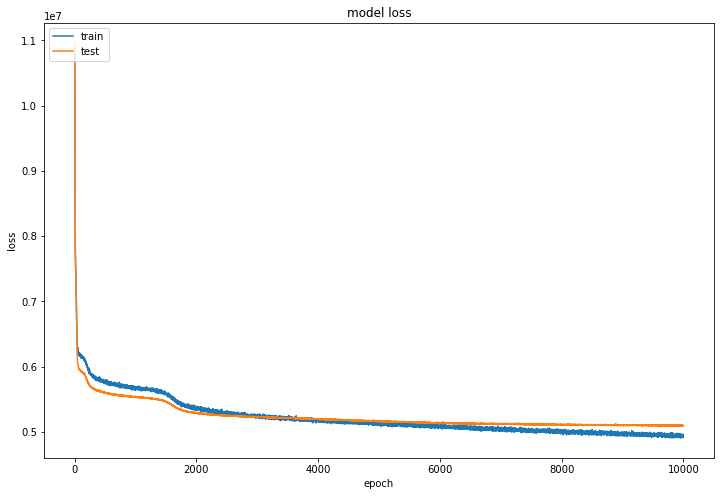

In [18]:
# 모델 평가
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.savefig('./sal_pre_model_loss.png')

In [15]:
hdf5_path = './model_save/temp/salary/9926-5091848.5000.hdf5'
loaded_model = load_model(hdf5_path, custom_objects={'rmse': rmse})

loaded_model.evaluate(X_val, y_val, verbose=1)

60/60 [==============================] - 0s 811us/step - loss: 5045146.0000 - root_mean_squared_error: 5110185.5000


[5045146.0, 5110185.5]

In [16]:
test_set

,player,team,position,netrtg,pitp,3fgm_%uast,ft%,ast/to,dreb%,pie,3p%,%tov,%pf,%pfd,age,inflation_salary
0,Chris Gatling,Denver Nuggets,PF,0.4974,0.275556,0.000,0.713,0.020000,0.184,0.810912,0.257,0.256,0.250,0.042,0.538462,NaN
1,A.C. Green,Los Angeles Lakers,PF,0.5166,0.102222,0.000,0.695,0.071905,0.160,0.805200,0.250,0.105,0.168,0.019,0.692308,NaN
2,Aaron McKie,Philadelphia 76ers,SG,0.5030,0.071111,0.000,0.829,0.100952,0.101,0.807367,0.364,0.176,0.194,0.008,0.346154,NaN
4,Allan Houston,New York Knicks,SG,0.5046,0.146667,0.104,0.838,0.057143,0.074,0.810321,0.436,0.200,0.141,0.020,0.423077,NaN
6,Andrew DeClercq,Cleveland Cavaliers,PF,0.4938,0.222222,0.000,0.588,0.025714,0.152,0.801655,0.000,0.160,0.275,0.041,0.346154,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11414,Deonte Burton,Sacramento Kings,SF,0.6036,0.000000,0.000,0.000,0.000000,0.000,0.779003,0.000,0.000,0.000,0.333,0.423077,NaN
11415,Julian Champagnie,Philadelphia 76ers,SF,0.4546,0.000000,0.000,0.000,0.000000,0.000,0.781761,0.000,0.000,0.000,0.000,0.115385,NaN
11416,Malcolm Hill,Chicago Bulls,SF,0.3858,0.000000,0.000,0.000,0.000000,0.250,0.803033,0.000,0.000,0.000,0.000,0.346154,NaN
11418,Michael Foster Jr.,Philadelphia 76ers,PF,0.3000,0.000000,0.000,0.000,0.000000,0.000,0.787867,0.000,0.000,0.000,0.000,0.076923,NaN


In [17]:
X1 = test_set.drop(["player", "team", "position", "inflation_salary"], axis=1)
y1 = test_set["inflation_salary"]

print(f"X1's shape : {X1.shape}")
print(f"y1's shape : {y1.shape}")

X1's shape : (1935, 12)
y1's shape : (1935,)


In [18]:
pred = loaded_model.predict(X1)
print(f"pred's shape : {pred.shape}")

61/61 [==============================] - 0s 684us/step
pred's shape : (1935, 1)


In [20]:
pred

array([[15902865.  ],
       [ 8650000.  ],
       [ 4667730.  ],
       ...,
       [  489567.53],
       [ 1128576.8 ],
       [ -180303.86]], dtype=float32)

In [21]:
pd.set_option('display.max_columns', None)
df = df.drop(["position_label"], axis=1)

In [22]:
dfNotna = df[df.inflation_salary.notna()]
dfIsna = df[df.inflation_salary.isna()]

In [23]:
dfIsna.inflation_salary = pred
dfIsna

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,player,team,defrtg,netrtg,ast/to,oreb%,dreb%,to_ratio,ts%,pace,pie,poss,stl%,%blk,def_ws,fbps,pitp,pf,%pts_2pt_mr,%pts_fbps,%pts_ft,%pts_offto,2fgm_%uast,3fgm_%uast,ft%,3p%,%3pm,%fta,%ast,%tov,%pf,%pfd,%pts,height,age,position,inflation_salary,season,obbs,+/-,pev
0,Chris Gatling,Denver Nuggets,100.6,-1.3,0.42,8.0,18.4,14.0,52.5,99.53,11.7,3749,26.7,10.6,0.069,0.9,6.2,2.9,16.8,7.9,26.3,17.4,49.6,0.0,71.3,25.7,12.3,35.1,9.0,25.6,25.0,4.2,27.2,208.28,32,PF,1.590286e+07,2000,0.400000,-0.7,2.09
1,A.C. Green,Los Angeles Lakers,97.0,8.3,1.51,8.0,16.0,9.4,48.2,93.55,8.8,3769,19.1,7.7,0.100,0.5,2.3,1.5,37.8,10.4,16.0,17.2,31.4,0.0,69.5,25.0,0.7,8.9,8.7,10.5,16.8,1.9,10.4,205.74,36,PF,8.650000e+06,2000,0.817073,4.0,1.91
2,Aaron McKie,Philadelphia 76ers,95.9,1.5,2.12,2.3,10.1,11.2,49.7,96.44,9.9,3922,29.1,10.8,0.113,1.1,1.6,2.4,41.0,13.6,18.5,15.3,42.0,0.0,82.9,36.4,42.3,12.3,28.0,17.6,19.4,0.8,17.1,195.58,27,SG,4.667730e+06,2000,0.597561,0.6,2.01
4,Allan Houston,New York Knicks,99.2,2.3,1.20,1.3,7.4,10.3,56.9,91.24,11.4,6032,15.5,5.1,0.140,1.4,3.3,2.7,46.2,6.9,17.4,14.2,54.9,10.4,83.8,43.6,34.2,23.3,17.7,20.0,14.1,2.0,26.4,198.12,29,SG,9.474888e+06,2000,0.609756,1.9,2.45
6,Andrew DeClercq,Cleveland Cavaliers,99.4,-3.1,0.54,8.5,15.2,15.9,53.0,98.77,7.0,3725,18.5,38.4,0.080,0.9,5.0,3.4,6.6,13.8,17.3,16.0,23.6,0.0,58.8,0.0,0.0,17.6,6.4,16.0,27.5,4.1,15.2,208.28,27,PF,6.945844e+06,2000,0.390244,-2.0,2.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11414,Deonte Burton,Sacramento Kings,112.5,51.8,0.00,0.0,0.0,0.0,0.0,110.80,-4.5,14,0.0,0.0,0.011,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.3,0.0,193.04,29,SF,1.681519e+06,2023,0.500000,2.5,1.41
11415,Julian Champagnie,Philadelphia 76ers,150.0,-22.7,0.00,0.0,0.0,0.0,0.0,82.80,-3.1,11,50.0,0.0,-0.023,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.66,21,SF,5.610024e+05,2023,1.000000,-2.0,1.70
11416,Malcolm Hill,Chicago Bulls,114.3,-57.1,0.00,0.0,25.0,0.0,0.0,148.24,7.7,7,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.12,27,SF,4.895675e+05,2023,1.000000,-1.0,1.29
11418,Michael Foster Jr.,Philadelphia 76ers,100.0,-100.0,0.00,0.0,0.0,0.0,0.0,92.90,0.0,2,0.0,0.0,0.006,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.20,20,PF,1.128577e+06,2023,1.000000,-2.0,0.87


In [24]:
resultDf = pd.concat([dfNotna, dfIsna]).sort_index()

In [25]:
resultDf.loc[resultDf.inflation_salary<0, 'inflation_salary'] = 4118.76

In [26]:
resultDf[resultDf.inflation_salary>=0].sort_values(by='inflation_salary')

,player,team,defrtg,netrtg,ast/to,oreb%,dreb%,to_ratio,ts%,pace,pie,poss,stl%,%blk,def_ws,fbps,pitp,pf,%pts_2pt_mr,%pts_fbps,%pts_ft,%pts_offto,2fgm_%uast,3fgm_%uast,ft%,3p%,%3pm,%fta,%ast,%tov,%pf,%pfd,%pts,height,age,position,inflation_salary,season,obbs,+/-,pev
11420,Trevor Keels,New York Knicks,66.7,-66.7,0.00,0.0,50.0,0.0,0.0,150.52,0.0,3,0.0,0.0,0.024,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193.04,19,SF,4118.76,2023,1.000000,-2.0,1.49
5766,Malcolm Thomas,San Antonio Spurs,112.9,-12.9,0.00,8.3,14.3,0.0,12.9,98.65,3.5,31,25.0,100.0,-0.002,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,50.0,0.0,0.0,28.6,12.5,0.0,0.0,57.1,3.2,205.74,23,SF,4118.76,2012,0.666667,-1.3,1.35
5763,Keith Benson,Golden State Warriors,75.0,36.8,0.00,18.2,9.1,0.0,0.0,86.72,3.4,17,0.0,0.0,0.031,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,210.82,23,C,4118.76,2012,0.333333,2.3,1.60
10904,DeJon Jarreau,Indiana Pacers,100.0,100.0,0.00,0.0,0.0,0.0,0.0,111.41,0.0,2,0.0,0.0,0.006,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195.58,24,SG,4118.76,2022,0.000000,2.0,1.33
10912,Matt Ryan,Boston Celtics,91.7,25.0,0.00,0.0,0.0,0.0,30.0,109.71,0.0,12,50.0,0.0,0.050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,50.0,0.0,0.0,0.0,0.0,0.0,21.4,200.66,25,SG,4118.76,2022,1.000000,3.0,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,Stephen Curry,Golden State Warriors,109.6,4.6,1.70,1.3,13.5,10.2,65.5,105.16,18.1,4725,20.9,3.8,0.112,3.6,8.1,1.9,6.6,11.4,17.9,14.5,58.9,41.2,91.6,42.1,48.1,39.2,27.5,30.1,12.2,32.8,37.3,190.50,33,PG,48167125.44,2021,0.587302,3.9,3.22
10336,Russell Westbrook,Los Angeles Lakers,111.5,-4.0,1.86,3.9,16.5,13.1,51.2,102.57,11.3,5730,17.9,7.1,0.090,1.9,9.8,3.0,12.1,10.5,18.5,11.4,76.8,35.4,66.7,29.8,12.7,31.1,41.8,37.1,20.8,27.7,23.4,190.50,33,PG,48190149.14,2022,0.397436,-2.7,3.01
10481,James Harden,Philadelphia 76ers,111.4,3.5,2.35,2.4,17.6,13.1,58.3,99.49,15.3,5015,21.8,13.4,0.099,2.2,7.3,2.4,2.9,9.8,32.8,13.7,81.1,74.3,87.7,33.0,25.0,43.4,51.4,41.9,15.4,36.9,24.9,195.58,32,SG,48298815.60,2022,0.615385,2.7,2.24
2272,Shaquille O'Neal,Miami Heat,101.7,10.0,0.99,11.2,19.7,11.1,58.3,92.65,16.1,4815,11.2,58.0,0.119,0.8,17.3,3.6,3.0,3.5,21.2,11.0,47.0,0.0,46.1,0.0,0.0,46.0,16.7,28.7,23.5,0.0,31.0,215.90,33,C,48615600.00,2005,0.726027,6.5,3.74


In [27]:
resultDf.to_csv("./data/NotNull.csv")